# Functions

In [1]:
import networkx as nx
import math
import matplotlib.pyplot as plt
from networkx.algorithms import tree
import pandas


In [5]:
__author__ = 'slhuang'
import os
import subprocess

def profiling(dir_path, endwith, result_dir='./result'):
    files=sorted(os.listdir(dir_path))
    print (files)
    artifacts = ''
    for f in files:
        if f.endswith(endwith): #f.startswith('repo'): #
            artifacts += dir_path + f + ','
    print ("----------profiling ----------")
    proc = subprocess.Popen(['../cpp/src/profiling/profiling', '-dir', artifacts, '-result', result_dir], 
                            stdout=subprocess.PIPE)
    output = proc.communicate()[0]
    print('Got stdout:', str(output).replace('\\r', '\n').replace('\\n', '\n'))


def pre_clustering(clustering_strategy, schema_file='./result/schema_matching.csv',result_dir='./result'):
    print ("---------pre_clustering----------")
    proc = subprocess.Popen(['../cpp/src/pre_clustering/pre_clustering', clustering_strategy,
                             '-schema_file', schema_file, '-result', result_dir],
                            stdout=subprocess.PIPE)
    output = proc.communicate()[0]
    print('Got stdout:', str(output).replace('\\r', '\n').replace('\\n', '\n'))

def clear_files():
    cmd = 'rm /home/slhuang/Public/2019_spring/lineage_inference/code/RELIC/RELIC_Silu/src/profiling/*.csv /home/slhuang/Public/2019_spring/lineage_inference/code/RELIC/RELIC_Silu/src/pre_clustering/*.csv /home/slhuang/Public/2019_spring/lineage_inference/code/RELIC/RELIC_Silu/src/preserving_ops/result/*.csv /home/slhuang/Public/2019_spring/lineage_inference/code/RELIC/RELIC_Silu/src/preserving_ops/*.csv'
    os.system(cmd)

def preserving_ops(dir_path, endwith, result_dir, schema_file='./result/schema_matching.csv',
                  row_file='./result/row_matching.csv', cluster_file='./result/clusters.csv'):
    files=sorted(os.listdir(dir_path))
    print (files)
    artifacts = ''
    for f in files:
        if f.endswith(endwith): #f.startswith('repo'): #
            artifacts += dir_path + f + ','
    print ("----------preserving-ops----------")
    proc = subprocess.Popen(['../cpp/src/preserving_ops/preserving_ops', '-dir', artifacts,
                            '-schema_file', schema_file, '-row_file', row_file, '-cluster_file', cluster_file,
                            '-result', result_dir], stdout=subprocess.PIPE)
    output = proc.communicate()[0]
    print('Got stdout:', str(output).replace('\\r', '\n').replace('\\n', '\n'))



In [6]:
import os
from lineage import graphs
import pandas as pd

def lineage_inference(wf_dir, pre_cluster='exact_schema', index=True):
    
    nb_name = os.path.basename(wf_dir)
    if index:
        artifact_dir = wf_dir+'/artifacts/'
    else:
        artifact_dir = wf_dir+'/artifacts_1/'
    
    result_dir = wf_dir+'/inferred/'
    schema_file = result_dir+'schema_matching.csv'
    row_file = result_dir+'row_matching.csv'
    cluster_file = result_dir+'clusters.csv'
    
    # Run the inference
    profiling(artifact_dir, '.csv', result_dir=result_dir)
    pre_clustering('-'+pre_cluster, schema_file=schema_file, result_dir=result_dir)
    preserving_ops(artifact_dir, '.csv', result_dir=result_dir, schema_file=schema_file, row_file=row_file, 
               cluster_file=cluster_file)
    
    # Load Ground Truth:
    g_truth = nx.read_gpickle(wf_dir+'/'+nb_name+'_gt.pkl')

    # Collect and analyze the results
    metric_types = ['cell', 'col']
    pr_df = pd.DataFrame(columns = ['nb_name', 'index', 'preclustering', 'distance_metric',
                                        'edges_correct', 'edges_missing', 'edges_to_remove', 
                                        'precision', 'recall', 'F1', ])
    
    for metric in metric_types:
        result_file = result_dir+'infered_mst_'+metric+'.csv'
        g_inferred = nx.read_edgelist(result_file, delimiter=',', data=(('weight', float),))
        result = graphs.get_precision_recall(g_truth,g_inferred)

        pr_df = pr_df.append({
                'nb_name': nb_name,
                'index': index,
                'preclustering': pre_cluster,
                'distance_metric': metric,
                'edges_correct': len(result['correct_edges']),
                'edges_missing': len(result['to_add']),
                'edges_to_remove': len(result['to_remove']),
                'precision': result['Precision'],
                'recall': result['Recall'],
                'F1': result['F1']
            }, ignore_index=True)
    
    return pr_df

In [67]:
pre_cluster_types = ['exact_schema', 'no_pre_cluster']
index_types = [True, False]

# Single Notebook Test

In [66]:
from tqdm import tqdm_notebook

one_df = pd.DataFrame(columns = ['nb_name', 'index', 'preclustering', 'distance_metric',
                                        'edges_correct', 'edges_missing', 'edges_to_remove', 
                                        'precision', 'recall', 'F1', ])

sample_wf_dir = '/media/suhail/Data/experiments/results/ok/nb_331056.ipynb'
files = glob.glob(sample_wf_dir+'/inferred/*')
for f in files:
    os.remove(f)
result_df = lineage_inference(sample_wf_dir, index=True, pre_cluster='partial_schema')
one_df = pd.concat([one_df, result_df],ignore_index=True)

['areaCrime.csv', 'areaCrime__1.csv', 'crimeTypes.csv', 'crimes.csv', 'crimesByMonth.csv', 'locationRecode.csv', 'typeLoc.csv', 'typeLoc__1.csv', 'typeLoc__2.csv', 'typeLoc__3.csv', 'typeOutcome.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts/areaCrime.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts/areaCrime__1.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts/crimeTypes.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts/crimes.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts/crimesByMonth.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts/locationRecode.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts/typeLoc.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts/typeLoc__1.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts/typeLoc__2.csv,/media

FileNotFoundError: [Errno 2] No such file or directory: '/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/inferred/infered_mst_cell.csv'

# Run for Multiple Notebooks

In [72]:
nb_list = [
    'nb_331056',
    'nb_23457',
    # nb_336256', #
    'nb_33614',
    # 'nb_650868', #
    'nb_316514',
    'nb_386796',
    'nb_266913',
    'nb_417011',
    'nb_269991',
    'nb_495072',
    'nb_315236',
    'nb_484354',
    'nb_772851',
    'nb_924102',
    'nb_921915',
    'nb_986282',
    # 'nb_582525', #
    'nb_639263',
]

In [74]:
from tqdm import tqdm_notebook
import glob

all_pr_df = pd.DataFrame(columns = ['nb_name', 'index', 'preclustering', 'distance_metric',
                                        'edges_correct', 'edges_missing', 'edges_to_remove', 
                                        'precision', 'recall', 'F1', ])

errors = []

for nb in tqdm_notebook(nb_list, desc='notebook', leave=True):
    nb_dir = ('/media/suhail/Data/experiments/results/ok/'+nb+'.ipynb')
    print('Processing:', nb_dir)
    os.makedirs(nb_dir+'/inferred', exist_ok=True)

    for cluster in tqdm_notebook(pre_cluster_types, desc='cluster', leave=True):
        for index in tqdm_notebook(index_types,  desc='index', leave=False):
            files = glob.glob(nb_dir+'/inferred/*')
            for f in files:
                os.remove(f)
            try:
                result_df = lineage_inference(nb_dir, index=index, pre_cluster=cluster)
                all_pr_df = pd.concat([all_pr_df, result_df],ignore_index=True)
            except FileNotFoundError as e:
                errors.append((nb_dir, cluster,index))
                pass
                
                

Processing: /media/suhail/Data/experiments/results/ok/nb_331056.ipynb


['areaCrime.csv', 'areaCrime__1.csv', 'crimeTypes.csv', 'crimes.csv', 'crimesByMonth.csv', 'locationRecode.csv', 'typeLoc.csv', 'typeLoc__1.csv', 'typeLoc__2.csv', 'typeLoc__3.csv', 'typeOutcome.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts/areaCrime.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts/areaCrime__1.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts/crimeTypes.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts/crimes.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts/crimesByMonth.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts/locationRecode.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts/typeLoc.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts/typeLoc__1.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts/typeLoc__2.csv,/media

Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts_1/areaCrime.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts_1/areaCrime__1.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts_1/crimeTypes.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts_1/crimes.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts_1/crimesByMonth.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts_1/locationRecode.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts_1/typeLoc.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts_1/typeLoc__1.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts_1/typeLoc__2.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts_1/typeLoc__3.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts_1/typeOutcome.csv,
--------- total number of files: 11 ---------
--

['areaCrime.csv', 'areaCrime__1.csv', 'crimeTypes.csv', 'crimes.csv', 'crimesByMonth.csv', 'locationRecode.csv', 'typeLoc.csv', 'typeLoc__1.csv', 'typeLoc__2.csv', 'typeLoc__3.csv', 'typeOutcome.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts/areaCrime.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts/areaCrime__1.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts/crimeTypes.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts/crimes.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts/crimesByMonth.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts/locationRecode.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts/typeLoc.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts/typeLoc__1.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts/typeLoc__2.csv,/media

Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts_1/areaCrime.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts_1/areaCrime__1.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts_1/crimeTypes.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts_1/crimes.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts_1/crimesByMonth.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts_1/locationRecode.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts_1/typeLoc.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts_1/typeLoc__1.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts_1/typeLoc__2.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts_1/typeLoc__3.csv,/media/suhail/Data/experiments/results/ok/nb_331056.ipynb/artifacts_1/typeOutcome.csv,
--------- total number of files: 11 ---------
--

['fan.csv', 'not_fan.csv', 'star_wars.csv', 'star_wars__1.csv', 'star_wars__2.csv', 'star_wars__3.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_23457.ipynb/artifacts/fan.csv,/media/suhail/Data/experiments/results/ok/nb_23457.ipynb/artifacts/not_fan.csv,/media/suhail/Data/experiments/results/ok/nb_23457.ipynb/artifacts/star_wars.csv,/media/suhail/Data/experiments/results/ok/nb_23457.ipynb/artifacts/star_wars__1.csv,/media/suhail/Data/experiments/results/ok/nb_23457.ipynb/artifacts/star_wars__2.csv,/media/suhail/Data/experiments/results/ok/nb_23457.ipynb/artifacts/star_wars__3.csv,
--------- total number of files: 6 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -------------------
----------------load files---------------
In total 6 files 
--------------finish identifying pks--------------
0 /media/suhail/Data/exp

Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_23457.ipynb/artifacts_1/fan.csv,/media/suhail/Data/experiments/results/ok/nb_23457.ipynb/artifacts_1/not_fan.csv,/media/suhail/Data/experiments/results/ok/nb_23457.ipynb/artifacts_1/star_wars.csv,/media/suhail/Data/experiments/results/ok/nb_23457.ipynb/artifacts_1/star_wars__1.csv,/media/suhail/Data/experiments/results/ok/nb_23457.ipynb/artifacts_1/star_wars__2.csv,/media/suhail/Data/experiments/results/ok/nb_23457.ipynb/artifacts_1/star_wars__3.csv,--------- total number of files: 6 ---------
---------load row_l2g row_l2g from file ----------- 
6 files in total. 
---------load col_g2l col_l2g from file ----------- 
6 files in total. 
----------------load files---------------
In total 6 files 
---------------load cluster from file---------------
In total 0 clusters
---------load row_l2g row_l2g from file ----------- 
6 files in total. 
---------load col_g2l col_l2g from file ----------- 
6 files in total. 
---------------load c

['fan.csv', 'not_fan.csv', 'star_wars.csv', 'star_wars__1.csv', 'star_wars__2.csv', 'star_wars__3.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_23457.ipynb/artifacts/fan.csv,/media/suhail/Data/experiments/results/ok/nb_23457.ipynb/artifacts/not_fan.csv,/media/suhail/Data/experiments/results/ok/nb_23457.ipynb/artifacts/star_wars.csv,/media/suhail/Data/experiments/results/ok/nb_23457.ipynb/artifacts/star_wars__1.csv,/media/suhail/Data/experiments/results/ok/nb_23457.ipynb/artifacts/star_wars__2.csv,/media/suhail/Data/experiments/results/ok/nb_23457.ipynb/artifacts/star_wars__3.csv,
--------- total number of files: 6 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -------------------
----------------load files---------------
In total 6 files 
--------------finish identifying pks--------------
0 /media/suhail/Data/exp

['messy.csv', 'messy1.csv', 'messy__1.csv', 'messy__2.csv', 'messy__3.csv', 'messy__4.csv', 'messy__5.csv', 'molten.csv', 'molten__1.csv', 'molten__2.csv', 'molten__3.csv', 'tb.csv', 'tidy.csv', 'tidy__1.csv', 'tidy__2.csv', 'tidy__3.csv', 'tidy__4.csv', 'tidy__5.csv', 'tidy__6.csv', 'tidy_rank.csv', 'tidy_track.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts/messy.csv,/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts/messy1.csv,/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts/messy__1.csv,/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts/messy__2.csv,/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts/messy__3.csv,/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts/messy__4.csv,/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts/messy__5.csv,/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts/molten.csv,/m

Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts_1/messy.csv,/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts_1/messy1.csv,/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts_1/messy__1.csv,/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts_1/messy__2.csv,/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts_1/messy__3.csv,/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts_1/messy__4.csv,/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts_1/messy__5.csv,/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts_1/molten.csv,/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts_1/molten__1.csv,/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts_1/molten__2.csv,/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts_1/molten__3.csv,/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts_1/tb.csv,/media/suhai

['messy.csv', 'messy1.csv', 'messy__1.csv', 'messy__2.csv', 'messy__3.csv', 'messy__4.csv', 'messy__5.csv', 'molten.csv', 'molten__1.csv', 'molten__2.csv', 'molten__3.csv', 'tb.csv', 'tidy.csv', 'tidy__1.csv', 'tidy__2.csv', 'tidy__3.csv', 'tidy__4.csv', 'tidy__5.csv', 'tidy__6.csv', 'tidy_rank.csv', 'tidy_track.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts/messy.csv,/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts/messy1.csv,/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts/messy__1.csv,/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts/messy__2.csv,/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts/messy__3.csv,/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts/messy__4.csv,/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts/messy__5.csv,/media/suhail/Data/experiments/results/ok/nb_33614.ipynb/artifacts/molten.csv,/m

['df.csv', 'df__1.csv', 'df__2.csv', 'df__3.csv', 'df__4.csv', 'df_gas.csv', 'df_gas__1.csv', 'df_gas_kubm.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_316514.ipynb/artifacts/df.csv,/media/suhail/Data/experiments/results/ok/nb_316514.ipynb/artifacts/df__1.csv,/media/suhail/Data/experiments/results/ok/nb_316514.ipynb/artifacts/df__2.csv,/media/suhail/Data/experiments/results/ok/nb_316514.ipynb/artifacts/df__3.csv,/media/suhail/Data/experiments/results/ok/nb_316514.ipynb/artifacts/df__4.csv,/media/suhail/Data/experiments/results/ok/nb_316514.ipynb/artifacts/df_gas.csv,/media/suhail/Data/experiments/results/ok/nb_316514.ipynb/artifacts/df_gas__1.csv,/media/suhail/Data/experiments/results/ok/nb_316514.ipynb/artifacts/df_gas_kubm.csv,
--------- total number of files: 8 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -

['df.csv', 'df__1.csv', 'df__2.csv', 'df__3.csv', 'df__4.csv', 'df_gas.csv', 'df_gas__1.csv', 'df_gas_kubm.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_316514.ipynb/artifacts/df.csv,/media/suhail/Data/experiments/results/ok/nb_316514.ipynb/artifacts/df__1.csv,/media/suhail/Data/experiments/results/ok/nb_316514.ipynb/artifacts/df__2.csv,/media/suhail/Data/experiments/results/ok/nb_316514.ipynb/artifacts/df__3.csv,/media/suhail/Data/experiments/results/ok/nb_316514.ipynb/artifacts/df__4.csv,/media/suhail/Data/experiments/results/ok/nb_316514.ipynb/artifacts/df_gas.csv,/media/suhail/Data/experiments/results/ok/nb_316514.ipynb/artifacts/df_gas__1.csv,/media/suhail/Data/experiments/results/ok/nb_316514.ipynb/artifacts/df_gas_kubm.csv,
--------- total number of files: 8 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -

Processing: /media/suhail/Data/experiments/results/ok/nb_386796.ipynb


['df.csv', 'gp1.csv', 'gp2.csv', 'gp2__1.csv', 'gp2__2.csv', 'gp2__3.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_386796.ipynb/artifacts/df.csv,/media/suhail/Data/experiments/results/ok/nb_386796.ipynb/artifacts/gp1.csv,/media/suhail/Data/experiments/results/ok/nb_386796.ipynb/artifacts/gp2.csv,/media/suhail/Data/experiments/results/ok/nb_386796.ipynb/artifacts/gp2__1.csv,/media/suhail/Data/experiments/results/ok/nb_386796.ipynb/artifacts/gp2__2.csv,/media/suhail/Data/experiments/results/ok/nb_386796.ipynb/artifacts/gp2__3.csv,
--------- total number of files: 6 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -------------------
----------------load files---------------
In total 6 files 
--------------finish identifying pks--------------
0 /media/suhail/Data/experiments/results/ok/nb_386796.ipynb/artifacts/df.csv

['df.csv', 'gp1.csv', 'gp2.csv', 'gp2__1.csv', 'gp2__2.csv', 'gp2__3.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_386796.ipynb/artifacts/df.csv,/media/suhail/Data/experiments/results/ok/nb_386796.ipynb/artifacts/gp1.csv,/media/suhail/Data/experiments/results/ok/nb_386796.ipynb/artifacts/gp2.csv,/media/suhail/Data/experiments/results/ok/nb_386796.ipynb/artifacts/gp2__1.csv,/media/suhail/Data/experiments/results/ok/nb_386796.ipynb/artifacts/gp2__2.csv,/media/suhail/Data/experiments/results/ok/nb_386796.ipynb/artifacts/gp2__3.csv,
--------- total number of files: 6 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -------------------
----------------load files---------------
In total 6 files 
--------------finish identifying pks--------------
0 /media/suhail/Data/experiments/results/ok/nb_386796.ipynb/artifacts/df.csv

['females.csv', 'males.csv', 'star_wars.csv', 'star_wars__1.csv', 'star_wars__2.csv', 'star_wars__3.csv', 'star_wars__4.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts/females.csv,/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts/males.csv,/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts/star_wars.csv,/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts/star_wars__1.csv,/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts/star_wars__2.csv,/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts/star_wars__3.csv,/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts/star_wars__4.csv,
--------- total number of files: 7 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -------------------
----------------load

Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts_1/females.csv,/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts_1/males.csv,/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts_1/star_wars.csv,/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts_1/star_wars__1.csv,/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts_1/star_wars__2.csv,/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts_1/star_wars__3.csv,/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts_1/star_wars__4.csv,
--------- total number of files: 7 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -------------------
----------------load files---------------
In total 7 files 
--------------finish identifying pks--------------
0 /media/suhail/Data/experiments/results/ok/nb_26691

['females.csv', 'males.csv', 'star_wars.csv', 'star_wars__1.csv', 'star_wars__2.csv', 'star_wars__3.csv', 'star_wars__4.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts/females.csv,/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts/males.csv,/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts/star_wars.csv,/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts/star_wars__1.csv,/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts/star_wars__2.csv,/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts/star_wars__3.csv,/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts/star_wars__4.csv,
--------- total number of files: 7 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -------------------
----------------load

['females.csv', 'males.csv', 'star_wars.csv', 'star_wars__1.csv', 'star_wars__2.csv', 'star_wars__3.csv', 'star_wars__4.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts_1/females.csv,/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts_1/males.csv,/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts_1/star_wars.csv,/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts_1/star_wars__1.csv,/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts_1/star_wars__2.csv,/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts_1/star_wars__3.csv,/media/suhail/Data/experiments/results/ok/nb_266913.ipynb/artifacts_1/star_wars__4.csv,
--------- total number of files: 7 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -------------------
------

['contribs.csv', 'merged.csv', 'oppose.csv', 'prop.csv', 'props.csv', 'support.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_417011.ipynb/artifacts/contribs.csv,/media/suhail/Data/experiments/results/ok/nb_417011.ipynb/artifacts/merged.csv,/media/suhail/Data/experiments/results/ok/nb_417011.ipynb/artifacts/oppose.csv,/media/suhail/Data/experiments/results/ok/nb_417011.ipynb/artifacts/prop.csv,/media/suhail/Data/experiments/results/ok/nb_417011.ipynb/artifacts/props.csv,/media/suhail/Data/experiments/results/ok/nb_417011.ipynb/artifacts/support.csv,
--------- total number of files: 6 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -------------------
----------------load files---------------
In total 6 files 
--------------finish identifying pks--------------
0 /media/suhail/Data/experiments/results/ok/nb_417011.ip

Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_417011.ipynb/artifacts_1/contribs.csv,/media/suhail/Data/experiments/results/ok/nb_417011.ipynb/artifacts_1/merged.csv,/media/suhail/Data/experiments/results/ok/nb_417011.ipynb/artifacts_1/oppose.csv,/media/suhail/Data/experiments/results/ok/nb_417011.ipynb/artifacts_1/prop.csv,/media/suhail/Data/experiments/results/ok/nb_417011.ipynb/artifacts_1/props.csv,/media/suhail/Data/experiments/results/ok/nb_417011.ipynb/artifacts_1/support.csv,--------- total number of files: 6 ---------
---------load row_l2g row_l2g from file ----------- 
6 files in total. 
---------load col_g2l col_l2g from file ----------- 
6 files in total. 
----------------load files---------------
In total 6 files 
---------------load cluster from file---------------
In total 0 clusters
---------load row_l2g row_l2g from file ----------- 
6 files in total. 
---------load col_g2l col_l2g from file ----------- 
6 files in total. 
---------------load cluster from f

['contribs.csv', 'merged.csv', 'oppose.csv', 'prop.csv', 'props.csv', 'support.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_417011.ipynb/artifacts/contribs.csv,/media/suhail/Data/experiments/results/ok/nb_417011.ipynb/artifacts/merged.csv,/media/suhail/Data/experiments/results/ok/nb_417011.ipynb/artifacts/oppose.csv,/media/suhail/Data/experiments/results/ok/nb_417011.ipynb/artifacts/prop.csv,/media/suhail/Data/experiments/results/ok/nb_417011.ipynb/artifacts/props.csv,/media/suhail/Data/experiments/results/ok/nb_417011.ipynb/artifacts/support.csv,
--------- total number of files: 6 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -------------------
----------------load files---------------
In total 6 files 
--------------finish identifying pks--------------
0 /media/suhail/Data/experiments/results/ok/nb_417011.ip

Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_417011.ipynb/artifacts_1/contribs.csv,/media/suhail/Data/experiments/results/ok/nb_417011.ipynb/artifacts_1/merged.csv,/media/suhail/Data/experiments/results/ok/nb_417011.ipynb/artifacts_1/oppose.csv,/media/suhail/Data/experiments/results/ok/nb_417011.ipynb/artifacts_1/prop.csv,/media/suhail/Data/experiments/results/ok/nb_417011.ipynb/artifacts_1/props.csv,/media/suhail/Data/experiments/results/ok/nb_417011.ipynb/artifacts_1/support.csv,--------- total number of files: 6 ---------
---------load row_l2g row_l2g from file ----------- 
6 files in total. 
---------load col_g2l col_l2g from file ----------- 
6 files in total. 
----------------load files---------------
In total 6 files 
---------------load cluster from file---------------
In total 0 clusters
---------load row_l2g row_l2g from file ----------- 
6 files in total. 
---------load col_g2l col_l2g from file ----------- 
6 files in total. 
---------------load cluster from f

['df.csv', 'df2.csv', 'df__1.csv', 'df__2.csv', 'df__3.csv', 'new_df.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_269991.ipynb/artifacts/df.csv,/media/suhail/Data/experiments/results/ok/nb_269991.ipynb/artifacts/df2.csv,/media/suhail/Data/experiments/results/ok/nb_269991.ipynb/artifacts/df__1.csv,/media/suhail/Data/experiments/results/ok/nb_269991.ipynb/artifacts/df__2.csv,/media/suhail/Data/experiments/results/ok/nb_269991.ipynb/artifacts/df__3.csv,/media/suhail/Data/experiments/results/ok/nb_269991.ipynb/artifacts/new_df.csv,
--------- total number of files: 6 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -------------------
----------------load files---------------
In total 6 files 
--------------finish identifying pks--------------
0 /media/suhail/Data/experiments/results/ok/nb_269991.ipynb/artifacts/df.csv

Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_269991.ipynb/artifacts_1/df.csv,/media/suhail/Data/experiments/results/ok/nb_269991.ipynb/artifacts_1/df2.csv,/media/suhail/Data/experiments/results/ok/nb_269991.ipynb/artifacts_1/df__1.csv,/media/suhail/Data/experiments/results/ok/nb_269991.ipynb/artifacts_1/df__2.csv,/media/suhail/Data/experiments/results/ok/nb_269991.ipynb/artifacts_1/df__3.csv,/media/suhail/Data/experiments/results/ok/nb_269991.ipynb/artifacts_1/new_df.csv,--------- total number of files: 6 ---------
---------load row_l2g row_l2g from file ----------- 
6 files in total. 
---------load col_g2l col_l2g from file ----------- 
6 files in total. 
----------------load files---------------
In total 6 files 
---------------load cluster from file---------------
In total 0 clusters
---------load row_l2g row_l2g from file ----------- 
6 files in total. 
---------load col_g2l col_l2g from file ----------- 
6 files in total. 
---------------load cluster from file-------

['df.csv', 'df2.csv', 'df__1.csv', 'df__2.csv', 'df__3.csv', 'new_df.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_269991.ipynb/artifacts/df.csv,/media/suhail/Data/experiments/results/ok/nb_269991.ipynb/artifacts/df2.csv,/media/suhail/Data/experiments/results/ok/nb_269991.ipynb/artifacts/df__1.csv,/media/suhail/Data/experiments/results/ok/nb_269991.ipynb/artifacts/df__2.csv,/media/suhail/Data/experiments/results/ok/nb_269991.ipynb/artifacts/df__3.csv,/media/suhail/Data/experiments/results/ok/nb_269991.ipynb/artifacts/new_df.csv,
--------- total number of files: 6 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -------------------
----------------load files---------------
In total 6 files 
--------------finish identifying pks--------------
0 /media/suhail/Data/experiments/results/ok/nb_269991.ipynb/artifacts/df.csv

['contribs.csv', 'merged.csv', 'noncacontribs.csv', 'oppose.csv', 'prop.csv', 'props.csv', 'support.csv', 'top_supporters.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts/contribs.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts/merged.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts/noncacontribs.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts/oppose.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts/prop.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts/props.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts/support.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts/top_supporters.csv,
--------- total number of files: 8 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish sche

Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts_1/contribs.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts_1/merged.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts_1/noncacontribs.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts_1/oppose.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts_1/prop.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts_1/props.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts_1/support.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts_1/top_supporters.csv,
--------- total number of files: 8 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -------------------
----------------load files---------------
In total 8 files 
--------------finish identifying p

['contribs.csv', 'merged.csv', 'noncacontribs.csv', 'oppose.csv', 'prop.csv', 'props.csv', 'support.csv', 'top_supporters.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts/contribs.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts/merged.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts/noncacontribs.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts/oppose.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts/prop.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts/props.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts/support.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts/top_supporters.csv,
--------- total number of files: 8 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish sche

Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts_1/contribs.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts_1/merged.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts_1/noncacontribs.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts_1/oppose.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts_1/prop.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts_1/props.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts_1/support.csv,/media/suhail/Data/experiments/results/ok/nb_495072.ipynb/artifacts_1/top_supporters.csv,
--------- total number of files: 8 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -------------------
----------------load files---------------
In total 8 files 
--------------finish identifying p

['AtlasHS.csv', 'AtlasHSWithMexMerge.csv', 'AtlasHS_WithNoMexican.csv', 'HSdf.csv', 'HSdf__1.csv', 'MexHS.csv', 'MexHS__1.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts/AtlasHS.csv,/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts/AtlasHSWithMexMerge.csv,/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts/AtlasHS_WithNoMexican.csv,/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts/HSdf.csv,/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts/HSdf__1.csv,/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts/MexHS.csv,/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts/MexHS__1.csv,
--------- total number of files: 7 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -------------------
----------------

['AtlasHS.csv', 'AtlasHSWithMexMerge.csv', 'AtlasHS_WithNoMexican.csv', 'HSdf.csv', 'HSdf__1.csv', 'MexHS.csv', 'MexHS__1.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts_1/AtlasHS.csv,/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts_1/AtlasHSWithMexMerge.csv,/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts_1/AtlasHS_WithNoMexican.csv,/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts_1/HSdf.csv,/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts_1/HSdf__1.csv,/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts_1/MexHS.csv,/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts_1/MexHS__1.csv,
--------- total number of files: 7 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -------------------
--

['AtlasHS.csv', 'AtlasHSWithMexMerge.csv', 'AtlasHS_WithNoMexican.csv', 'HSdf.csv', 'HSdf__1.csv', 'MexHS.csv', 'MexHS__1.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts/AtlasHS.csv,/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts/AtlasHSWithMexMerge.csv,/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts/AtlasHS_WithNoMexican.csv,/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts/HSdf.csv,/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts/HSdf__1.csv,/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts/MexHS.csv,/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts/MexHS__1.csv,
--------- total number of files: 7 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -------------------
----------------

Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts_1/AtlasHS.csv,/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts_1/AtlasHSWithMexMerge.csv,/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts_1/AtlasHS_WithNoMexican.csv,/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts_1/HSdf.csv,/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts_1/HSdf__1.csv,/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts_1/MexHS.csv,/media/suhail/Data/experiments/results/ok/nb_315236.ipynb/artifacts_1/MexHS__1.csv,
--------- total number of files: 7 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -------------------
----------------load files---------------
In total 7 files 
--------------finish identifying pks--------------
0 /media/suhail/Data/experiments/results/ok/nb_315

['df.csv', 'df__1.csv', 'df__2.csv', 'edf.csv', 'edf__1.csv', 'edf__2.csv', 'edf__3.csv', 'edf__4.csv', 'edf__5.csv', 'edf__6.csv', 'edf__7.csv', 'kdf.csv', 'kdf__1.csv', 'tdf.csv', 'tdf__1.csv', 'tdf__2.csv', 'tdf__3.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts/df.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts/df__1.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts/df__2.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts/edf.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts/edf__1.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts/edf__2.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts/edf__3.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts/edf__4.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts/edf__5.csv,/media/suhail/Data/experiment

['df.csv', 'df__1.csv', 'df__2.csv', 'edf.csv', 'edf__1.csv', 'edf__2.csv', 'edf__3.csv', 'edf__4.csv', 'edf__5.csv', 'edf__6.csv', 'edf__7.csv', 'kdf.csv', 'kdf__1.csv', 'tdf.csv', 'tdf__1.csv', 'tdf__2.csv', 'tdf__3.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts_1/df.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts_1/df__1.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts_1/df__2.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts_1/edf.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts_1/edf__1.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts_1/edf__2.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts_1/edf__3.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts_1/edf__4.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts_1/edf__5.csv,/media/suha

['df.csv', 'df__1.csv', 'df__2.csv', 'edf.csv', 'edf__1.csv', 'edf__2.csv', 'edf__3.csv', 'edf__4.csv', 'edf__5.csv', 'edf__6.csv', 'edf__7.csv', 'kdf.csv', 'kdf__1.csv', 'tdf.csv', 'tdf__1.csv', 'tdf__2.csv', 'tdf__3.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts/df.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts/df__1.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts/df__2.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts/edf.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts/edf__1.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts/edf__2.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts/edf__3.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts/edf__4.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts/edf__5.csv,/media/suhail/Data/experiment

Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts_1/df.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts_1/df__1.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts_1/df__2.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts_1/edf.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts_1/edf__1.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts_1/edf__2.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts_1/edf__3.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts_1/edf__4.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts_1/edf__5.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts_1/edf__6.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts_1/edf__7.csv,/media/suhail/Data/experiments/results/ok/nb_484354.ipynb/artifacts_1/kdf.csv,/media/suhail/Data/experim

['df.csv', 'df_imputed.csv', 'df_imputed__1.csv', 'df_imputed_jitter.csv', 'df_normalized.csv', 'df_normalized__1.csv', 'df_normalized__2.csv', 'df_sub.csv', 'df_sub__1.csv', 'df_sub__2.csv', 'survival.csv', 'survival_counts.csv', 'survival_rate.csv', 'survival_rate__1.csv', 'tmpdf.csv', 'tmpdf__1.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts/df.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts/df_imputed.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts/df_imputed__1.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts/df_imputed_jitter.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts/df_normalized.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts/df_normalized__1.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts/df_normalized__2.csv,/media/suhail/Data/experiments/results/ok/nb_772851.

Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts_1/df.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts_1/df_imputed.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts_1/df_imputed__1.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts_1/df_imputed_jitter.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts_1/df_normalized.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts_1/df_normalized__1.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts_1/df_normalized__2.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts_1/df_sub.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts_1/df_sub__1.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts_1/df_sub__2.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts_1/survival.csv,/media/suhail/Data/experiments/results/ok/

['df.csv', 'df_imputed.csv', 'df_imputed__1.csv', 'df_imputed_jitter.csv', 'df_normalized.csv', 'df_normalized__1.csv', 'df_normalized__2.csv', 'df_sub.csv', 'df_sub__1.csv', 'df_sub__2.csv', 'survival.csv', 'survival_counts.csv', 'survival_rate.csv', 'survival_rate__1.csv', 'tmpdf.csv', 'tmpdf__1.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts/df.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts/df_imputed.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts/df_imputed__1.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts/df_imputed_jitter.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts/df_normalized.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts/df_normalized__1.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts/df_normalized__2.csv,/media/suhail/Data/experiments/results/ok/nb_772851.

Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts_1/df.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts_1/df_imputed.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts_1/df_imputed__1.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts_1/df_imputed_jitter.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts_1/df_normalized.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts_1/df_normalized__1.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts_1/df_normalized__2.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts_1/df_sub.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts_1/df_sub__1.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts_1/df_sub__2.csv,/media/suhail/Data/experiments/results/ok/nb_772851.ipynb/artifacts_1/survival.csv,/media/suhail/Data/experiments/results/ok/

Processing: /media/suhail/Data/experiments/results/ok/nb_924102.ipynb


['dataset.csv', 'dataset_final.csv', 'dataset_pop.csv', 'dataset_pop__1.csv', 'dataset_school.csv', 'dataset_viz.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_924102.ipynb/artifacts/dataset.csv,/media/suhail/Data/experiments/results/ok/nb_924102.ipynb/artifacts/dataset_final.csv,/media/suhail/Data/experiments/results/ok/nb_924102.ipynb/artifacts/dataset_pop.csv,/media/suhail/Data/experiments/results/ok/nb_924102.ipynb/artifacts/dataset_pop__1.csv,/media/suhail/Data/experiments/results/ok/nb_924102.ipynb/artifacts/dataset_school.csv,/media/suhail/Data/experiments/results/ok/nb_924102.ipynb/artifacts/dataset_viz.csv,
--------- total number of files: 6 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -------------------
----------------load files---------------
In total 6 files 
--------------finish identifying pks---

Got stdout: b'---------load global_cids from file ----------- 
6 files in total. 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21  0
22 23 24 25 26 27 28 29 30 31 32 33 34 35  1
3 36 37 38 39 40 41 42  2
39 40 41 42  3
43 44 45 46  4
32 33  5
--------- cluster with the exact schema ---------
6 clusters
'
['dataset.csv', 'dataset_final.csv', 'dataset_pop.csv', 'dataset_pop__1.csv', 'dataset_school.csv', 'dataset_viz.csv']
----------preserving-ops----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_924102.ipynb/artifacts_1/dataset.csv,/media/suhail/Data/experiments/results/ok/nb_924102.ipynb/artifacts_1/dataset_final.csv,/media/suhail/Data/experiments/results/ok/nb_924102.ipynb/artifacts_1/dataset_pop.csv,/media/suhail/Data/experiments/results/ok/nb_924102.ipynb/artifacts_1/dataset_pop__1.csv,/media/suhail/Data/experiments/results/ok/nb_924102.ipynb/artifacts_1/dataset_school.csv,/media/suhail/Data/experiments/results/ok/nb_924102.ipynb/artifacts_1/dataset_viz.cs

['dataset.csv', 'dataset_final.csv', 'dataset_pop.csv', 'dataset_pop__1.csv', 'dataset_school.csv', 'dataset_viz.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_924102.ipynb/artifacts/dataset.csv,/media/suhail/Data/experiments/results/ok/nb_924102.ipynb/artifacts/dataset_final.csv,/media/suhail/Data/experiments/results/ok/nb_924102.ipynb/artifacts/dataset_pop.csv,/media/suhail/Data/experiments/results/ok/nb_924102.ipynb/artifacts/dataset_pop__1.csv,/media/suhail/Data/experiments/results/ok/nb_924102.ipynb/artifacts/dataset_school.csv,/media/suhail/Data/experiments/results/ok/nb_924102.ipynb/artifacts/dataset_viz.csv,
--------- total number of files: 6 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -------------------
----------------load files---------------
In total 6 files 
--------------finish identifying pks---

['data.csv', 'data__1.csv', 'data__2.csv', 'data_breed_1.csv', 'data_breeds.csv', 'separate_breeds.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_921915.ipynb/artifacts/data.csv,/media/suhail/Data/experiments/results/ok/nb_921915.ipynb/artifacts/data__1.csv,/media/suhail/Data/experiments/results/ok/nb_921915.ipynb/artifacts/data__2.csv,/media/suhail/Data/experiments/results/ok/nb_921915.ipynb/artifacts/data_breed_1.csv,/media/suhail/Data/experiments/results/ok/nb_921915.ipynb/artifacts/data_breeds.csv,/media/suhail/Data/experiments/results/ok/nb_921915.ipynb/artifacts/separate_breeds.csv,
--------- total number of files: 6 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -------------------
----------------load files---------------
In total 6 files 
--------------finish identifying pks--------------
0 /media/suhail/

Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_921915.ipynb/artifacts_1/data.csv,/media/suhail/Data/experiments/results/ok/nb_921915.ipynb/artifacts_1/data__1.csv,/media/suhail/Data/experiments/results/ok/nb_921915.ipynb/artifacts_1/data__2.csv,/media/suhail/Data/experiments/results/ok/nb_921915.ipynb/artifacts_1/data_breed_1.csv,/media/suhail/Data/experiments/results/ok/nb_921915.ipynb/artifacts_1/data_breeds.csv,/media/suhail/Data/experiments/results/ok/nb_921915.ipynb/artifacts_1/separate_breeds.csv,--------- total number of files: 6 ---------
---------load row_l2g row_l2g from file ----------- 
6 files in total. 
---------load col_g2l col_l2g from file ----------- 
6 files in total. 
----------------load files---------------
In total 6 files 
---------------load cluster from file---------------
In total 0 clusters
---------load row_l2g row_l2g from file ----------- 
6 files in total. 
---------load col_g2l col_l2g from file ----------- 
6 files in total. 
--------------

['data.csv', 'data__1.csv', 'data__2.csv', 'data_breed_1.csv', 'data_breeds.csv', 'separate_breeds.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_921915.ipynb/artifacts/data.csv,/media/suhail/Data/experiments/results/ok/nb_921915.ipynb/artifacts/data__1.csv,/media/suhail/Data/experiments/results/ok/nb_921915.ipynb/artifacts/data__2.csv,/media/suhail/Data/experiments/results/ok/nb_921915.ipynb/artifacts/data_breed_1.csv,/media/suhail/Data/experiments/results/ok/nb_921915.ipynb/artifacts/data_breeds.csv,/media/suhail/Data/experiments/results/ok/nb_921915.ipynb/artifacts/separate_breeds.csv,
--------- total number of files: 6 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -------------------
----------------load files---------------
In total 6 files 
--------------finish identifying pks--------------
0 /media/suhail/

Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_921915.ipynb/artifacts_1/data.csv,/media/suhail/Data/experiments/results/ok/nb_921915.ipynb/artifacts_1/data__1.csv,/media/suhail/Data/experiments/results/ok/nb_921915.ipynb/artifacts_1/data__2.csv,/media/suhail/Data/experiments/results/ok/nb_921915.ipynb/artifacts_1/data_breed_1.csv,/media/suhail/Data/experiments/results/ok/nb_921915.ipynb/artifacts_1/data_breeds.csv,/media/suhail/Data/experiments/results/ok/nb_921915.ipynb/artifacts_1/separate_breeds.csv,--------- total number of files: 6 ---------
---------load row_l2g row_l2g from file ----------- 
6 files in total. 
---------load col_g2l col_l2g from file ----------- 
6 files in total. 
----------------load files---------------
In total 6 files 
---------------load cluster from file---------------
In total 0 clusters
---------load row_l2g row_l2g from file ----------- 
6 files in total. 
---------load col_g2l col_l2g from file ----------- 
6 files in total. 
--------------

['piv.csv', 'sub1.csv', 'sub2.csv', 'sub_df.csv', 'tmp.csv', 'winners.csv', 'winners2.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_986282.ipynb/artifacts/piv.csv,/media/suhail/Data/experiments/results/ok/nb_986282.ipynb/artifacts/sub1.csv,/media/suhail/Data/experiments/results/ok/nb_986282.ipynb/artifacts/sub2.csv,/media/suhail/Data/experiments/results/ok/nb_986282.ipynb/artifacts/sub_df.csv,/media/suhail/Data/experiments/results/ok/nb_986282.ipynb/artifacts/tmp.csv,/media/suhail/Data/experiments/results/ok/nb_986282.ipynb/artifacts/winners.csv,/media/suhail/Data/experiments/results/ok/nb_986282.ipynb/artifacts/winners2.csv,
--------- total number of files: 7 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -------------------
----------------load files---------------
In total 7 files 
--------------finish identif

Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_986282.ipynb/artifacts_1/piv.csv,/media/suhail/Data/experiments/results/ok/nb_986282.ipynb/artifacts_1/sub1.csv,/media/suhail/Data/experiments/results/ok/nb_986282.ipynb/artifacts_1/sub2.csv,/media/suhail/Data/experiments/results/ok/nb_986282.ipynb/artifacts_1/sub_df.csv,/media/suhail/Data/experiments/results/ok/nb_986282.ipynb/artifacts_1/tmp.csv,/media/suhail/Data/experiments/results/ok/nb_986282.ipynb/artifacts_1/winners.csv,/media/suhail/Data/experiments/results/ok/nb_986282.ipynb/artifacts_1/winners2.csv,
--------- total number of files: 7 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -------------------
----------------load files---------------
In total 7 files 
--------------finish identifying pks--------------
0 /media/suhail/Data/experiments/results/ok/nb_986282.ipynb/artifacts_1/piv.csv 9
1 /m

['piv.csv', 'sub1.csv', 'sub2.csv', 'sub_df.csv', 'tmp.csv', 'winners.csv', 'winners2.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_986282.ipynb/artifacts/piv.csv,/media/suhail/Data/experiments/results/ok/nb_986282.ipynb/artifacts/sub1.csv,/media/suhail/Data/experiments/results/ok/nb_986282.ipynb/artifacts/sub2.csv,/media/suhail/Data/experiments/results/ok/nb_986282.ipynb/artifacts/sub_df.csv,/media/suhail/Data/experiments/results/ok/nb_986282.ipynb/artifacts/tmp.csv,/media/suhail/Data/experiments/results/ok/nb_986282.ipynb/artifacts/winners.csv,/media/suhail/Data/experiments/results/ok/nb_986282.ipynb/artifacts/winners2.csv,
--------- total number of files: 7 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -------------------
----------------load files---------------
In total 7 files 
--------------finish identif

['df.csv', 'df1.csv', 'df1__1.csv', 'df2.csv', 'df2__1.csv', 'df3.csv', 'w.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts/df.csv,/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts/df1.csv,/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts/df1__1.csv,/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts/df2.csv,/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts/df2__1.csv,/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts/df3.csv,/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts/w.csv,
--------- total number of files: 7 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -------------------
----------------load files---------------
In total 7 files 
--------------finish identifying pks--------------

Got stdout: b'---------load global_cids from file ----------- 
7 files in total. 
0 1 2 3 4 5  0
0 1 2 3 4 5  1
0 1 2 3 4 6  2
1 2 3 5 7 8  3
0 1 2 3 4 6  4
1 2 7 8  5
0 1 2 3 4 5  6
--------- cluster with the exact schema ---------
4 clusters
'
['df.csv', 'df1.csv', 'df1__1.csv', 'df2.csv', 'df2__1.csv', 'df3.csv', 'w.csv']
----------preserving-ops----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts_1/df.csv,/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts_1/df1.csv,/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts_1/df1__1.csv,/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts_1/df2.csv,/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts_1/df2__1.csv,/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts_1/df3.csv,/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts_1/w.csv,--------- total number of files: 7 ---------
---------load row_l2g row_l2g 

['df.csv', 'df1.csv', 'df1__1.csv', 'df2.csv', 'df2__1.csv', 'df3.csv', 'w.csv']
----------profiling ----------
Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts/df.csv,/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts/df1.csv,/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts/df1__1.csv,/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts/df2.csv,/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts/df2__1.csv,/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts/df3.csv,/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts/w.csv,
--------- total number of files: 7 ---------
-----------initialize synonyms------------
--------schema matching load_header_and_sample_value-----------
----------------finish schema matching by name and type -------------------
----------------load files---------------
In total 7 files 
--------------finish identifying pks--------------

Got stdout: b'/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts_1/df.csv,/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts_1/df1.csv,/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts_1/df1__1.csv,/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts_1/df2.csv,/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts_1/df2__1.csv,/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts_1/df3.csv,/media/suhail/Data/experiments/results/ok/nb_639263.ipynb/artifacts_1/w.csv,--------- total number of files: 7 ---------
---------load row_l2g row_l2g from file ----------- 
7 files in total. 
---------load col_g2l col_l2g from file ----------- 
7 files in total. 
----------------load files---------------
In total 7 files 
---------------load cluster from file---------------
In total 0 clusters
---------load row_l2g row_l2g from file ----------- 
7 files in total. 
---------load col_g2l col_l2g from file ---

In [75]:
errors

[]

In [101]:
all_pr_df

nb_name  index   preclustering distance_metric edges_correct  \
0   nb_331057.ipynb   True    exact_schema            cell             3   
1   nb_331057.ipynb   True    exact_schema             col             3   
2   nb_331057.ipynb  False    exact_schema            cell             1   
3   nb_331057.ipynb  False    exact_schema             col             4   
4   nb_331057.ipynb   True  partial_schema            cell             1   
5   nb_331057.ipynb   True  partial_schema             col             4   
6   nb_331057.ipynb  False  partial_schema            cell             1   
7   nb_331057.ipynb  False  partial_schema             col             4   
8   nb_331057.ipynb   True              PK            cell             1   
9   nb_331057.ipynb   True              PK             col             4   
10  nb_331057.ipynb  False              PK            cell             1   
11  nb_331057.ipynb  False              PK             col             4   
12  nb_331057.ipynb   True  no_pre_cluster            cell             1   
13  nb_331057.ipynb   True  no_pre_cluster             col             2   
14  nb_331057.ipynb  False  no_pre_cluster            cell             1   
15  nb_331057.ipynb  False  no_pre_cluster             col             2   

   edges_missing edges_to_remove  precision    recall        F1  
0              9               7   0.250000  0.300000  0.272727  
1              9               7   0.250000  0.300000  0.272727  
2             11               3   0.083333  0.250000  0.125000  
3              8               3   0.333333  0.571429  0.421053  
4             11               3   0.083333  0.250000  0.125000  
5              8               3   0.333333  0.571429  0.421053  
6             11               3   0.083333  0.250000  0.125000  
7              8               3   0.333333  0.571429  0.421053  
8             11               3   0.083333  0.250000  0.125000  
9              8               3   0.333333  0.571429  0.421053  
10            11               3   0.083333  0.250000  0.125000  
11             8               3   0.333333  0.571429  0.421053  
12            11               9   0.083333  0.100000  0.090909  
13            10               8   0.166667  0.200000  0.181818  
14            11               3   0.083333  0.250000  0.125000  
15            10               5   0.166667  0.285714  0.210526

In [81]:
all_pr_df.sort_values('F1', ascending=False)

nb_name  index   preclustering distance_metric edges_correct  \
113  nb_986282.ipynb   True    exact_schema             col             5   
65   nb_495072.ipynb   True    exact_schema             col             6   
117  nb_986282.ipynb   True  no_pre_cluster             col             4   
69   nb_495072.ipynb   True  no_pre_cluster             col             5   
61   nb_269991.ipynb   True  no_pre_cluster             col             3   
57   nb_269991.ipynb   True    exact_schema             col             3   
56   nb_269991.ipynb   True    exact_schema            cell             3   
41   nb_266913.ipynb   True    exact_schema             col             3   
51   nb_417011.ipynb  False    exact_schema             col             3   
49   nb_417011.ipynb   True    exact_schema             col             3   
55   nb_417011.ipynb  False  no_pre_cluster             col             3   
62   nb_269991.ipynb  False  no_pre_cluster            cell             2   
63   nb_269991.ipynb  False  no_pre_cluster             col             2   
33   nb_386796.ipynb   True    exact_schema             col             2   
58   nb_269991.ipynb  False    exact_schema            cell             2   
59   nb_269991.ipynb  False    exact_schema             col             2   
37   nb_386796.ipynb   True  no_pre_cluster             col             2   
3    nb_331056.ipynb  False    exact_schema             col             4   
13    nb_23457.ipynb   True  no_pre_cluster             col             2   
9     nb_23457.ipynb   True    exact_schema             col             2   
67   nb_495072.ipynb  False    exact_schema             col             3   
71   nb_495072.ipynb  False  no_pre_cluster             col             3   
105  nb_921915.ipynb   True    exact_schema             col             2   
109  nb_921915.ipynb   True  no_pre_cluster             col             2   
104  nb_921915.ipynb   True    exact_schema            cell             2   
45   nb_266913.ipynb   True  no_pre_cluster             col             2   
43   nb_266913.ipynb  False    exact_schema             col             2   
78   nb_315236.ipynb  False  no_pre_cluster            cell             2   
74   nb_315236.ipynb  False    exact_schema            cell             2   
66   nb_495072.ipynb  False    exact_schema            cell             2   
..               ...    ...             ...             ...           ...   
116  nb_986282.ipynb   True  no_pre_cluster            cell             0   
115  nb_986282.ipynb  False    exact_schema             col             0   
114  nb_986282.ipynb  False    exact_schema            cell             0   
24   nb_316514.ipynb   True    exact_schema            cell             0   
54   nb_417011.ipynb  False  no_pre_cluster            cell             0   
102  nb_924102.ipynb  False  no_pre_cluster            cell             0   
26   nb_316514.ipynb  False    exact_schema            cell             0   
50   nb_417011.ipynb  False    exact_schema            cell             0   
38   nb_386796.ipynb  False  no_pre_cluster            cell             0   
68   nb_495072.ipynb   True  no_pre_cluster            cell             0   
34   nb_386796.ipynb  False    exact_schema            cell             0   
31   nb_316514.ipynb  False  no_pre_cluster             col             0   
30   nb_316514.ipynb  False  no_pre_cluster            cell             0   
29   nb_316514.ipynb   True  no_pre_cluster             col             0   
28   nb_316514.ipynb   True  no_pre_cluster            cell             0   
27   nb_316514.ipynb  False    exact_schema             col             0   
76   nb_315236.ipynb   True  no_pre_cluster            cell             0   
25   nb_316514.ipynb   True    exact_schema             col             0   
101  nb_924102.ipynb   True  no_pre_cluster             col             0   
80   nb_484354.ipynb   True    exact_schema            cell             0   
84   nb_4

In [78]:
nonindexed_cell = all_pr_df.loc[(all_pr_df.distance_metric == 'cell')
                        & (all_pr_df['index'] == False)]
nonindexed_col = all_pr_df.loc[(all_pr_df.distance_metric == 'col')
                        & (all_pr_df['index'] == False)]
nonindexed_cell.to_excel('results_noindex_cell.xlsx')
nonindexed_col.to_excel('results_noindex_col.xlsx')

In [77]:
all_pr_df.to_excel('results.xlsx')

In [ ]:
# CommandLine Debugging
'''
/home/suhail/Projects/relic/primitives/cpp/src/pre_clustering/pre_clustering -partial_schema -result /media/suhail/Data/experiments/results/ok/nb_639263.ipynb/inferred/ -schema_file /media/suhail/Data/experiments/results/ok/nb_639263.ipynb/inferred/schema_matching.csv
'''

In [82]:
all_pr_df

nb_name  index   preclustering distance_metric edges_correct  \
0    nb_331056.ipynb   True    exact_schema            cell             3   
1    nb_331056.ipynb   True    exact_schema             col             3   
2    nb_331056.ipynb  False    exact_schema            cell             1   
3    nb_331056.ipynb  False    exact_schema             col             4   
4    nb_331056.ipynb   True  no_pre_cluster            cell             1   
5    nb_331056.ipynb   True  no_pre_cluster             col             2   
6    nb_331056.ipynb  False  no_pre_cluster            cell             1   
7    nb_331056.ipynb  False  no_pre_cluster             col             2   
8     nb_23457.ipynb   True    exact_schema            cell             0   
9     nb_23457.ipynb   True    exact_schema             col             2   
10    nb_23457.ipynb  False    exact_schema            cell             0   
11    nb_23457.ipynb  False    exact_schema             col             1   
12    nb_23457.ipynb   True  no_pre_cluster            cell             0   
13    nb_23457.ipynb   True  no_pre_cluster             col             2   
14    nb_23457.ipynb  False  no_pre_cluster            cell             0   
15    nb_23457.ipynb  False  no_pre_cluster             col             1   
16    nb_33614.ipynb   True    exact_schema            cell             2   
17    nb_33614.ipynb   True    exact_schema             col             3   
18    nb_33614.ipynb  False    exact_schema            cell             2   
19    nb_33614.ipynb  False    exact_schema             col             2   
20    nb_33614.ipynb   True  no_pre_cluster            cell             2   
21    nb_33614.ipynb   True  no_pre_cluster             col             3   
22    nb_33614.ipynb  False  no_pre_cluster            cell             2   
23    nb_33614.ipynb  False  no_pre_cluster             col             2   
24   nb_316514.ipynb   True    exact_schema            cell             0   
25   nb_316514.ipynb   True    exact_schema             col             0   
26   nb_316514.ipynb  False    exact_schema            cell             0   
27   nb_316514.ipynb  False    exact_schema             col             0   
28   nb_316514.ipynb   True  no_pre_cluster            cell             0   
29   nb_316514.ipynb   True  no_pre_cluster             col             0   
..               ...    ...             ...             ...           ...   
98   nb_924102.ipynb  False    exact_schema            cell             0   
99   nb_924102.ipynb  False    exact_schema             col             0   
100  nb_924102.ipynb   True  no_pre_cluster            cell             0   
101  nb_924102.ipynb   True  no_pre_cluster             col             0   
102  nb_924102.ipynb  False  no_pre_cluster            cell             0   
103  nb_924102.ipynb  False  no_pre_cluster             col             0   
104  nb_921915.ipynb   True    exact_schema            cell             2   
105  nb_921915.ipynb   True    exact_schema             col             2   
106  nb_921915.ipynb  False    exact_schema            cell             0   
107  nb_921915.ipynb  False    exact_schema             col             1   
108  nb_921915.ipynb   True  no_pre_cluster            cell             1   
109  nb_921915.ipynb   True  no_pre_cluster             col             2   
110  nb_921915.ipynb  False  no_pre_cluster            cell             0   
111  nb_921915.ipynb  False  no_pre_cluster             col             1   
112  nb_986282.ipynb   True    exact_schema            cell             1   
113  nb_986282.ipynb   True    exact_schema             col             5   
114  nb_986282.ipynb  False    exact_schema            cell             0   
115  nb_986282.ipynb  False    exact_schema             col             0   
116  nb_986282.ipynb   True  no_pre_cluster            cell             0   
117  nb_986282.ipynb   True  no_pre_cluster             col             4   
118  nb_9

In [88]:
groups = all_pr_df.groupby(pd.cut(all_pr_df.index, range(0,len(all_pr_df), 8)))
groups.max()

nb_name  index   preclustering distance_metric  \
(0, 8]      nb_331056.ipynb   True  no_pre_cluster             col   
(8, 16]      nb_33614.ipynb   True  no_pre_cluster             col   
(16, 24]     nb_33614.ipynb   True  no_pre_cluster             col   
(24, 32]    nb_386796.ipynb   True  no_pre_cluster             col   
(32, 40]    nb_386796.ipynb   True  no_pre_cluster             col   
(40, 48]    nb_417011.ipynb   True  no_pre_cluster             col   
(48, 56]    nb_417011.ipynb   True  no_pre_cluster             col   
(56, 64]    nb_495072.ipynb   True  no_pre_cluster             col   
(64, 72]    nb_495072.ipynb   True  no_pre_cluster             col   
(72, 80]    nb_484354.ipynb   True  no_pre_cluster             col   
(80, 88]    nb_772851.ipynb   True  no_pre_cluster             col   
(88, 96]    nb_924102.ipynb   True  no_pre_cluster             col   
(96, 104]   nb_924102.ipynb   True  no_pre_cluster             col   
(104, 112]  nb_986282.ipynb   True  no_pre_cluster             col   
(112, 120]  nb_986282.ipynb   True  no_pre_cluster             col   

            edges_correct  edges_missing  edges_to_remove  precision  \
(0, 8]                  4             11                9   0.333333   
(8, 16]                 2             19               14   0.400000   
(16, 24]                3             19               15   0.142857   
(24, 32]                1              8                6   0.166667   
(32, 40]                2              6                4   0.333333   
(40, 48]                3              6                5   0.500000   
(48, 56]                3              7                4   0.500000   
(56, 64]                3              8                4   0.500000   
(64, 72]                6              9                4   0.666667   
(72, 80]                2             22               16   0.250000   
(80, 88]                2             22               16   0.153846   
(88, 96]                2             13               14   0.153846   
(96, 104]               2              9                3   0.333333   
(104, 112]              2              6                5   0.333333   
(112, 120]              5              6                6   0.833333   

              recall        F1  
(0, 8]      0.571429  0.421053  
(8, 16]     0.400000  0.400000  
(16, 24]    1.000000  0.173913  
(24, 32]    0.500000  0.250000  
(32, 40]    0.666667  0.444444  
(40, 48]    0.500000  0.500000  
(48, 56]    0.600000  0.545455  
(56, 64]    0.666667  0.545455  
(64, 72]    0.857143  0.750000  
(72, 80]    0.400000  0.307692  
(80, 88]    0.166667  0.160000  
(88, 96]    0.133333  0.142857  
(96, 104]   0.400000  0.363636  
(104, 112]  0.400000  0.363636  
(112, 120]  0.833333  0.833333

In [149]:
best_f1 = all_pr_df.groupby(['nb_name'], sort=False)['F1'].max().to_frame()
best_f1

F1
nb_name                  
nb_331056.ipynb  0.421053
nb_23457.ipynb   0.400000
nb_33614.ipynb   0.173913
nb_316514.ipynb  0.000000
nb_386796.ipynb  0.444444
nb_266913.ipynb  0.500000
nb_417011.ipynb  0.500000
nb_269991.ipynb  0.545455
nb_495072.ipynb  0.750000
nb_315236.ipynb  0.307692
nb_484354.ipynb  0.060606
nb_772851.ipynb  0.160000
nb_924102.ipynb  0.000000
nb_921915.ipynb  0.363636
nb_986282.ipynb  0.833333
nb_639263.ipynb  0.166667

In [221]:
idx = all_pr_df.groupby(['nb_name'])['F1'].transform(max) == all_pr_df['F1']
max_filter = all_pr_df.loc[idx]


In [184]:
max_filter = max_filter.loc[max_filter['F1'] != 0]
len(max_filter)

32

In [207]:
top_nb_scores = max_filter.drop(['index','preclustering','distance_metric'],axis=1)
top_nb_scores = top_nb_scores.set_index('nb_name')
top_nb_scores = top_nb_scores.drop_duplicates()
top_nb_scores

edges_correct edges_missing edges_to_remove  precision  \
nb_name                                                                  
nb_331056.ipynb             4             8               3   0.333333   
nb_23457.ipynb              2             3               3   0.400000   
nb_33614.ipynb              2            19               0   0.095238   
nb_316514.ipynb             0             8               2   0.000000   
nb_316514.ipynb             0             8               6   0.000000   
nb_316514.ipynb             0             8               1   0.000000   
nb_386796.ipynb             2             4               1   0.333333   
nb_266913.ipynb             3             3               3   0.500000   
nb_417011.ipynb             3             4               2   0.428571   
nb_269991.ipynb             3             3               2   0.500000   
nb_495072.ipynb             6             3               1   0.666667   
nb_315236.ipynb             2             6               3   0.250000   
nb_484354.ipynb             1            21              10   0.045455   
nb_772851.ipynb             2            11              10   0.153846   
nb_924102.ipynb             0             9               2   0.000000   
nb_924102.ipynb             0             9               3   0.000000   
nb_924102.ipynb             0             9               0   0.000000   
nb_921915.ipynb             2             4               3   0.333333   
nb_986282.ipynb             5             1               1   0.833333   
nb_639263.ipynb             1             5               5   0.166667   

                   recall        F1  
nb_name                              
nb_331056.ipynb  0.571429  0.421053  
nb_23457.ipynb   0.400000  0.400000  
nb_33614.ipynb   1.000000  0.173913  
nb_316514.ipynb  0.000000  0.000000  
nb_316514.ipynb  0.000000  0.000000  
nb_316514.ipynb  0.000000  0.000000  
nb_386796.ipynb  0.666667  0.444444  
nb_266913.ipynb  0.500000  0.500000  
nb_417011.ipynb  0.600000  0.500000  
nb_269991.ipynb  0.600000  0.545455  
nb_495072.ipynb  0.857143  0.750000  
nb_315236.ipynb  0.400000  0.307692  
nb_484354.ipynb  0.090909  0.060606  
nb_772851.ipynb  0.166667  0.160000  
nb_924102.ipynb  0.000000  0.000000  
nb_924102.ipynb  0.000000  0.000000  
nb_924102.ipynb  0.000000  0.000000  
nb_921915.ipynb  0.400000  0.363636  
nb_986282.ipynb  0.833333  0.833333  
nb_639263.ipynb  0.166667  0.166667

In [181]:
max_filter['index'].value_counts()

True     17
False    15
Name: index, dtype: int64

In [182]:
max_filter['preclustering'].value_counts()

exact_schema      20
no_pre_cluster    12
Name: preclustering, dtype: int64

In [183]:
max_filter['distance_metric'].value_counts()

col     23
cell     9
Name: distance_metric, dtype: int64

In [166]:
all_pr_df.loc[all_pr_df.nb_name == 'nb_924102.ipynb']

nb_name  index   preclustering distance_metric edges_correct  \
96   nb_924102.ipynb   True    exact_schema            cell             0   
97   nb_924102.ipynb   True    exact_schema             col             0   
98   nb_924102.ipynb  False    exact_schema            cell             0   
99   nb_924102.ipynb  False    exact_schema             col             0   
100  nb_924102.ipynb   True  no_pre_cluster            cell             0   
101  nb_924102.ipynb   True  no_pre_cluster             col             0   
102  nb_924102.ipynb  False  no_pre_cluster            cell             0   
103  nb_924102.ipynb  False  no_pre_cluster             col             0   

    edges_missing edges_to_remove  precision  recall   F1  
96              9               2        0.0     0.0  0.0  
97              9               3        0.0     0.0  0.0  
98              9               0        0.0     0.0  0.0  
99              9               0        0.0     0.0  0.0  
100             9               2        0.0     0.0  0.0  
101             9               3        0.0     0.0  0.0  
102             9               0        0.0     0.0  0.0  
103             9               0        0.0     0.0  0.0

In [140]:
from generated import graphs



def get_graph(nb_name):
    directory = '/media/suhail/Data/experiments/results/ok/'+nb_name
    return nx.read_gpickle(directory+'/'+nb_name+'_gt.pkl')


def compute_graph_metrics(nb_name):
    gt_df = pd.DataFrame(columns = ['nb_name', 'vertices', 'edges', 'diff_edge_tree'])
    g_truth = get_graph(nb_name)
    vertices = len(g_truth.nodes)
    edges = len(g_truth.edges)
    gt_df = gt_df.append({
            'nb_name': nb_name,
            'vertices': vertices,
            'edges': edges,
            'diff_edge_tree': (vertices - 1) - edges
        }, ignore_index=True)
    return gt_df
    

def display_notebook(nb_name):
    g_truth = get_graph(nb_name)
    graphs.draw_graph(g_truth, canvas_size=(30,30))
    return g_truth
    

nb_331056.ipynb


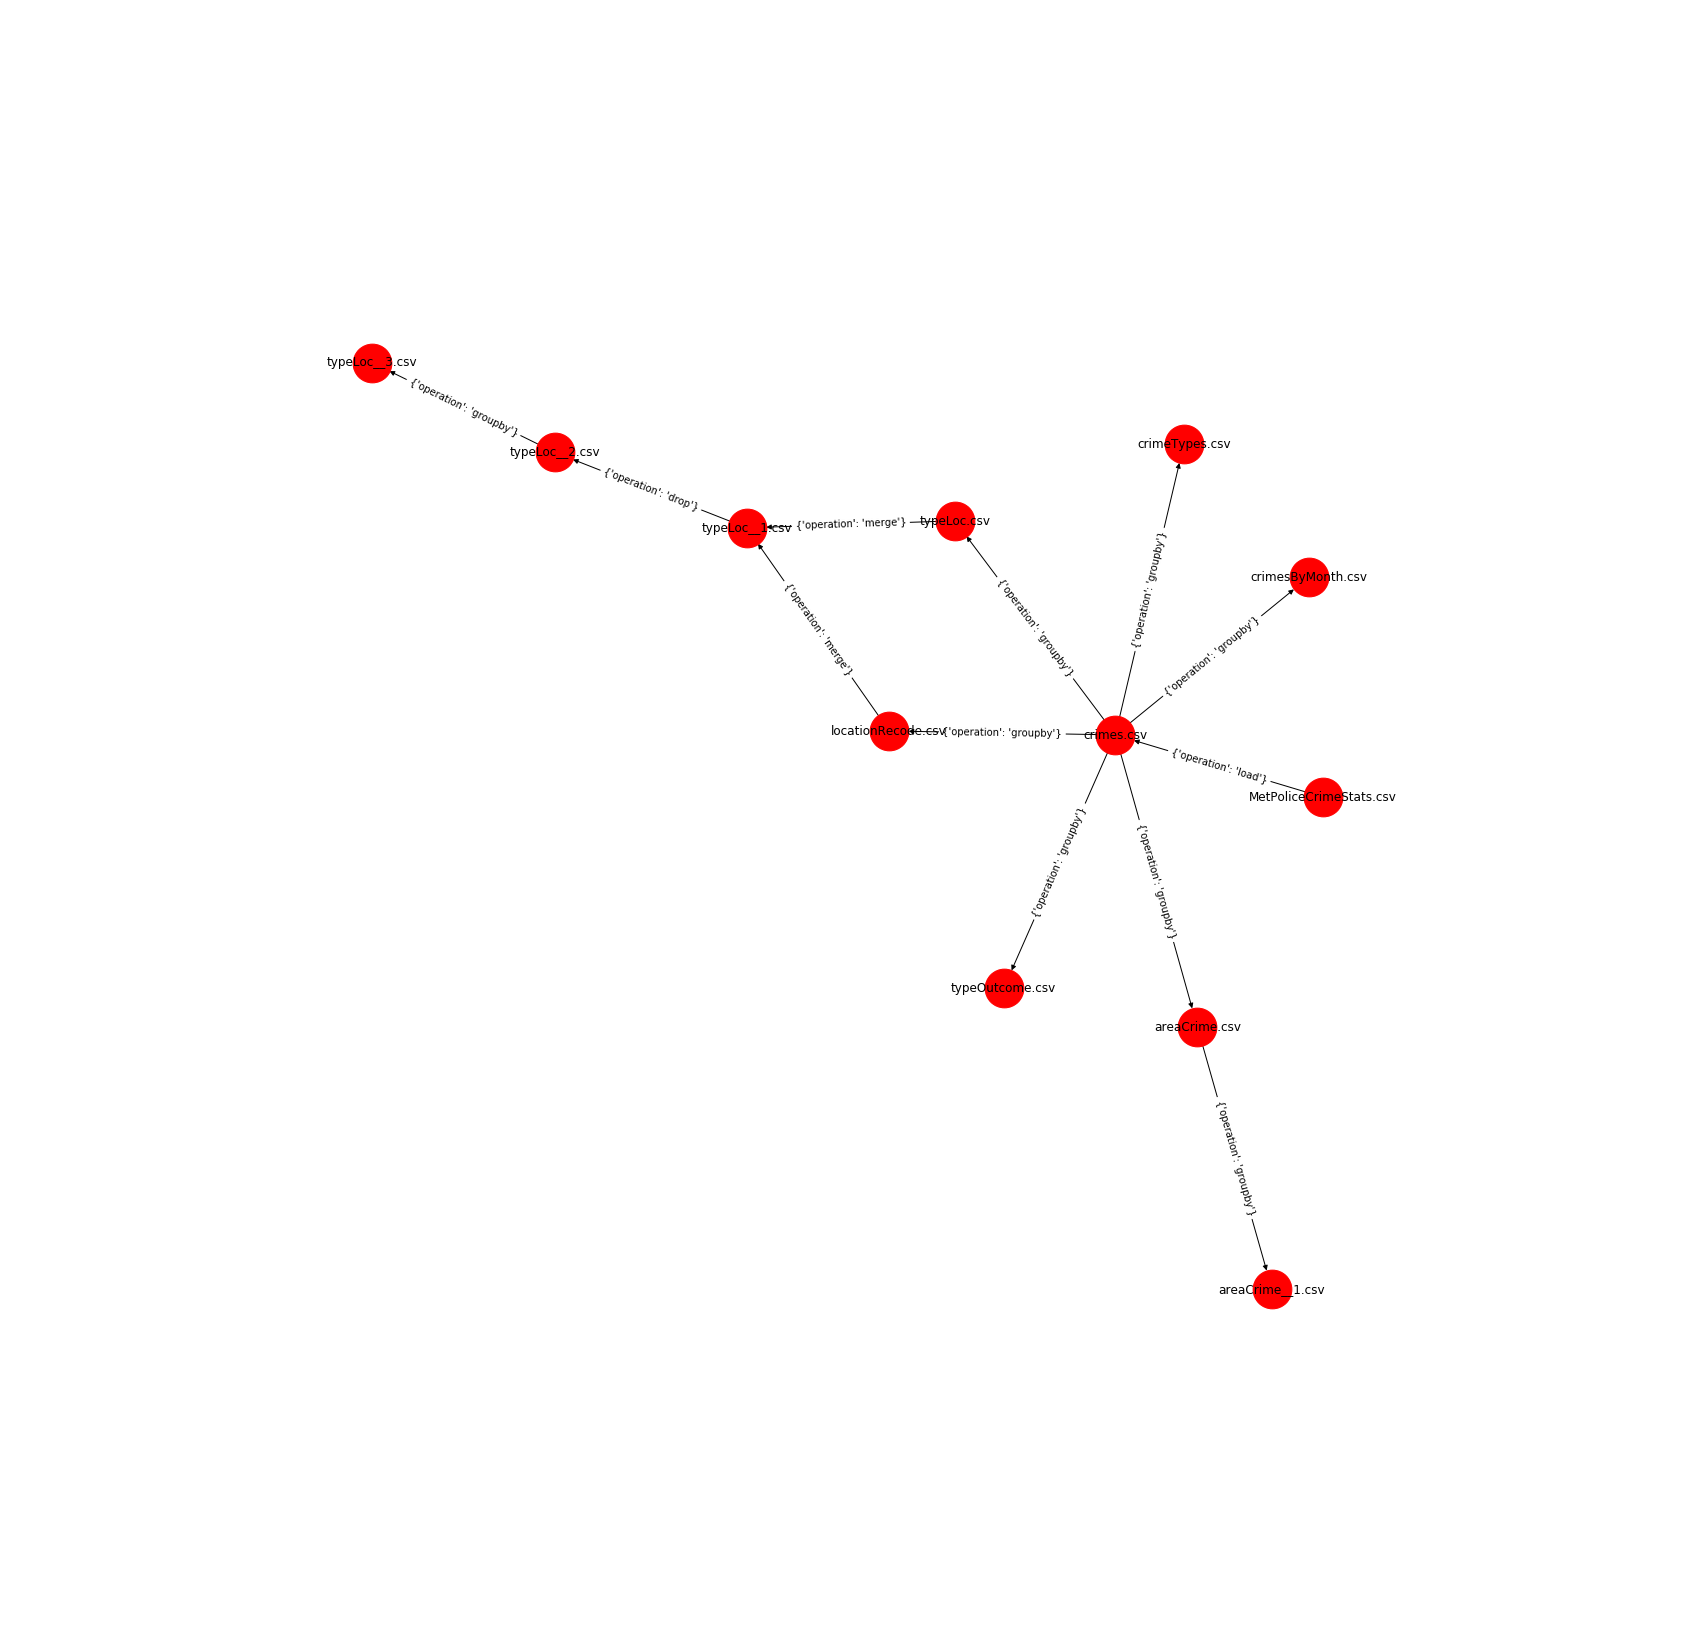

nb_23457.ipynb


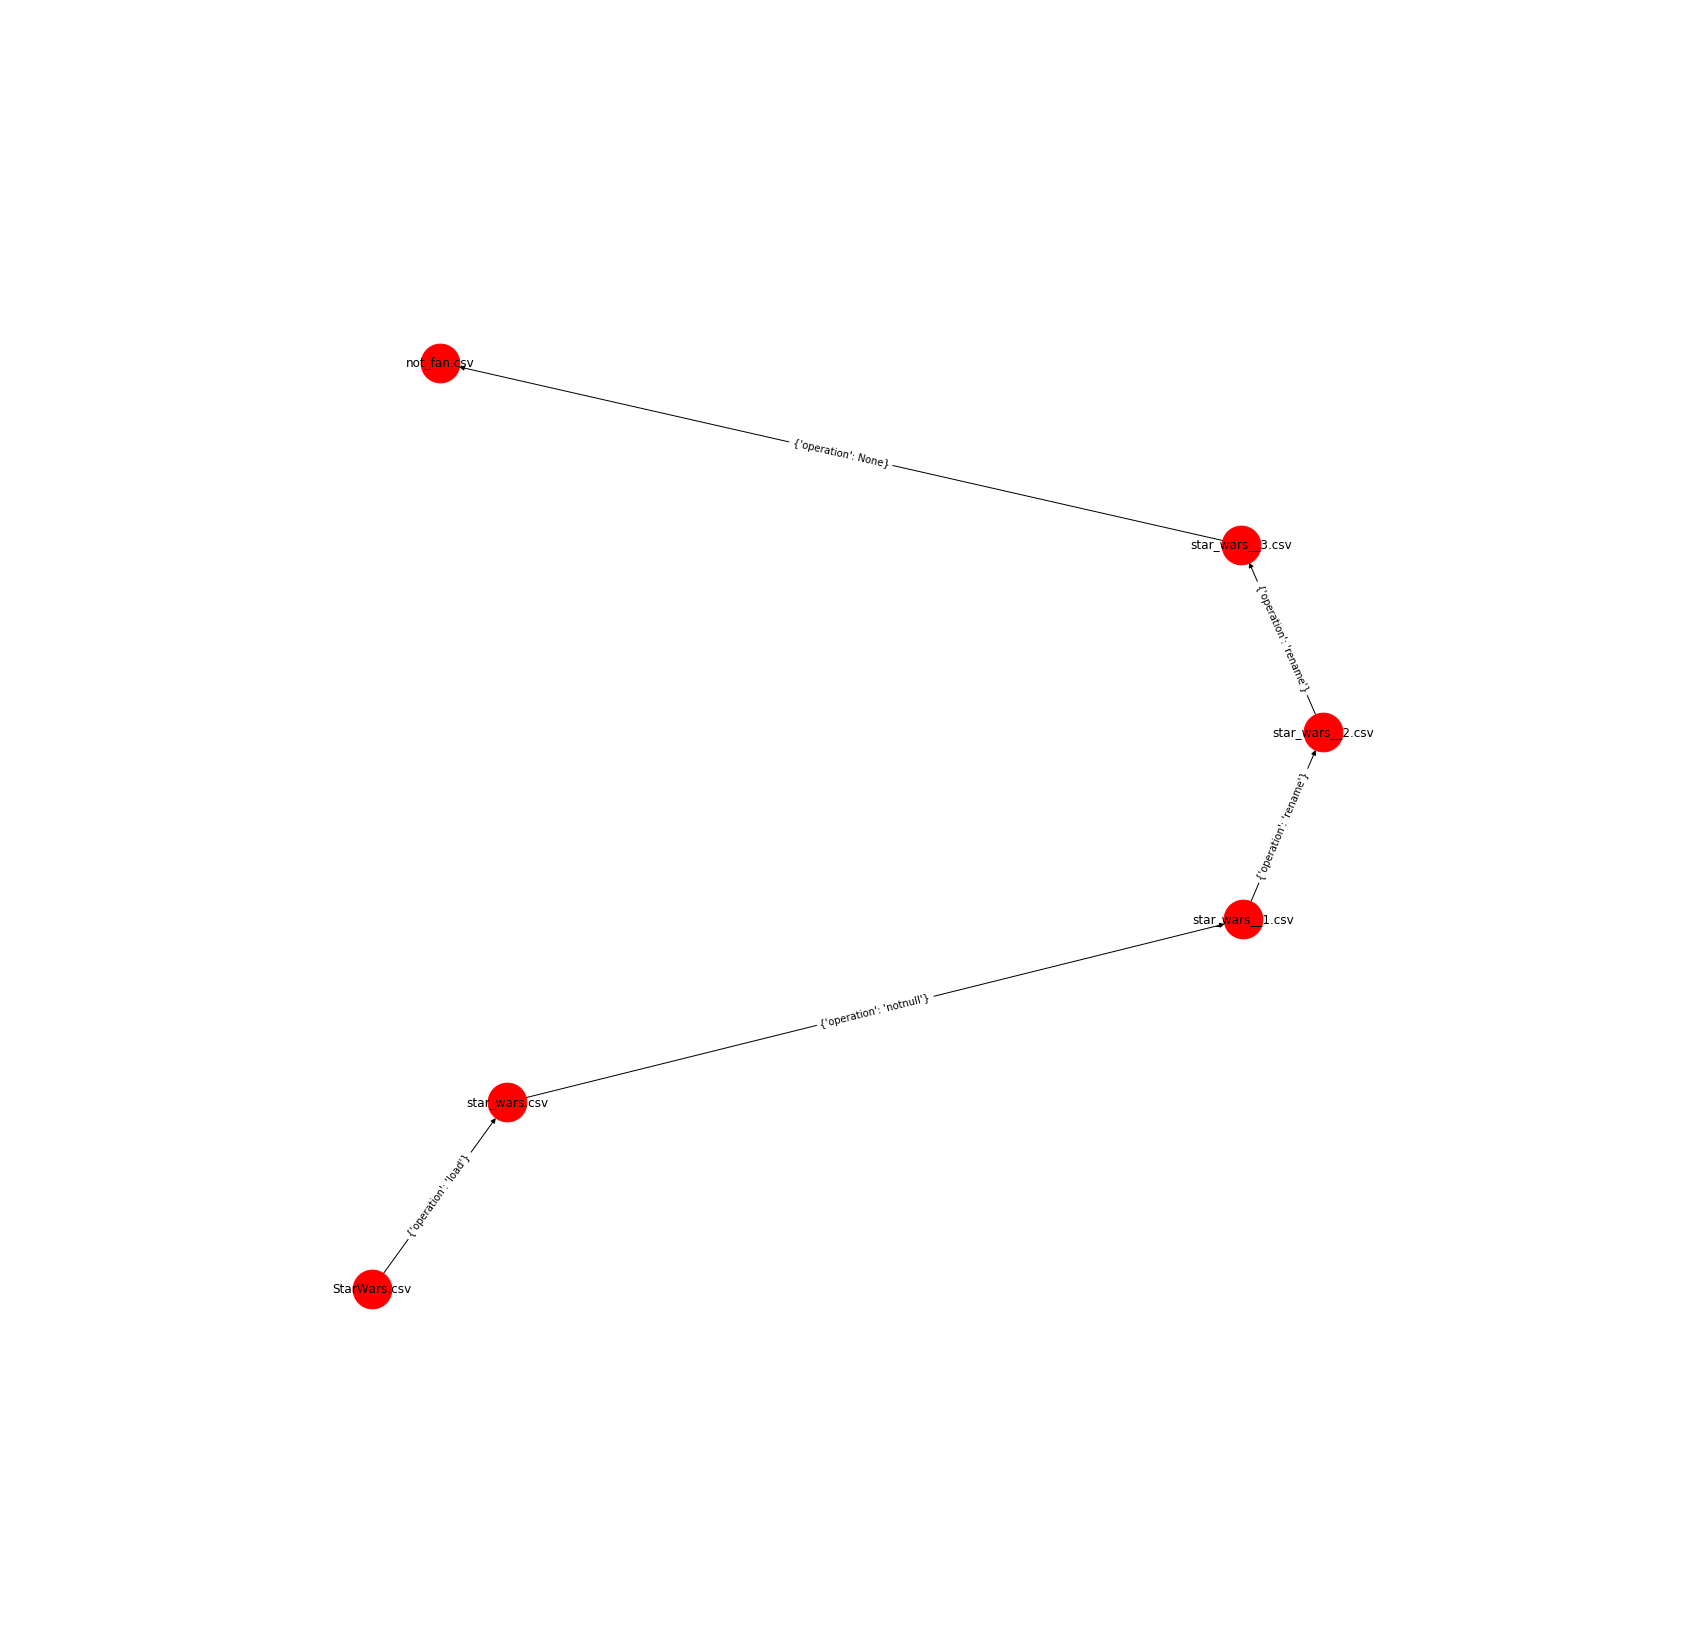

nb_33614.ipynb


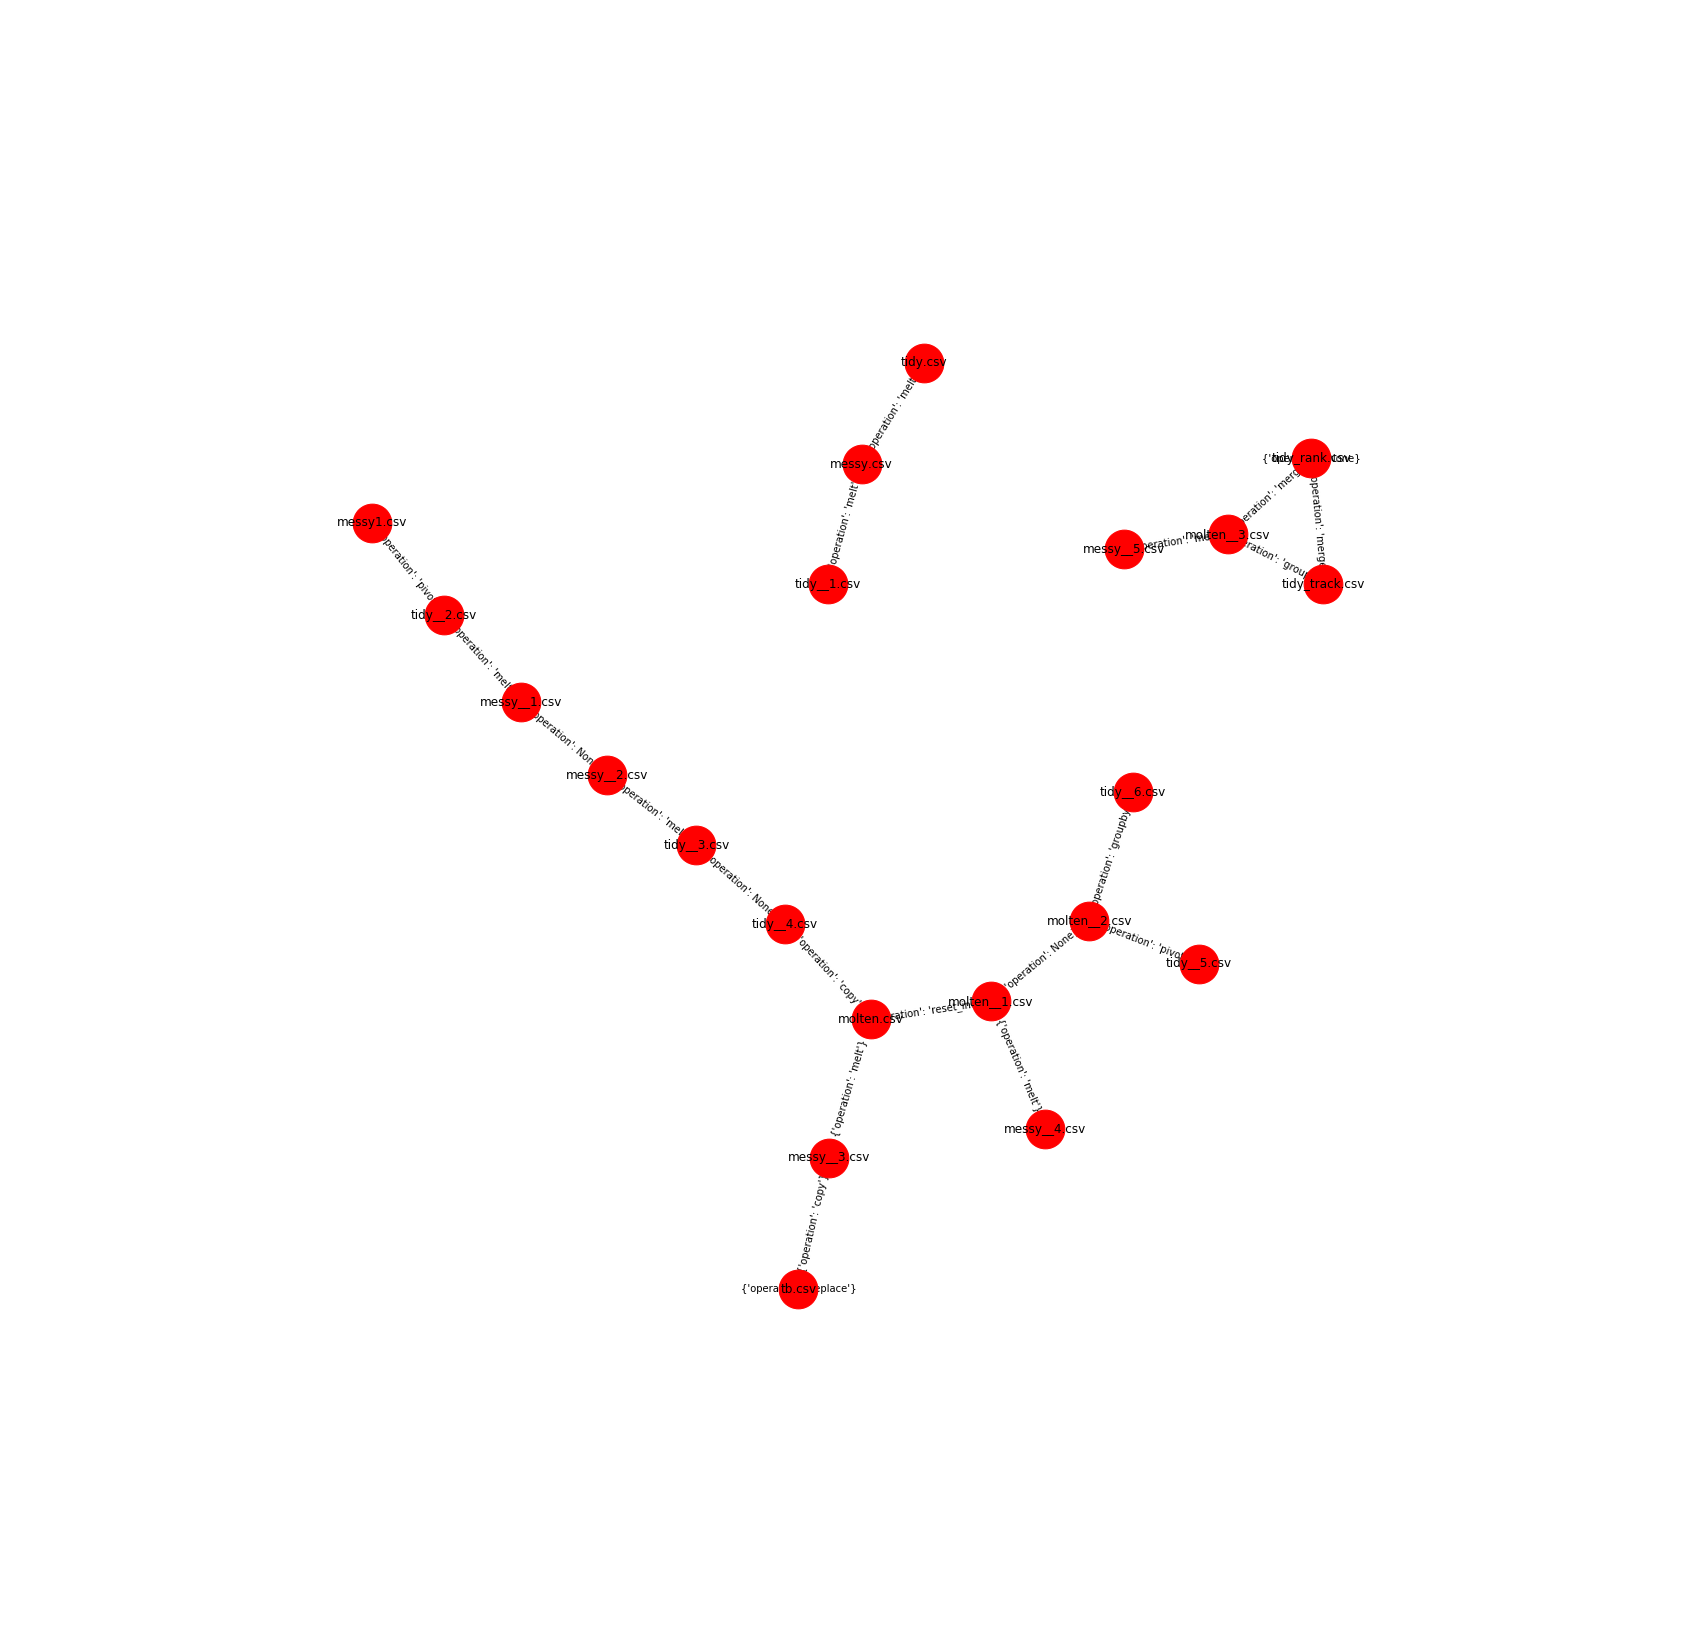

nb_316514.ipynb


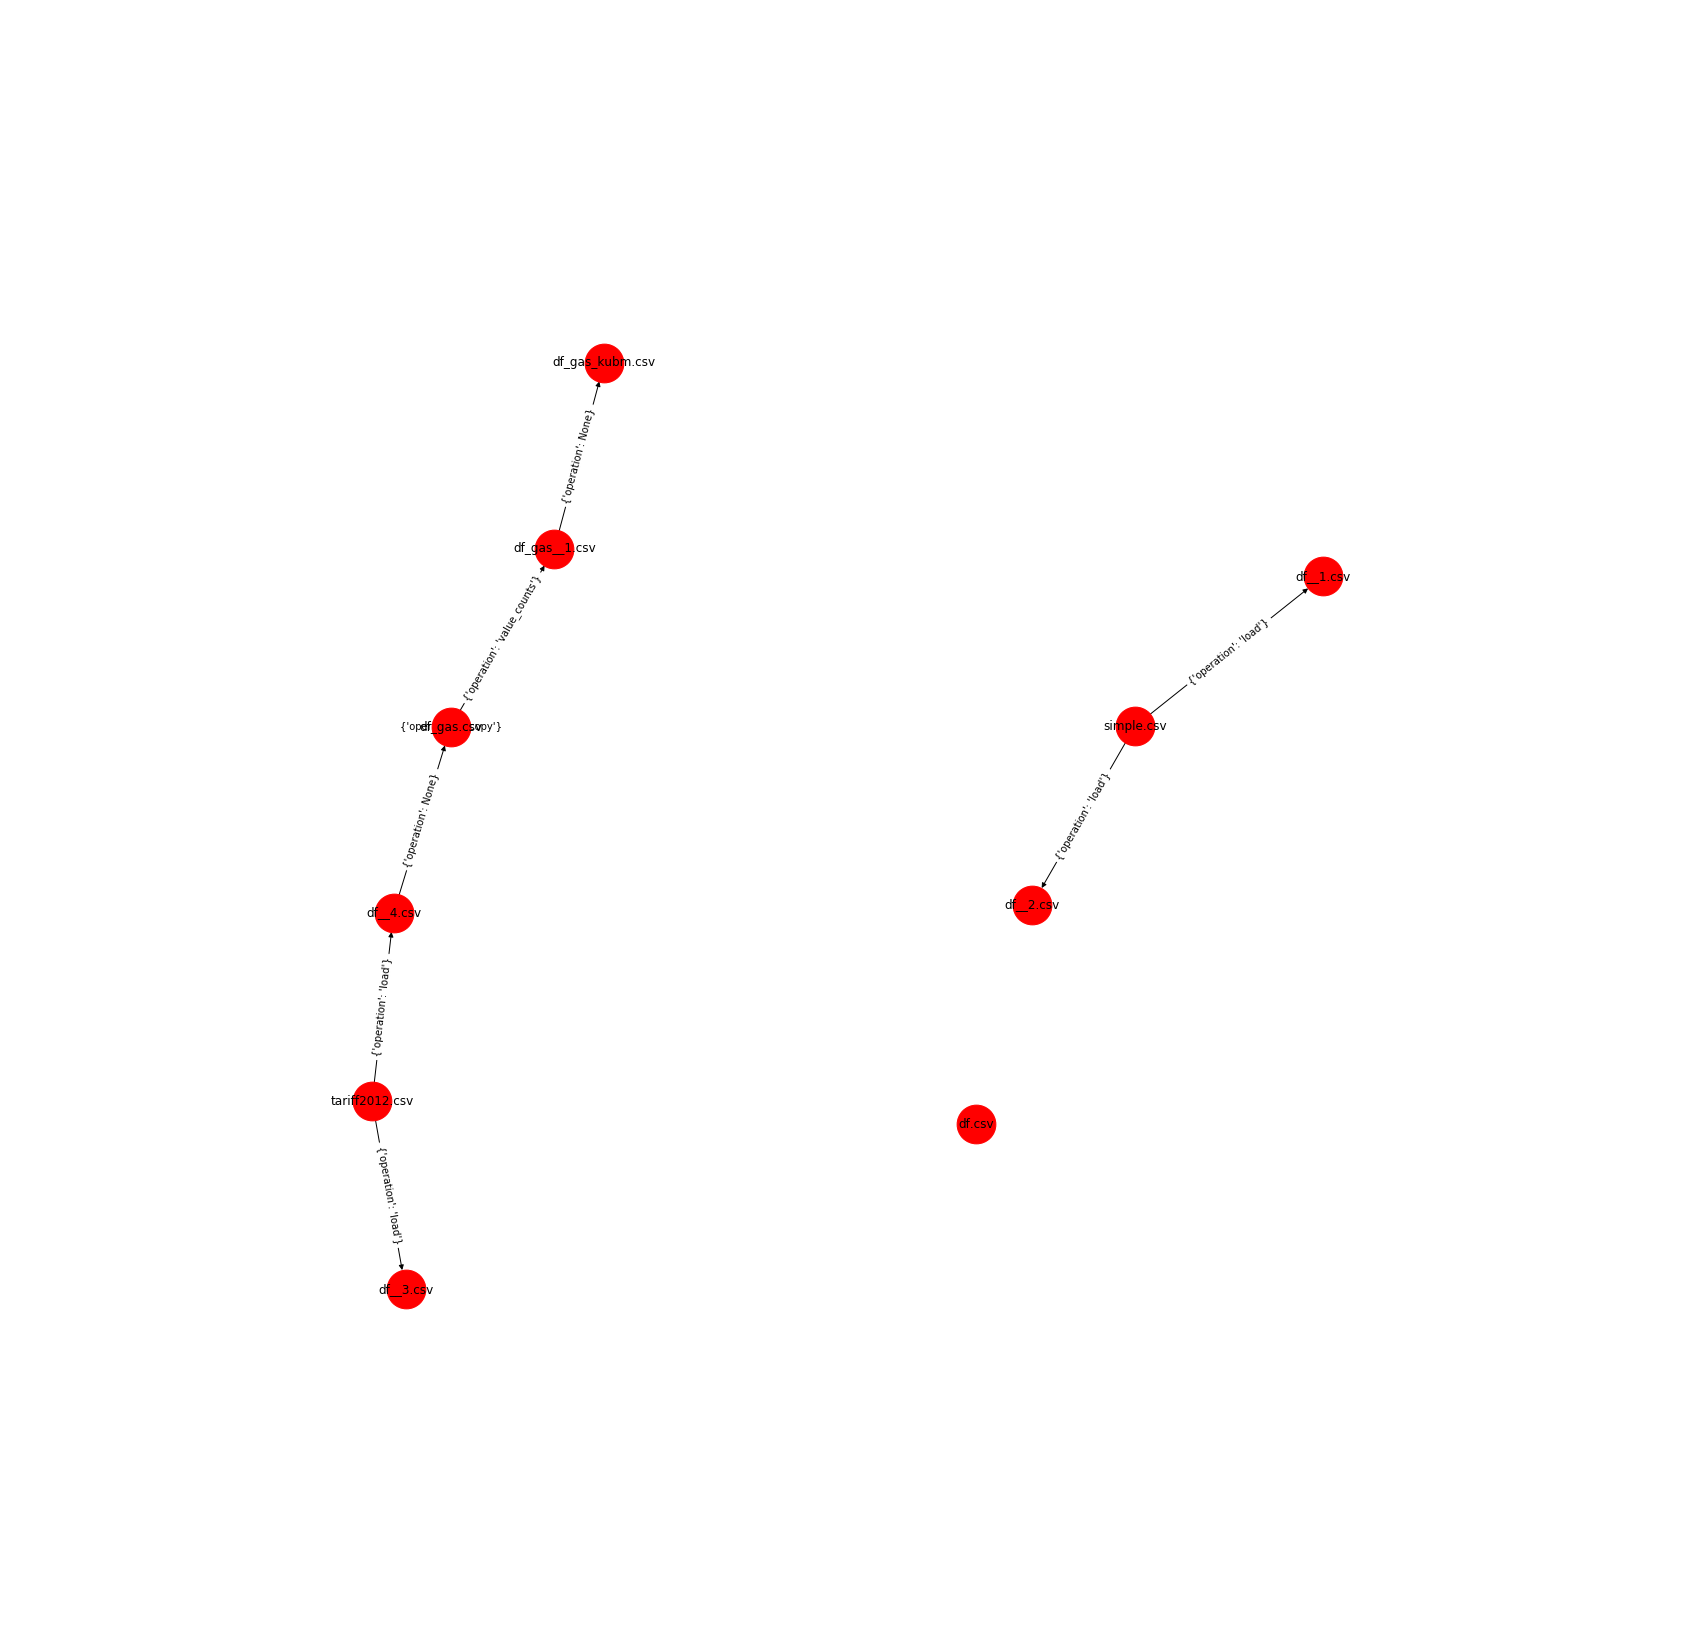

nb_386796.ipynb


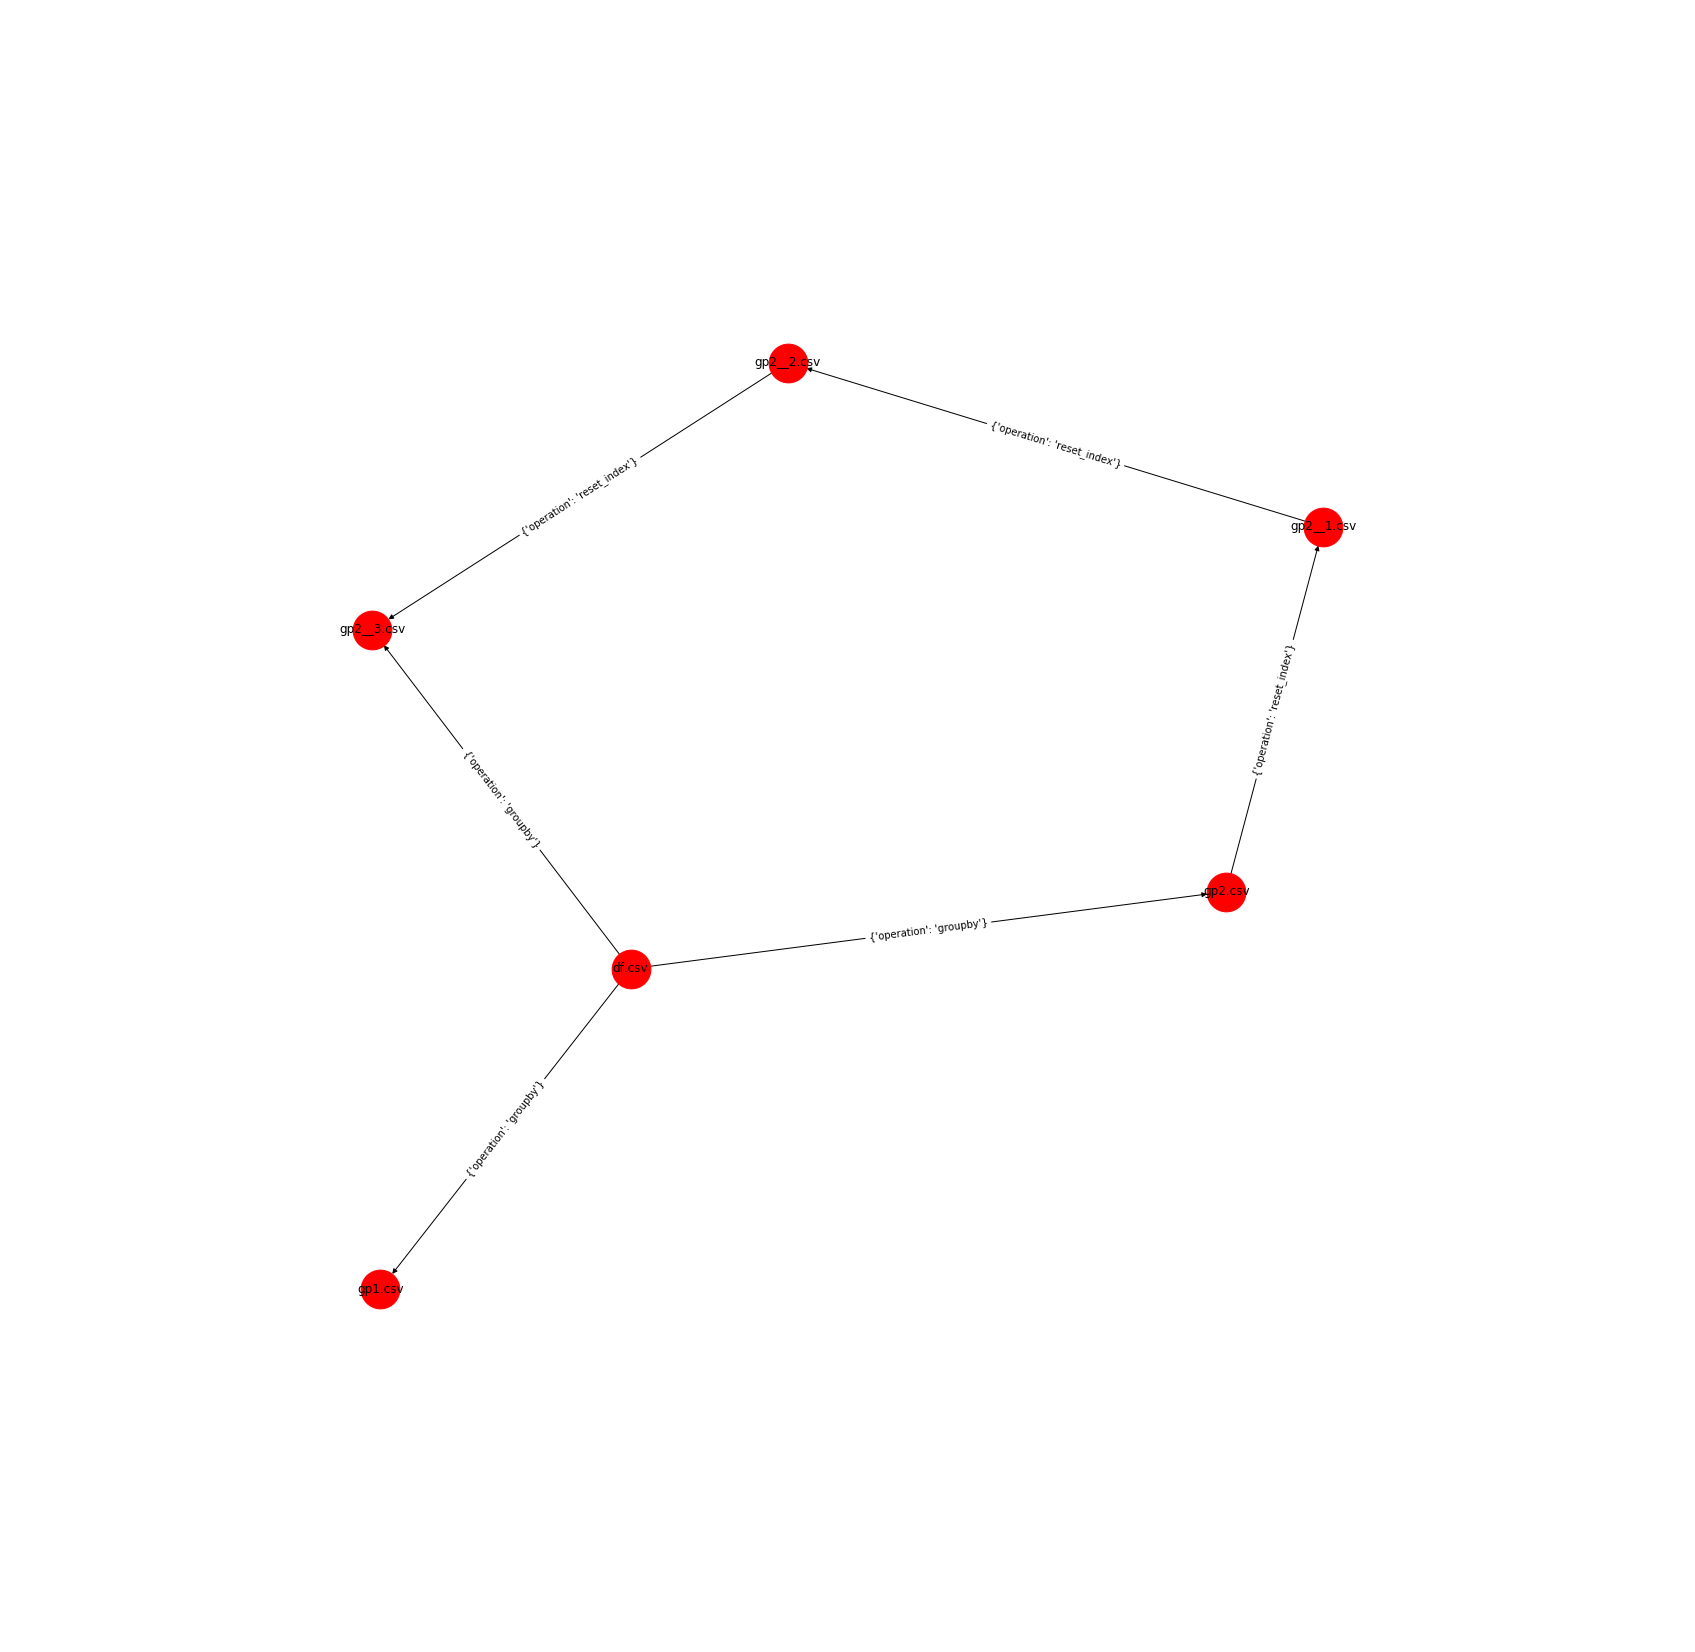

nb_266913.ipynb


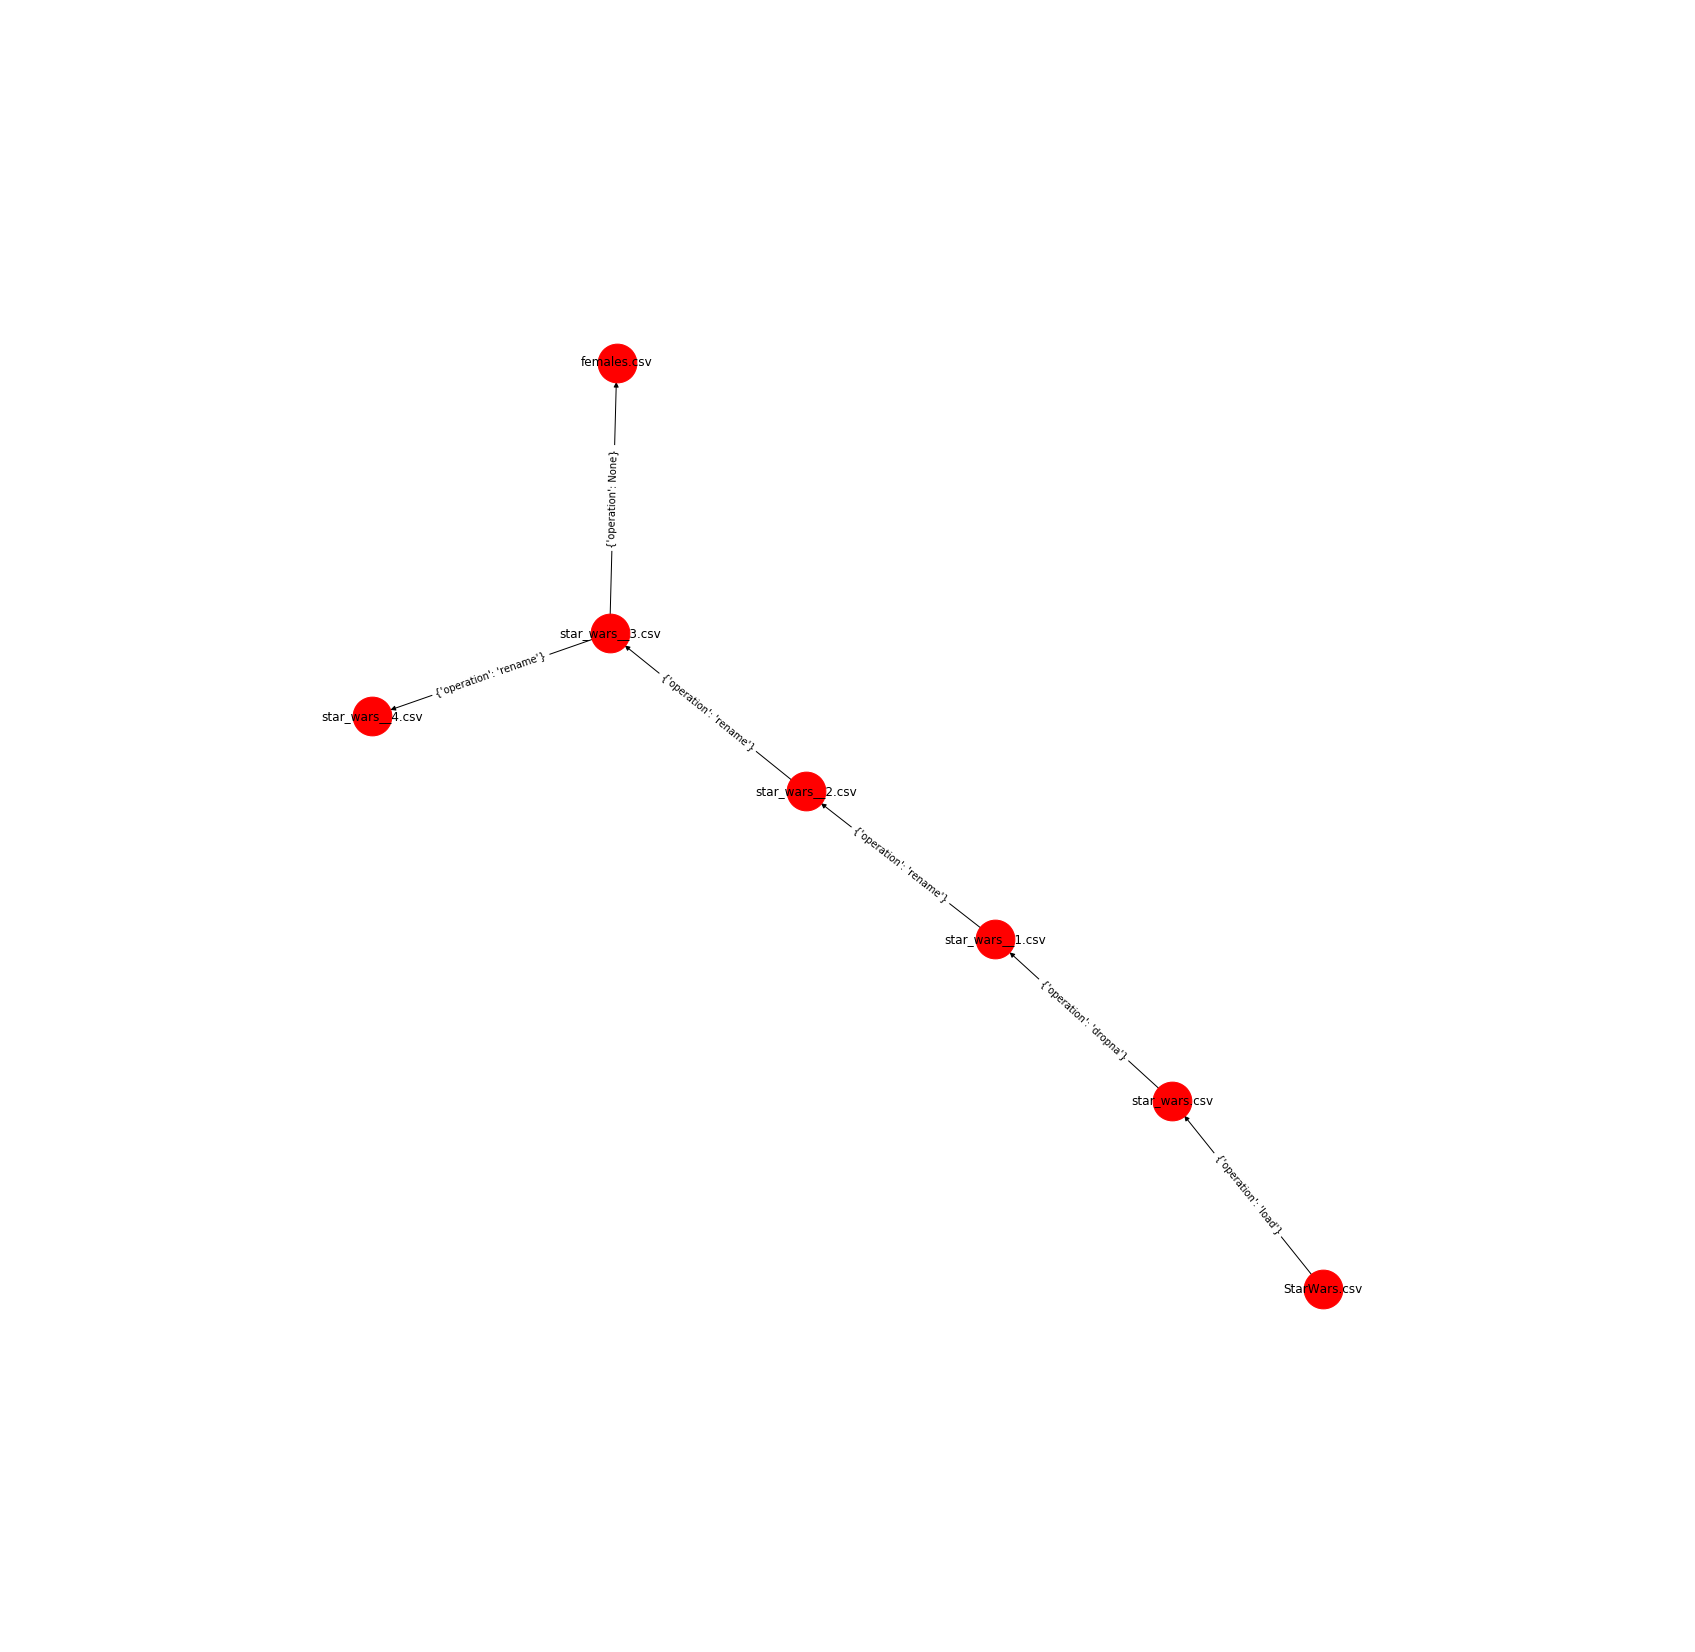

nb_417011.ipynb


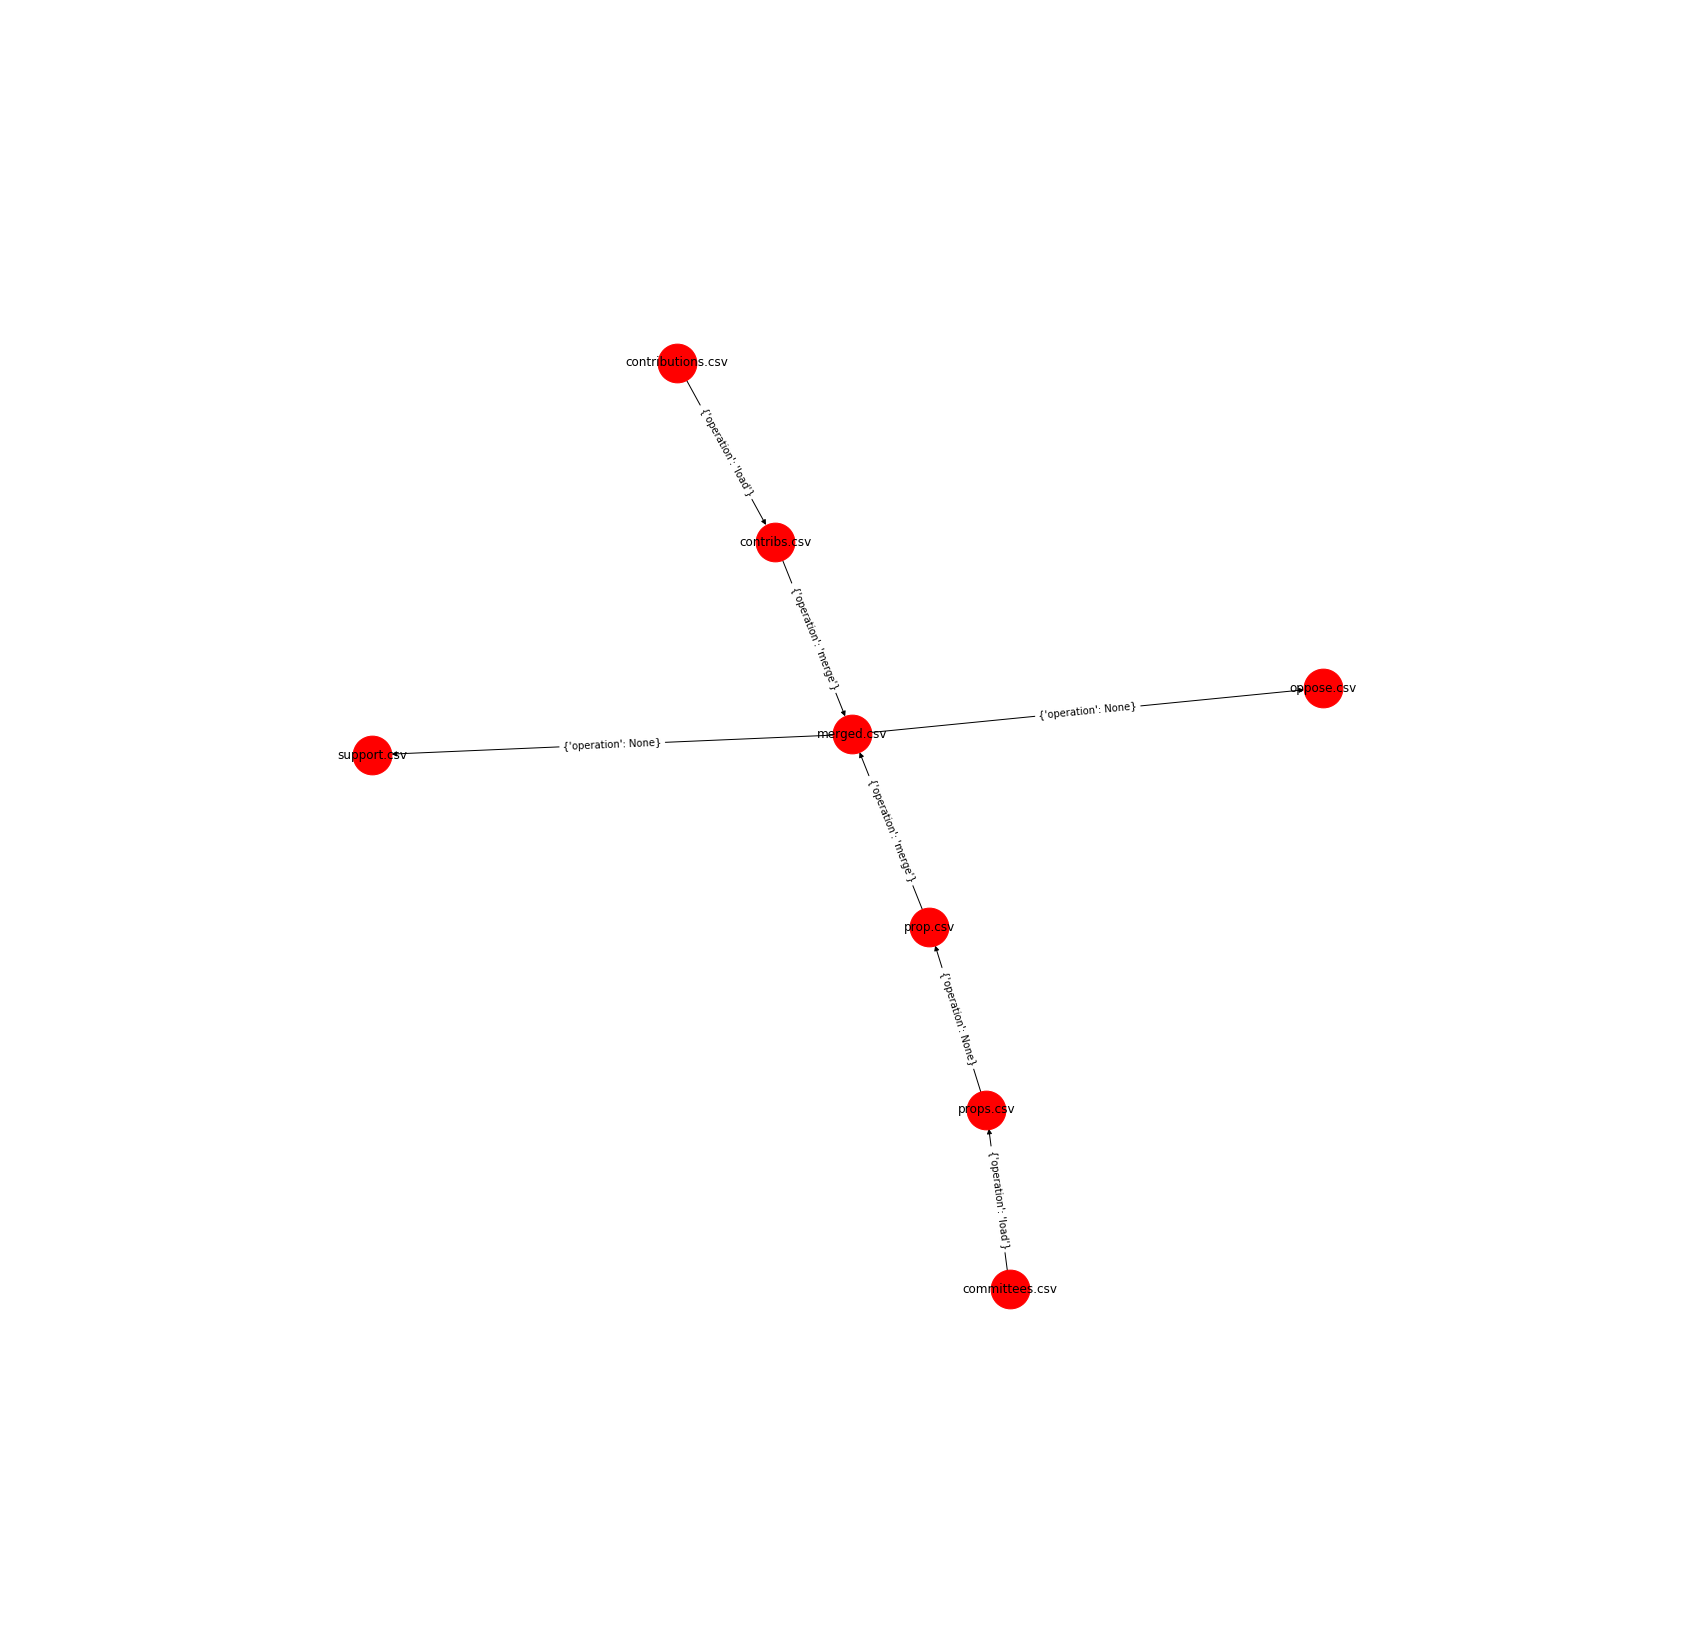

nb_269991.ipynb


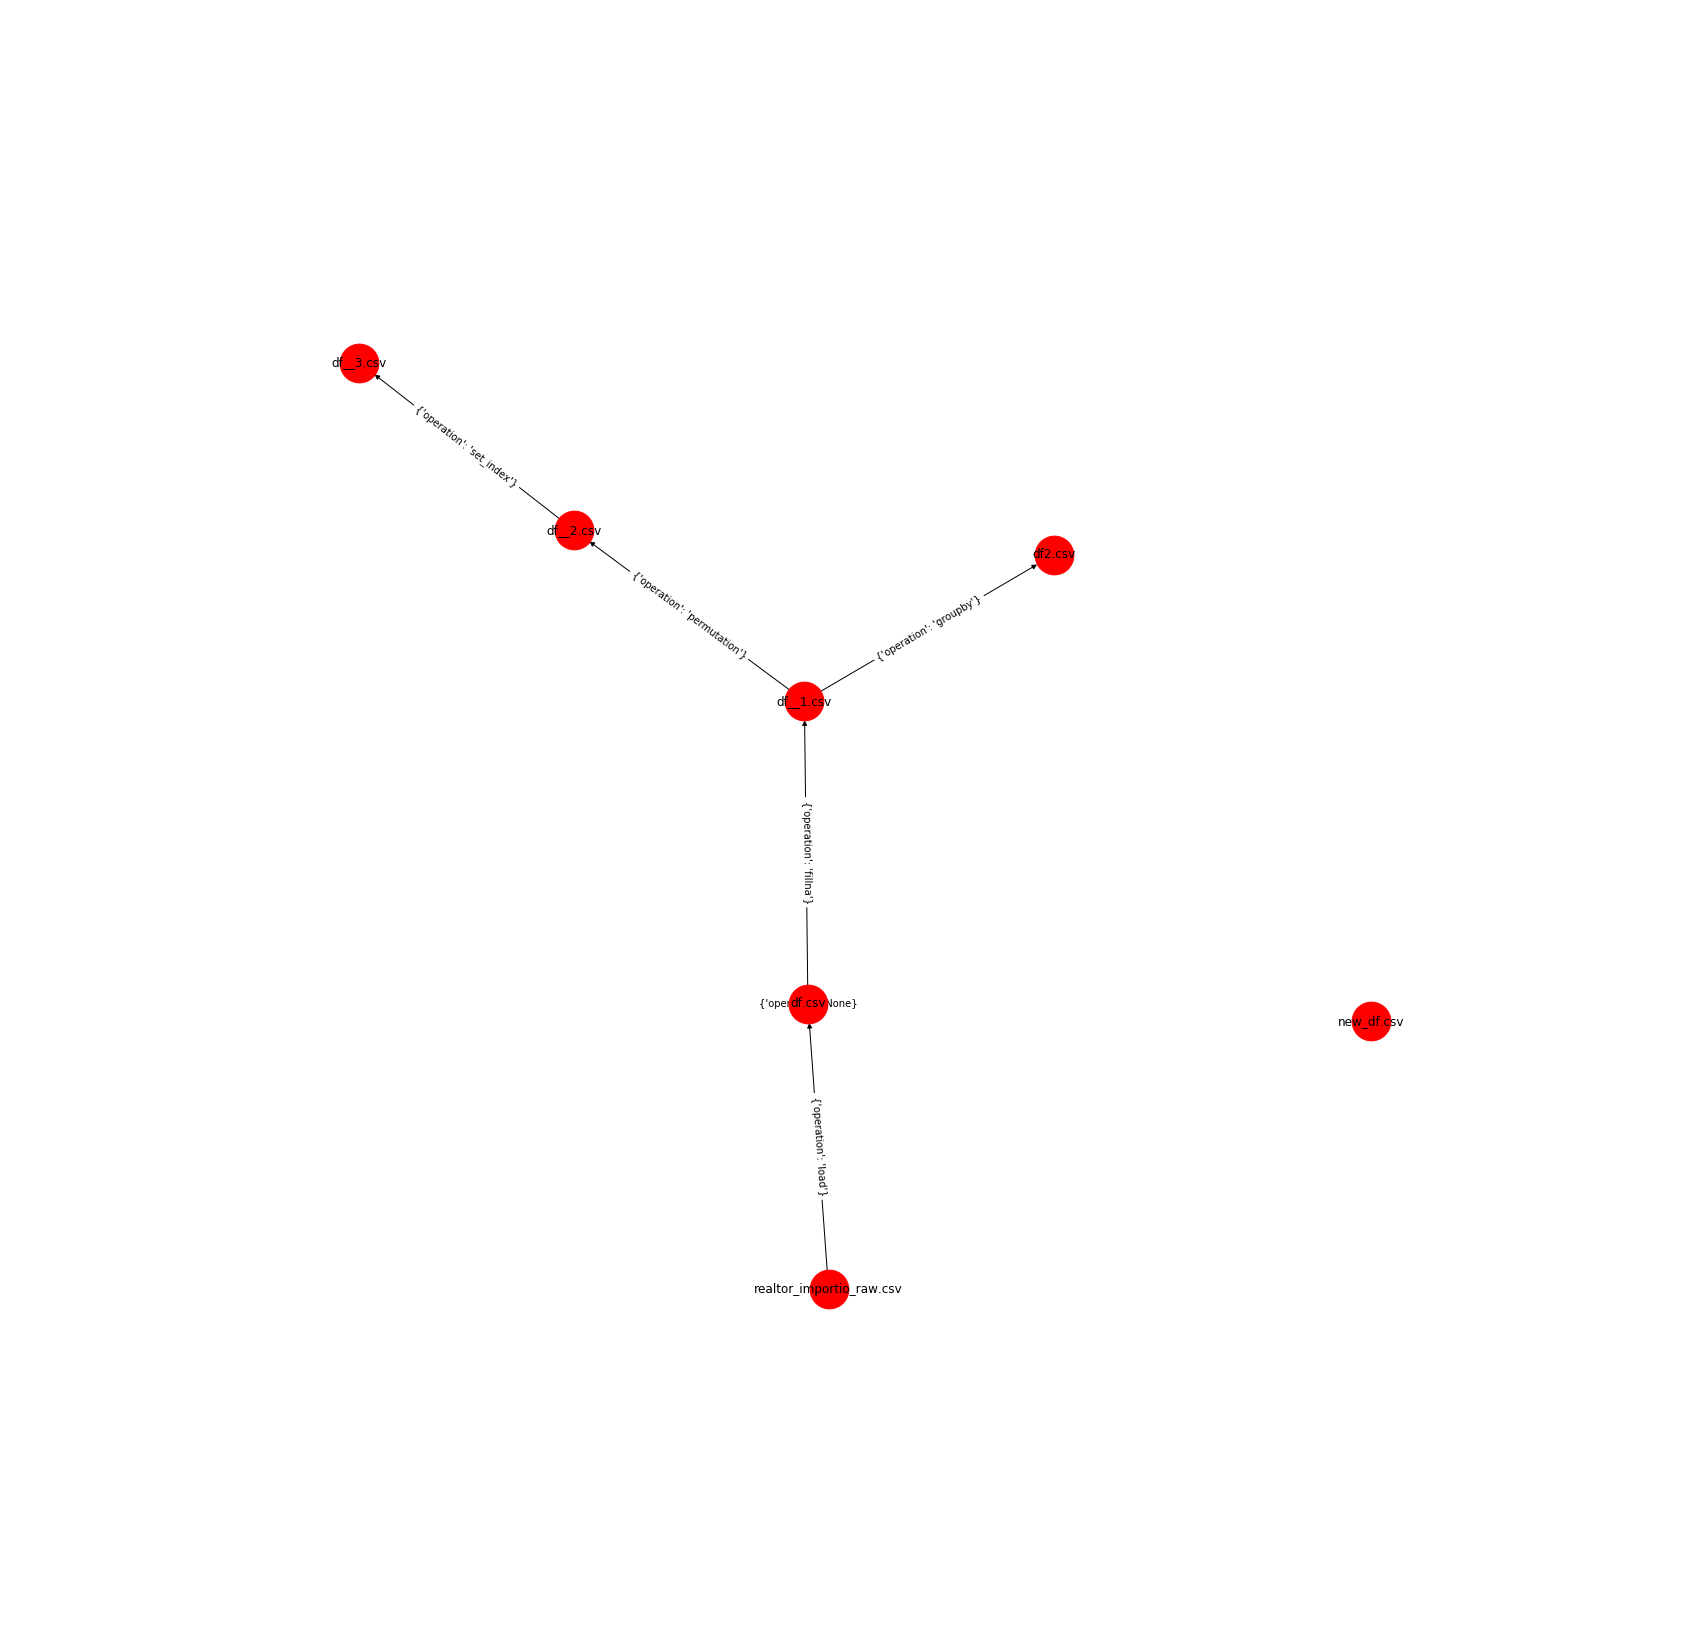

nb_495072.ipynb


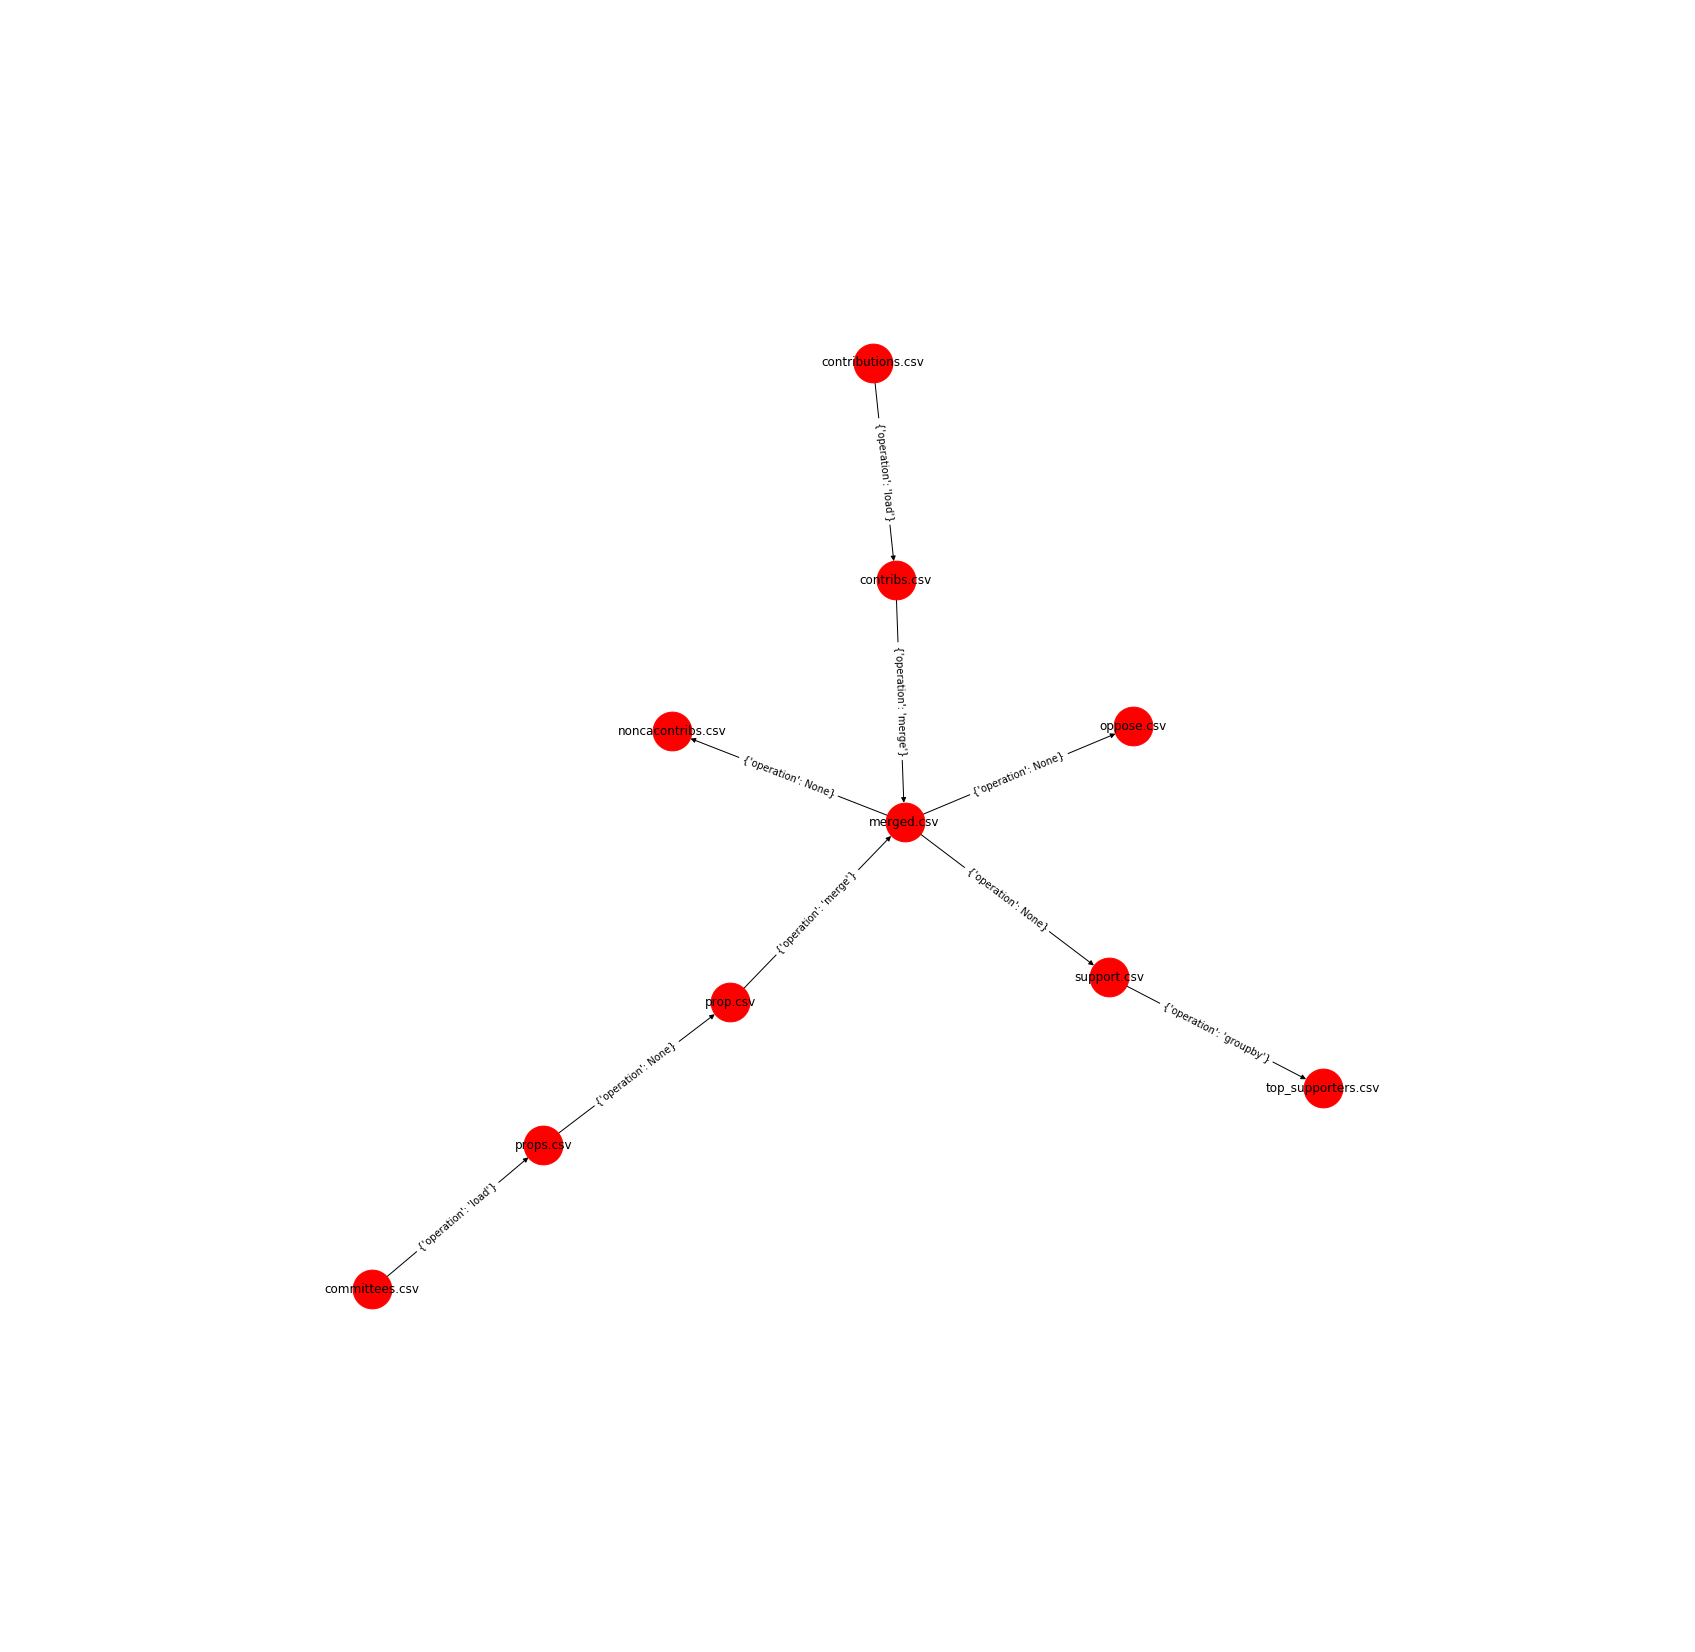

nb_315236.ipynb


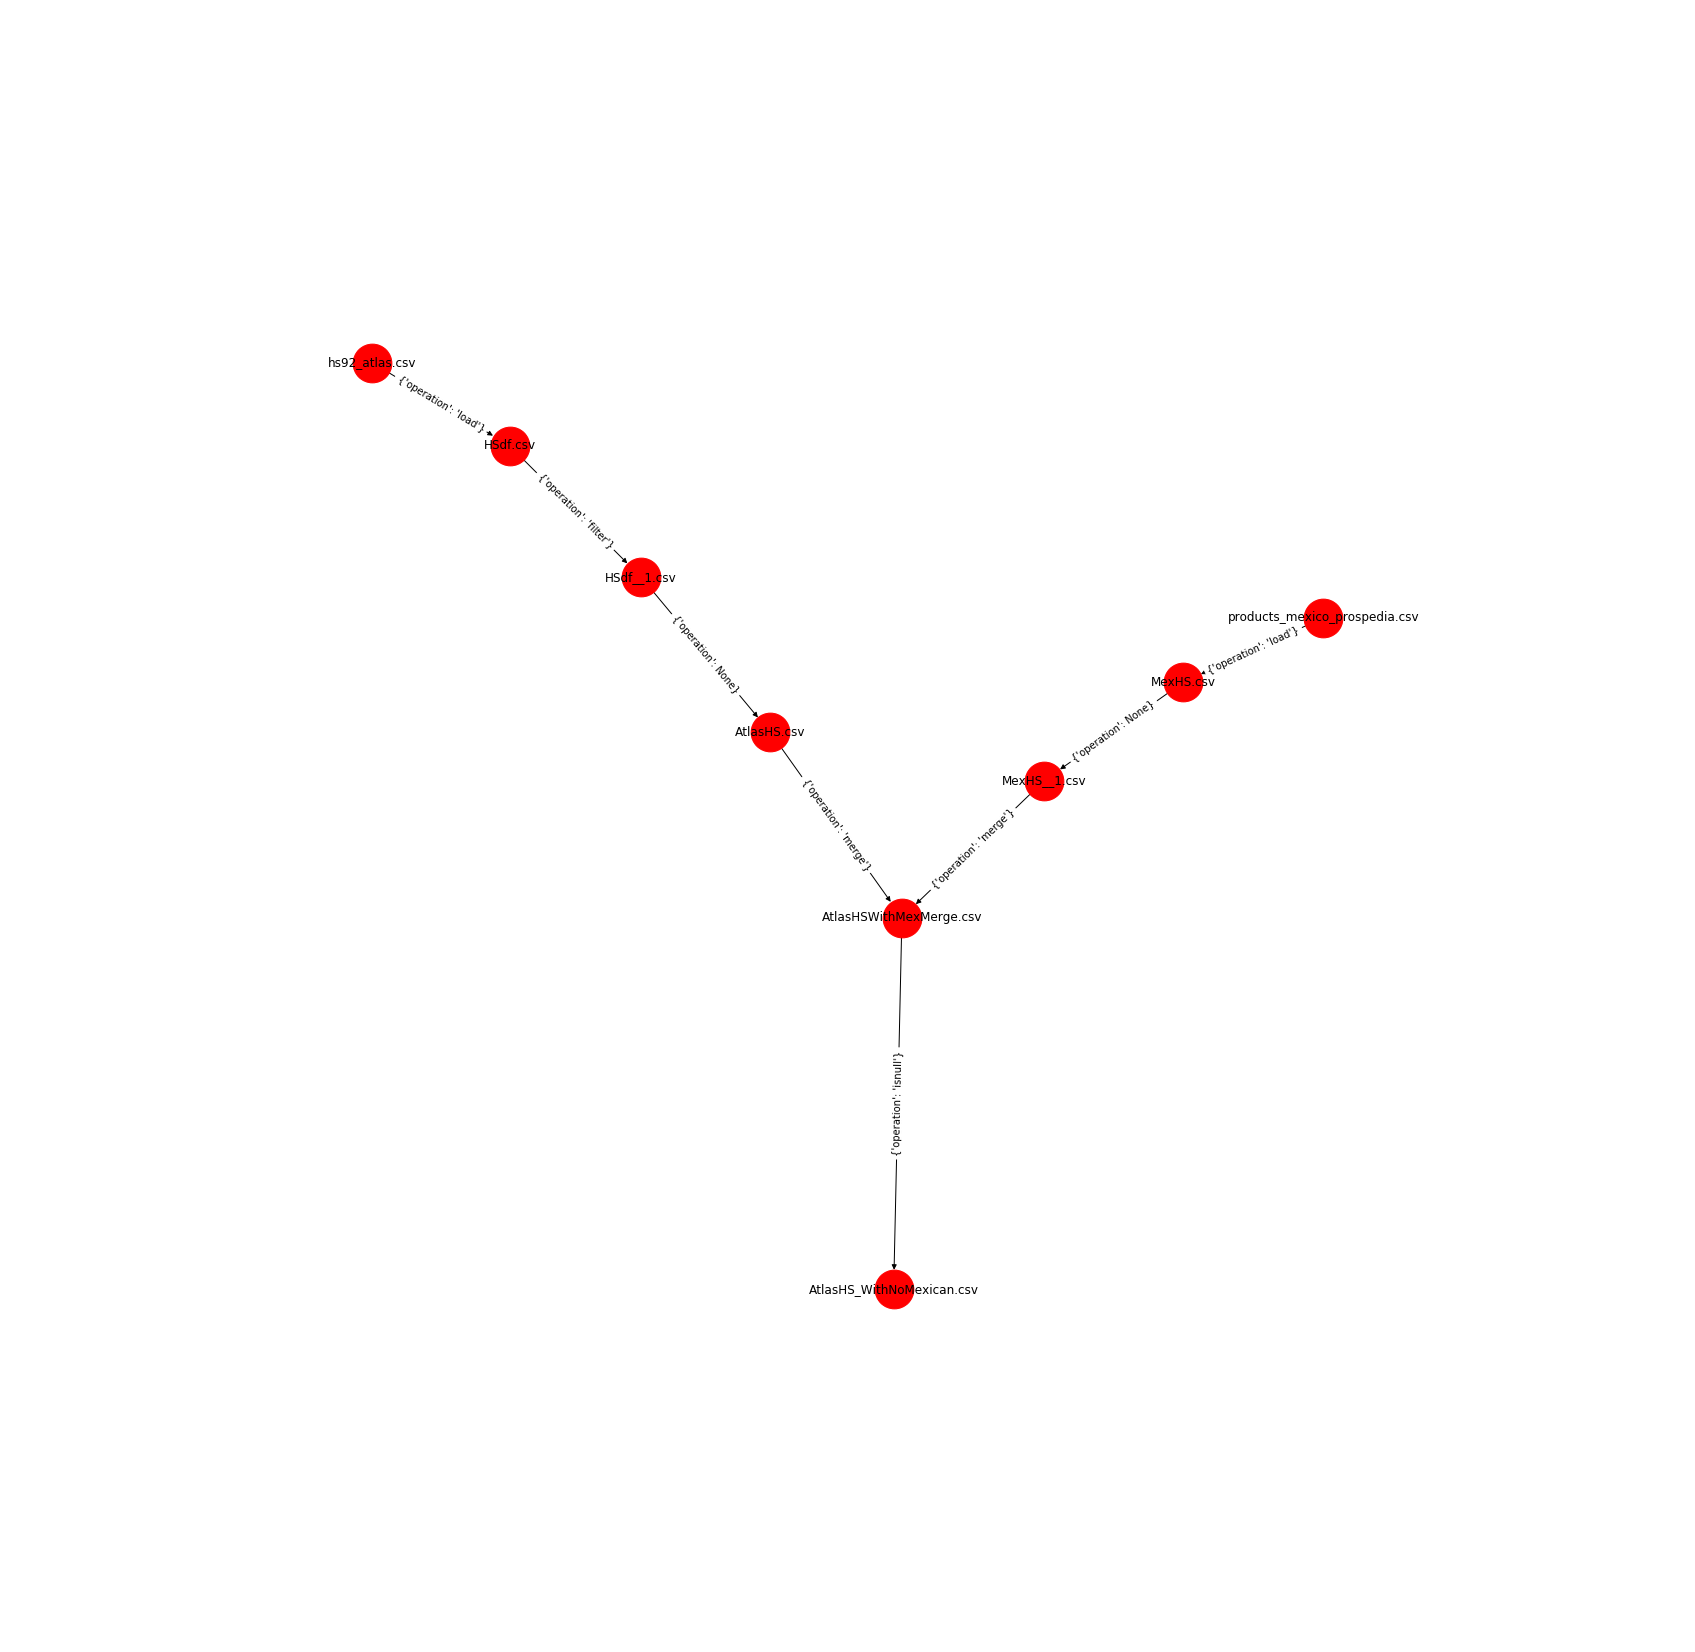

nb_484354.ipynb


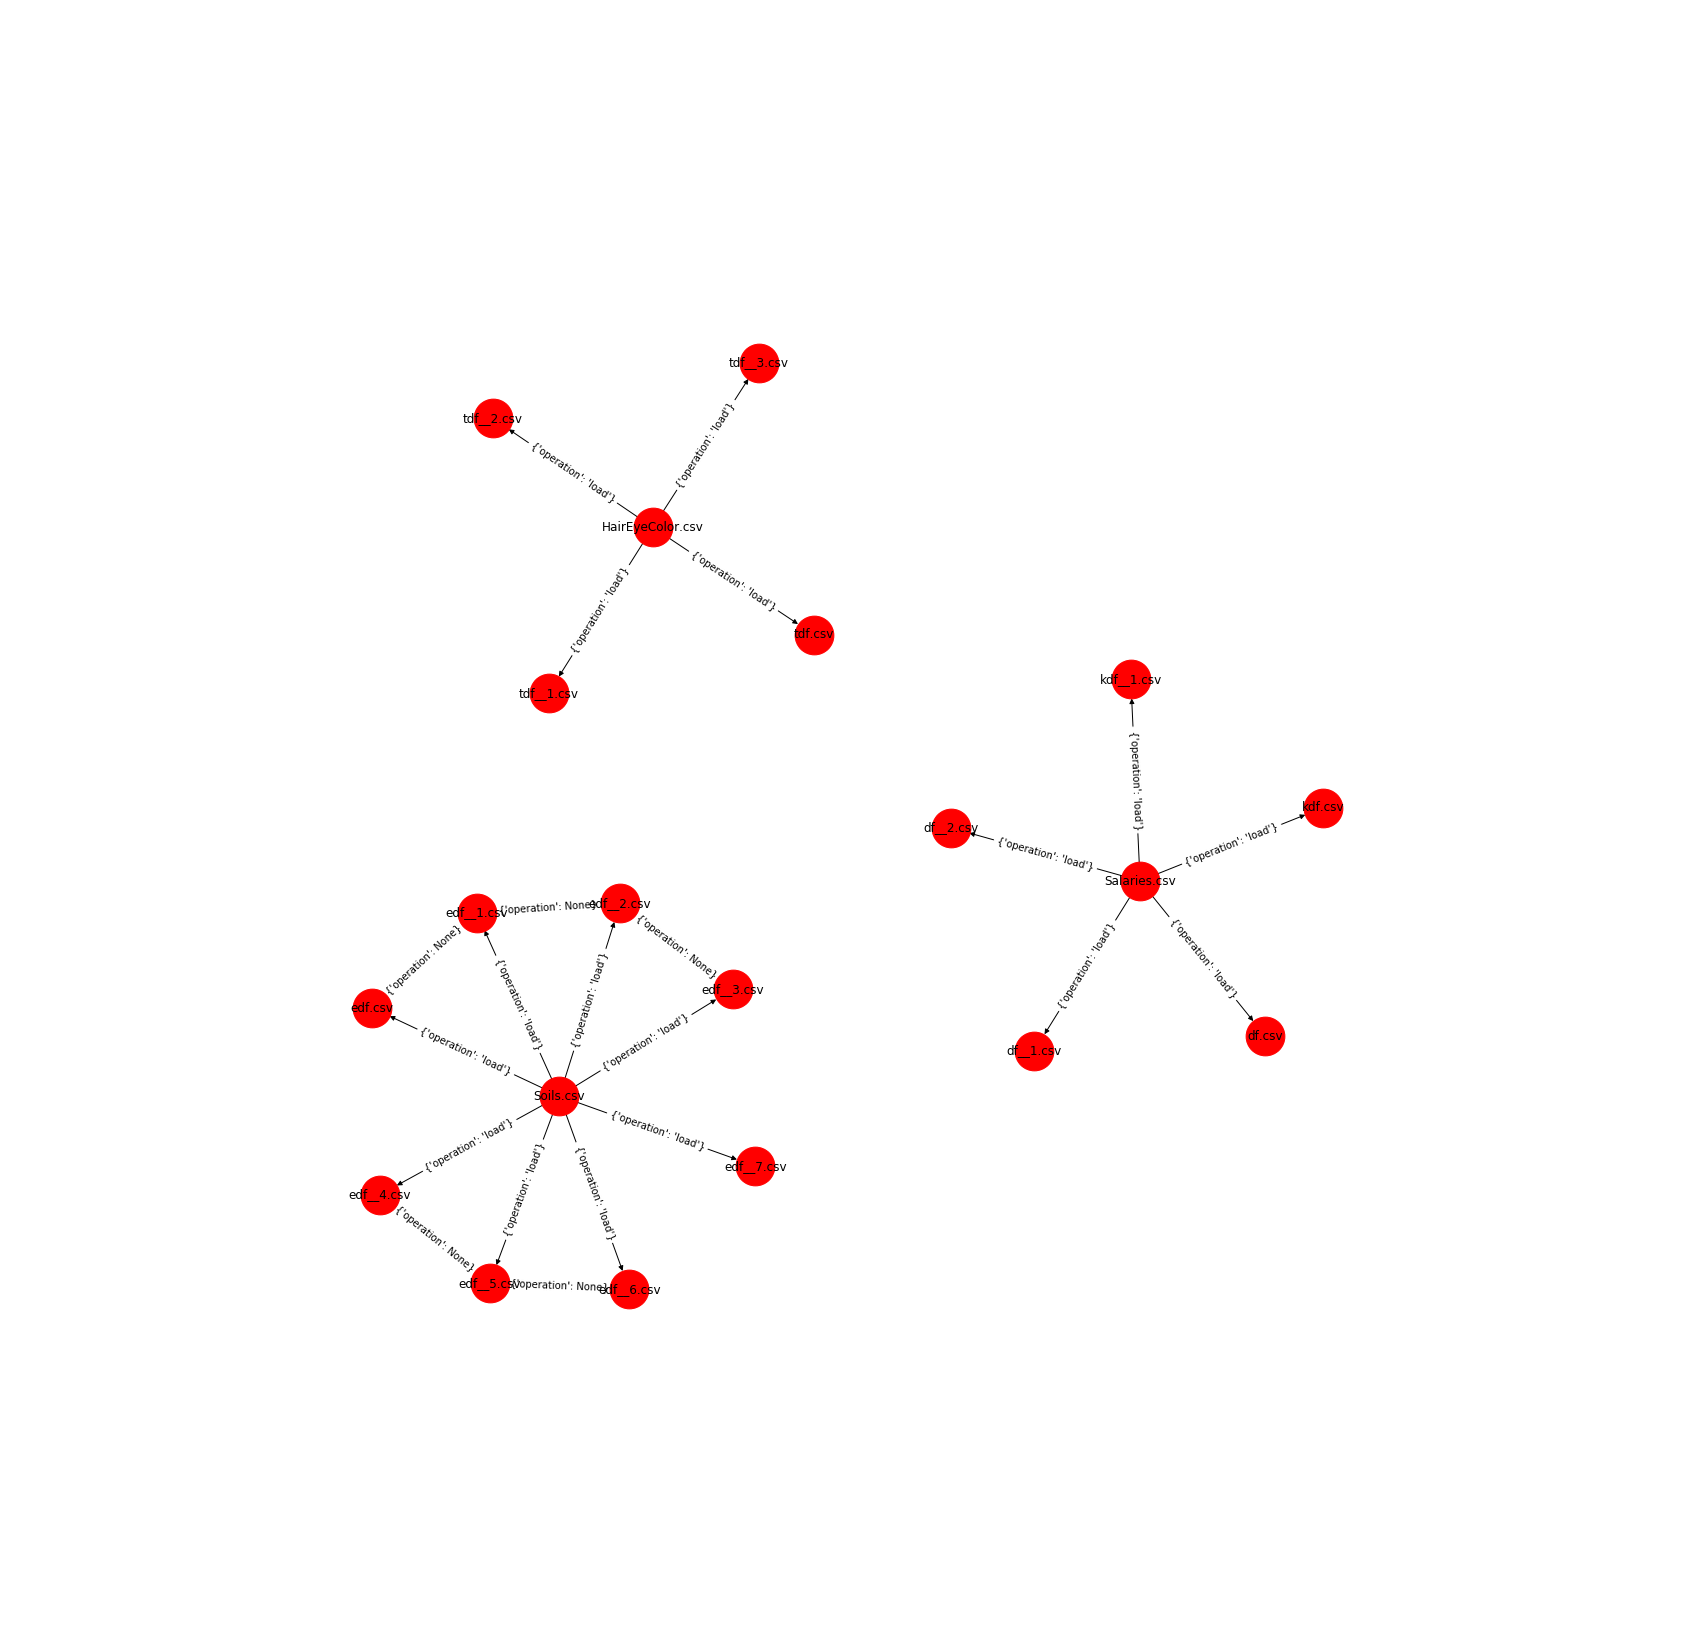

nb_772851.ipynb


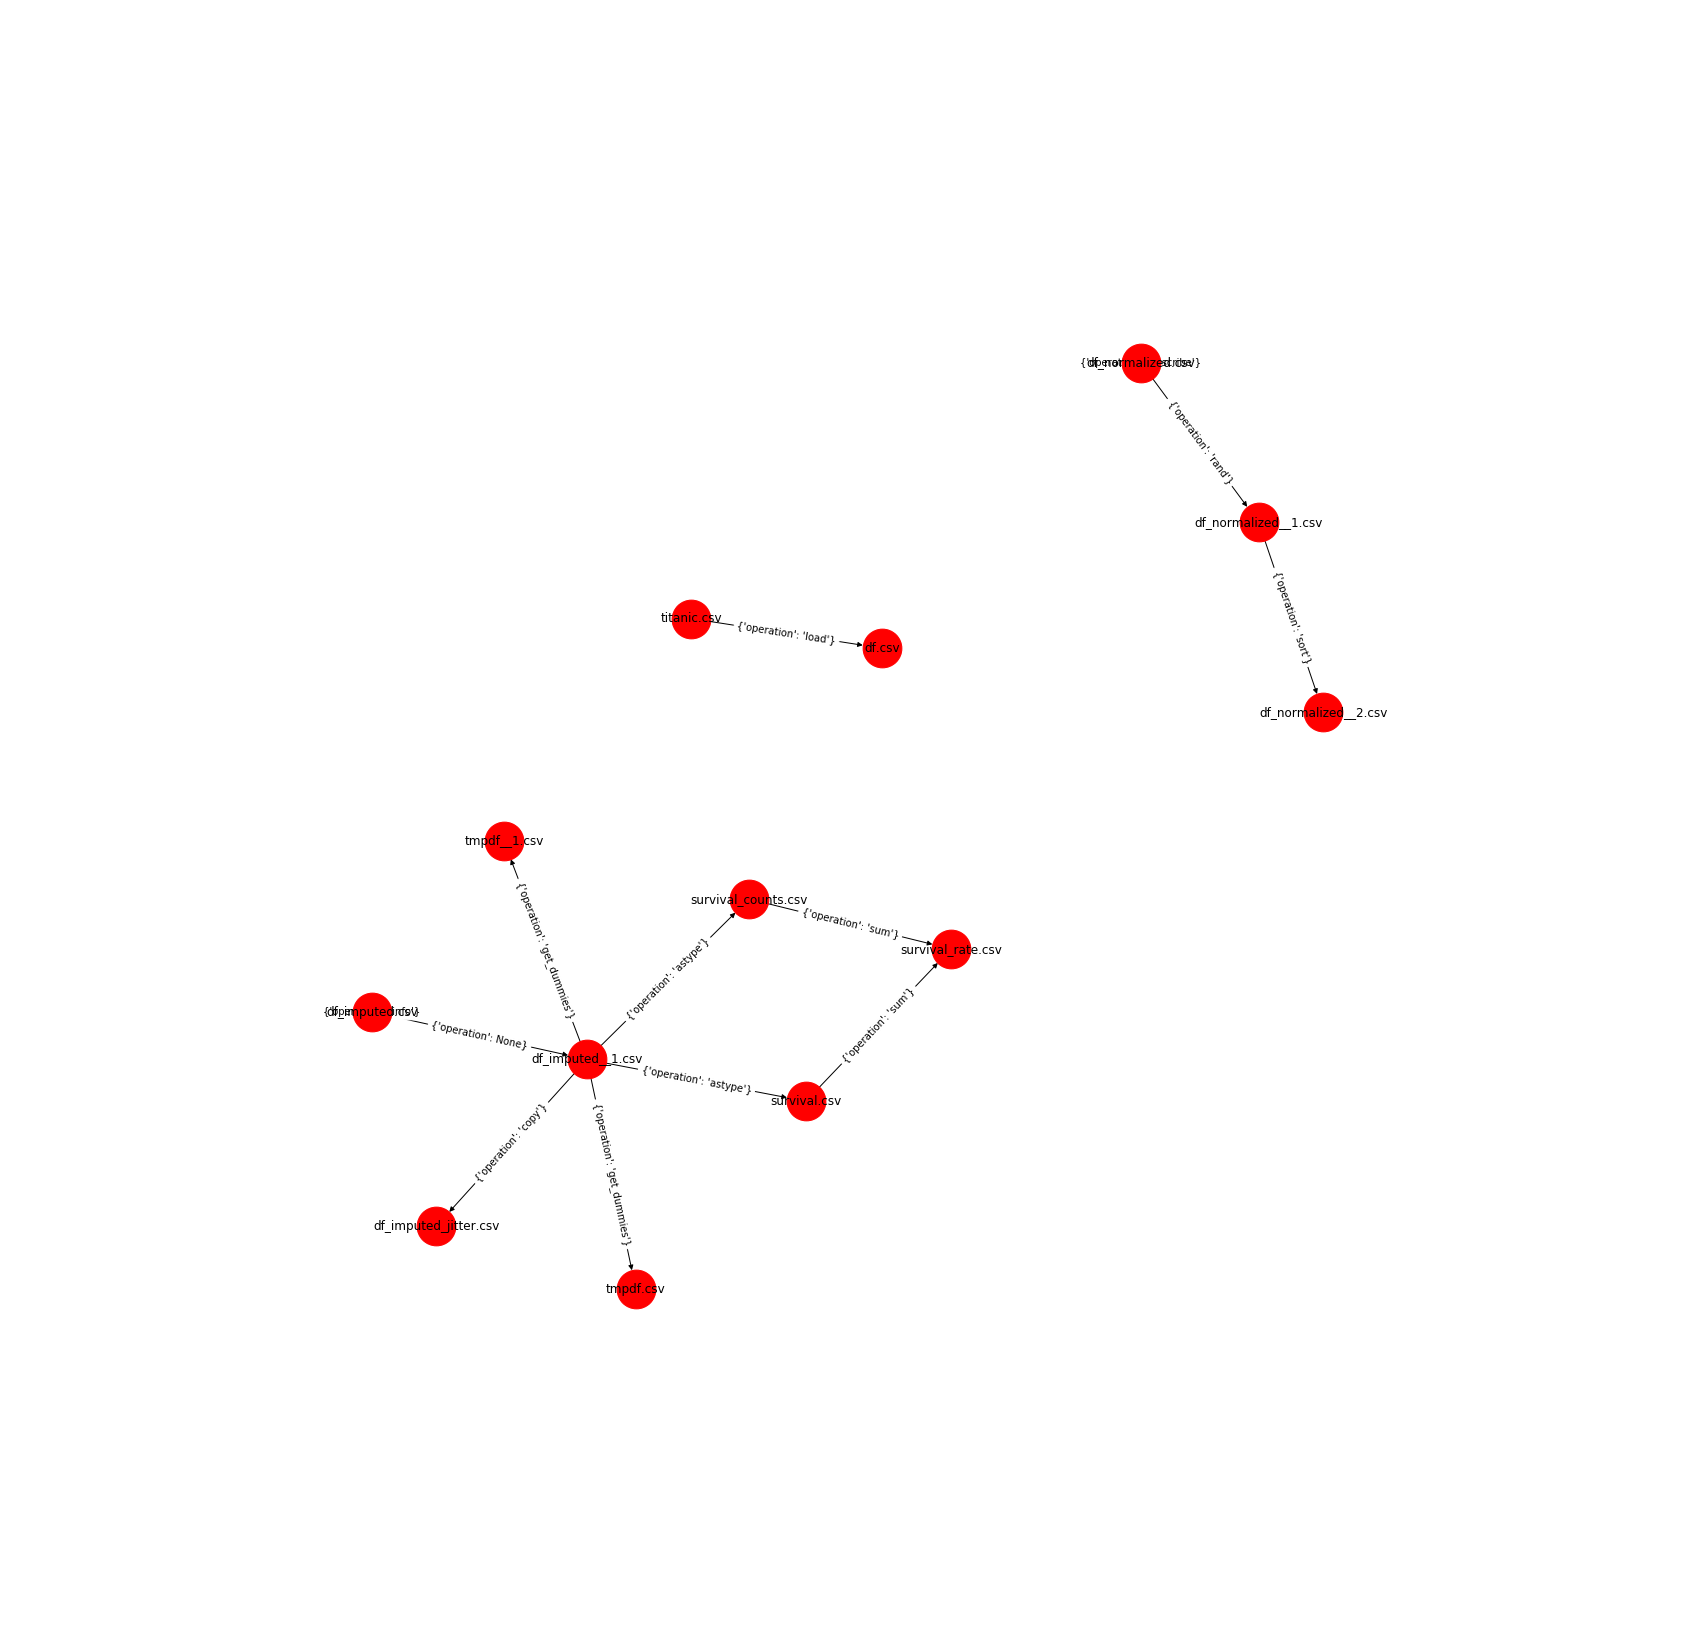

nb_924102.ipynb


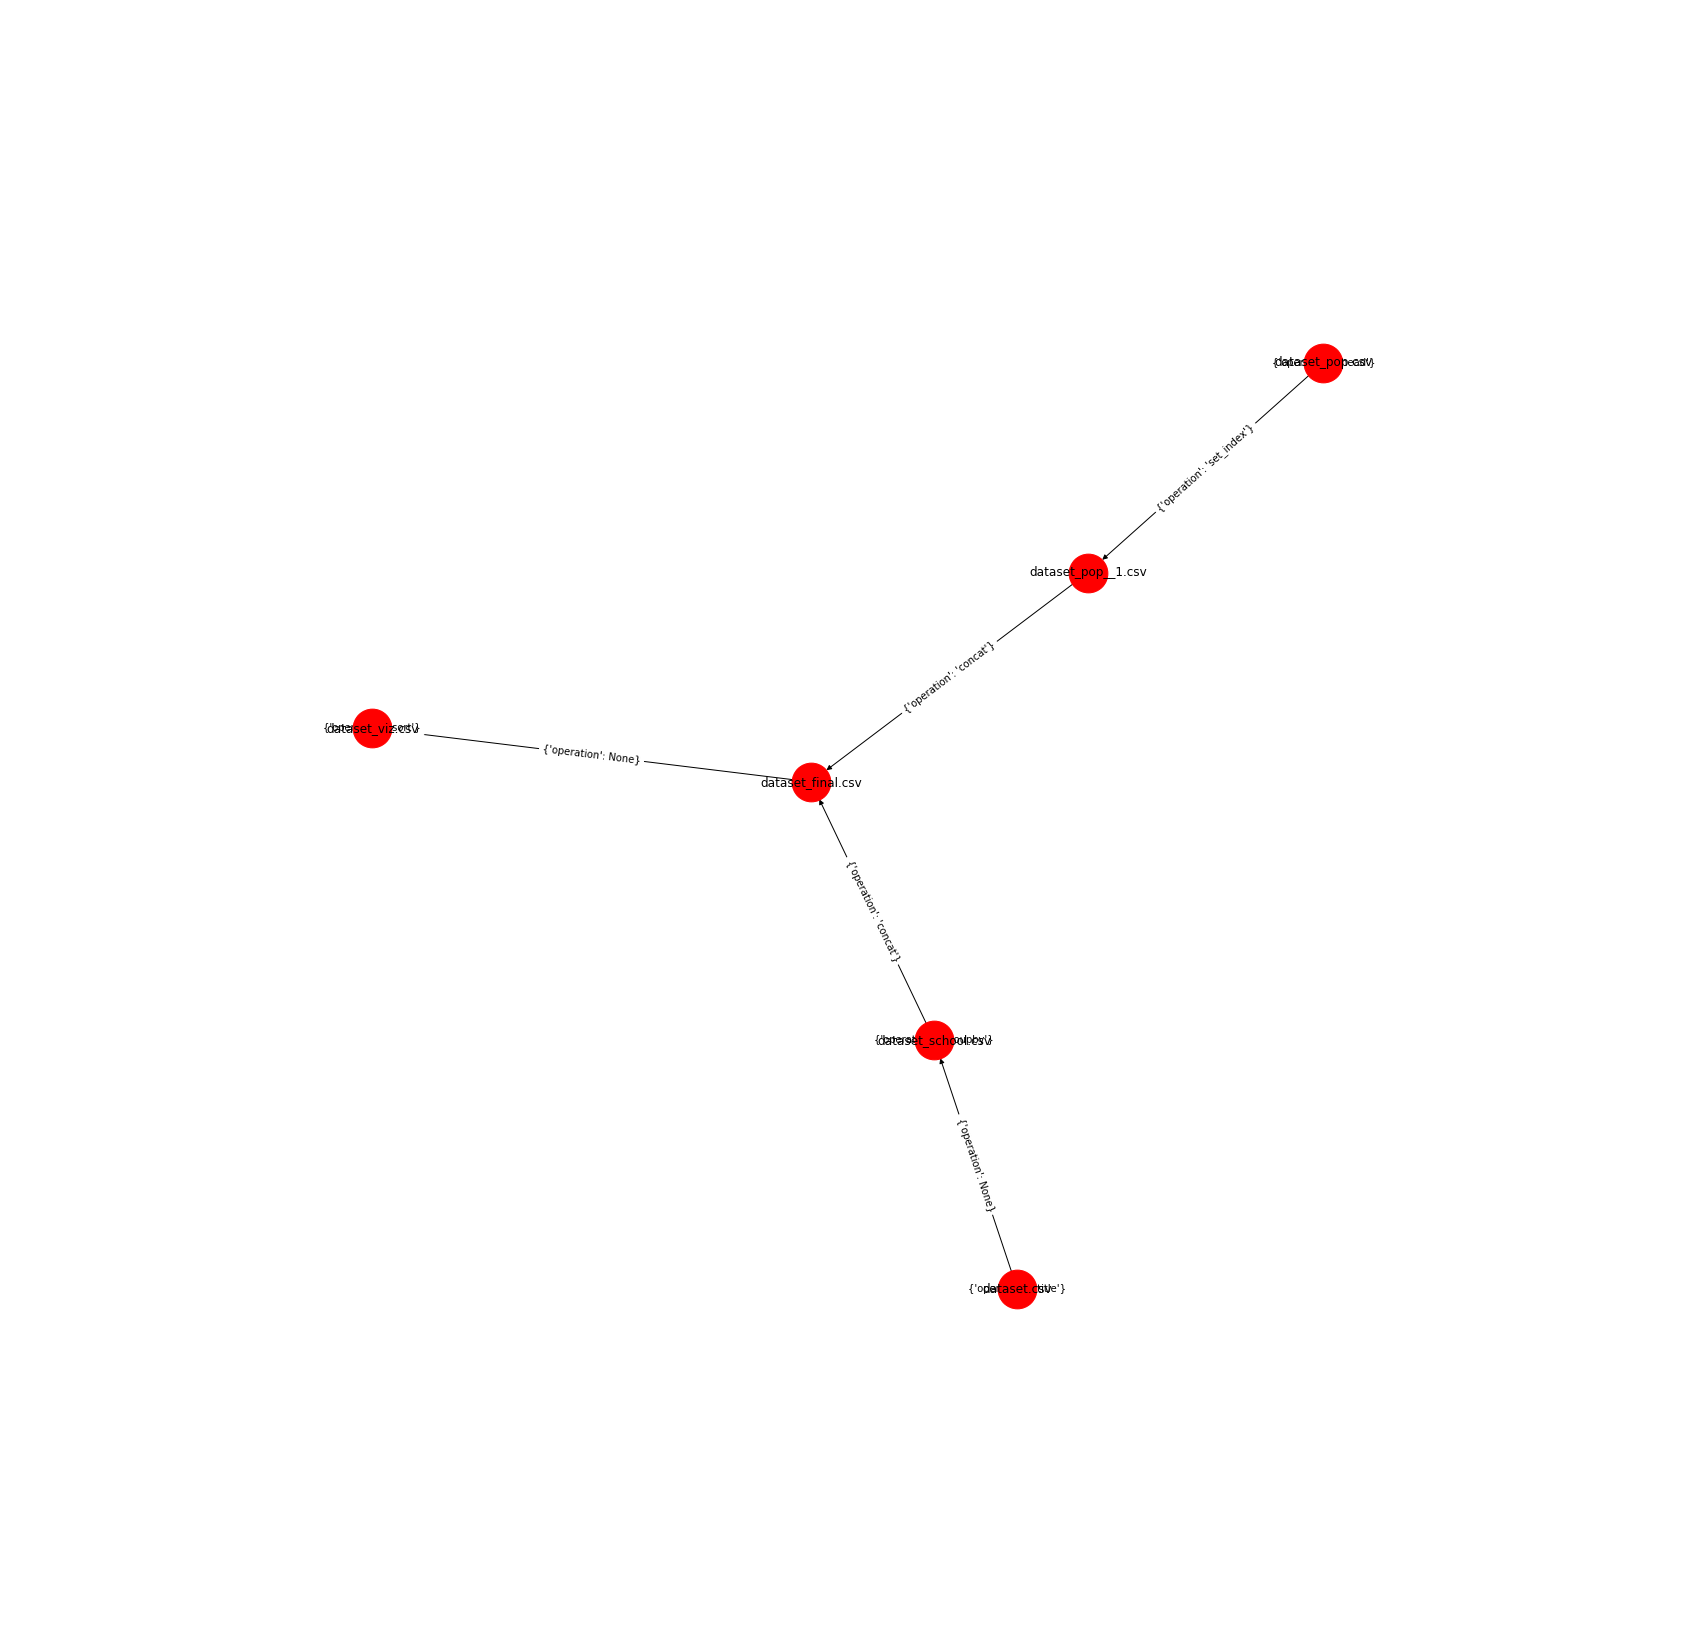

nb_921915.ipynb


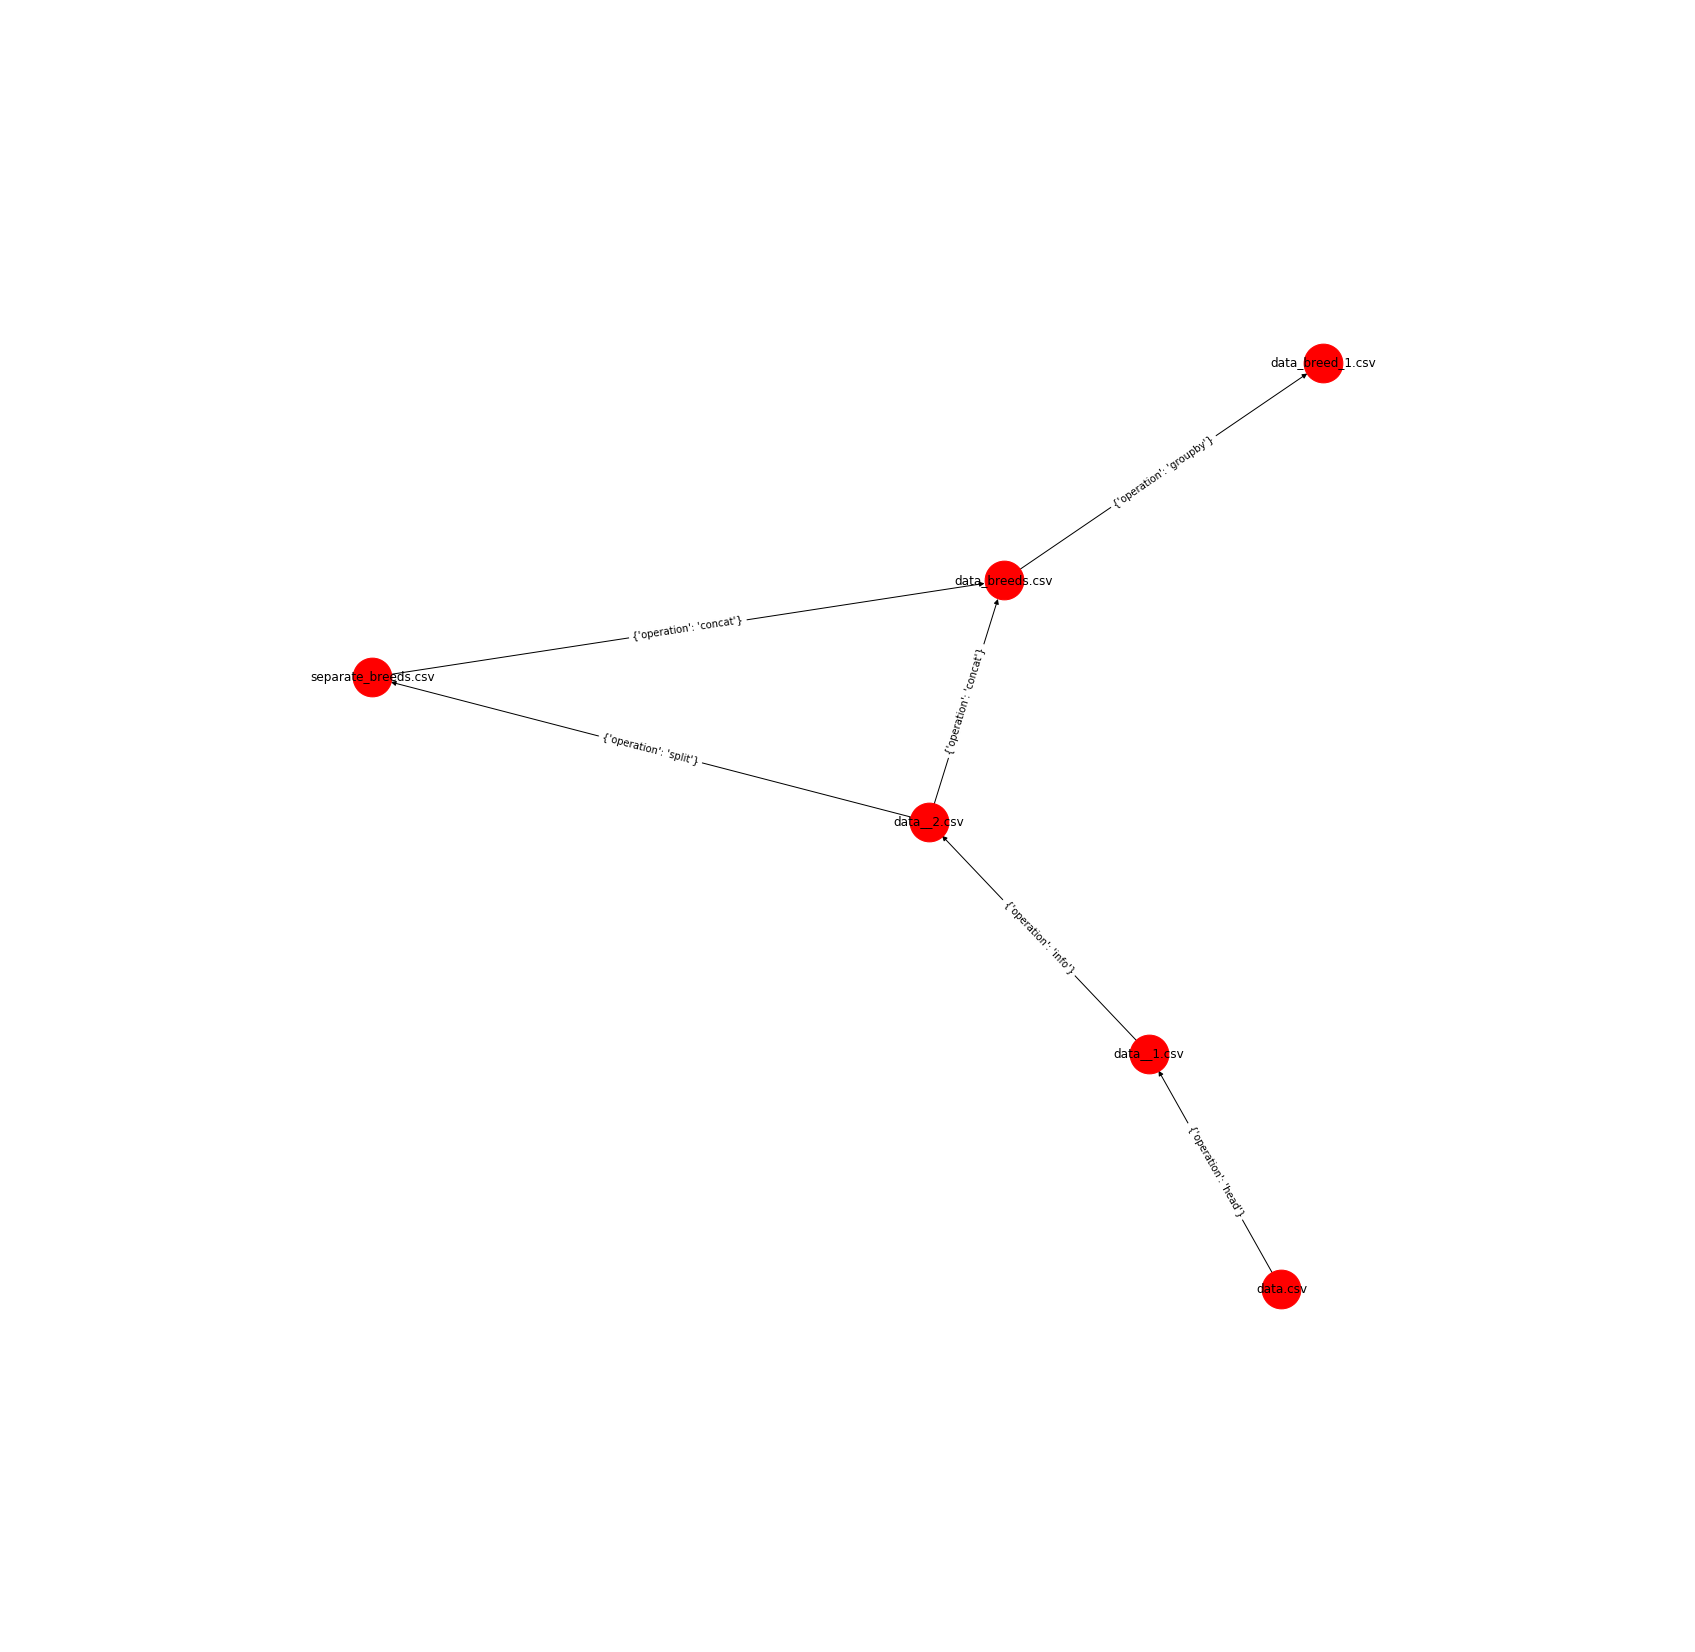

nb_986282.ipynb


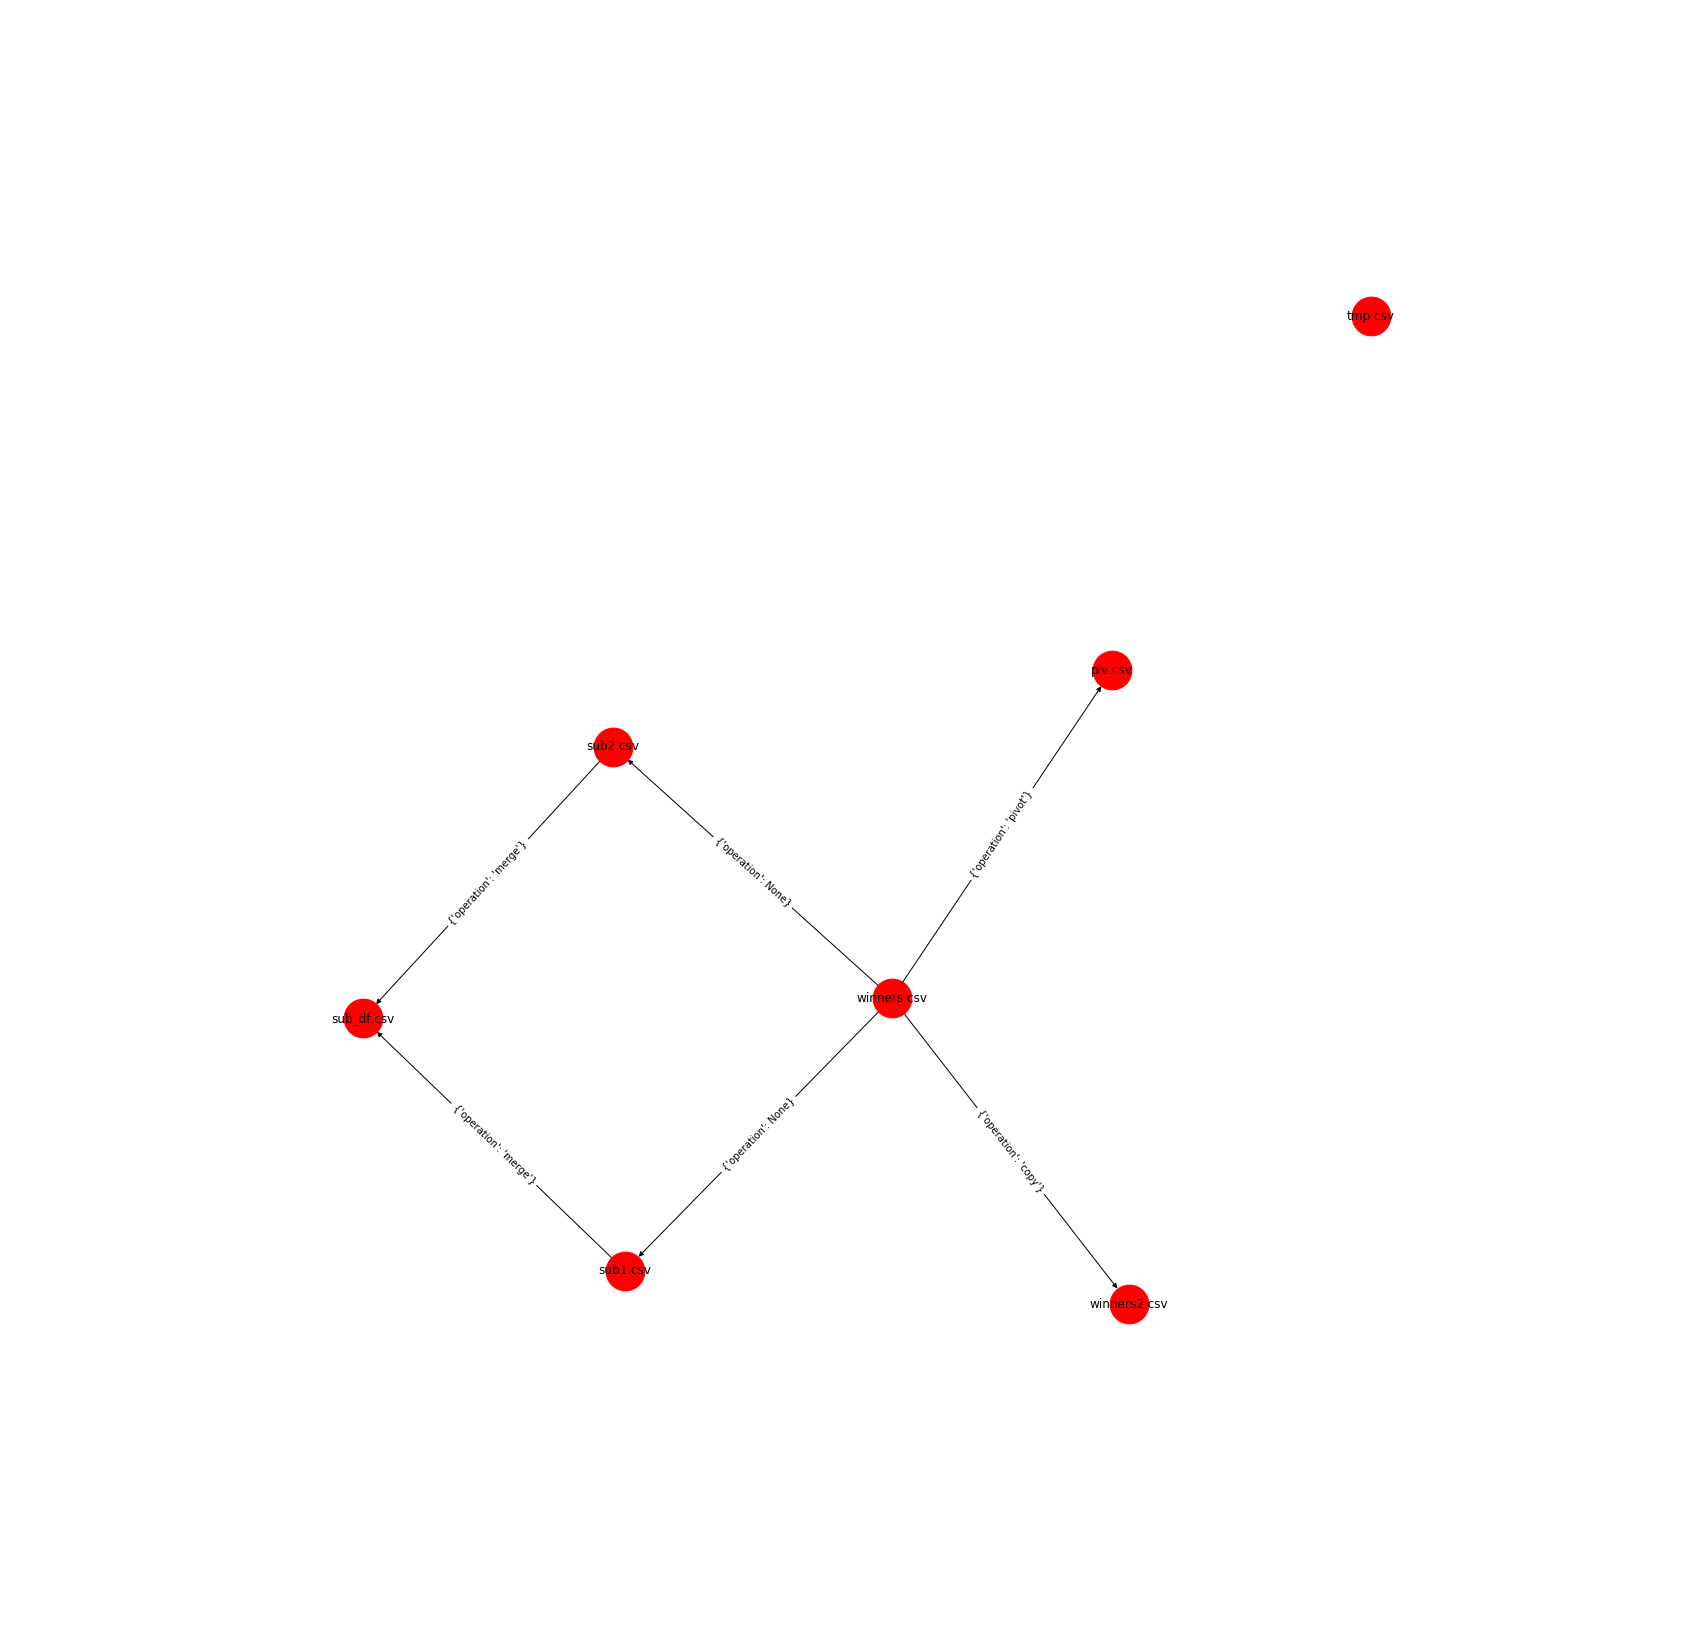

nb_639263.ipynb


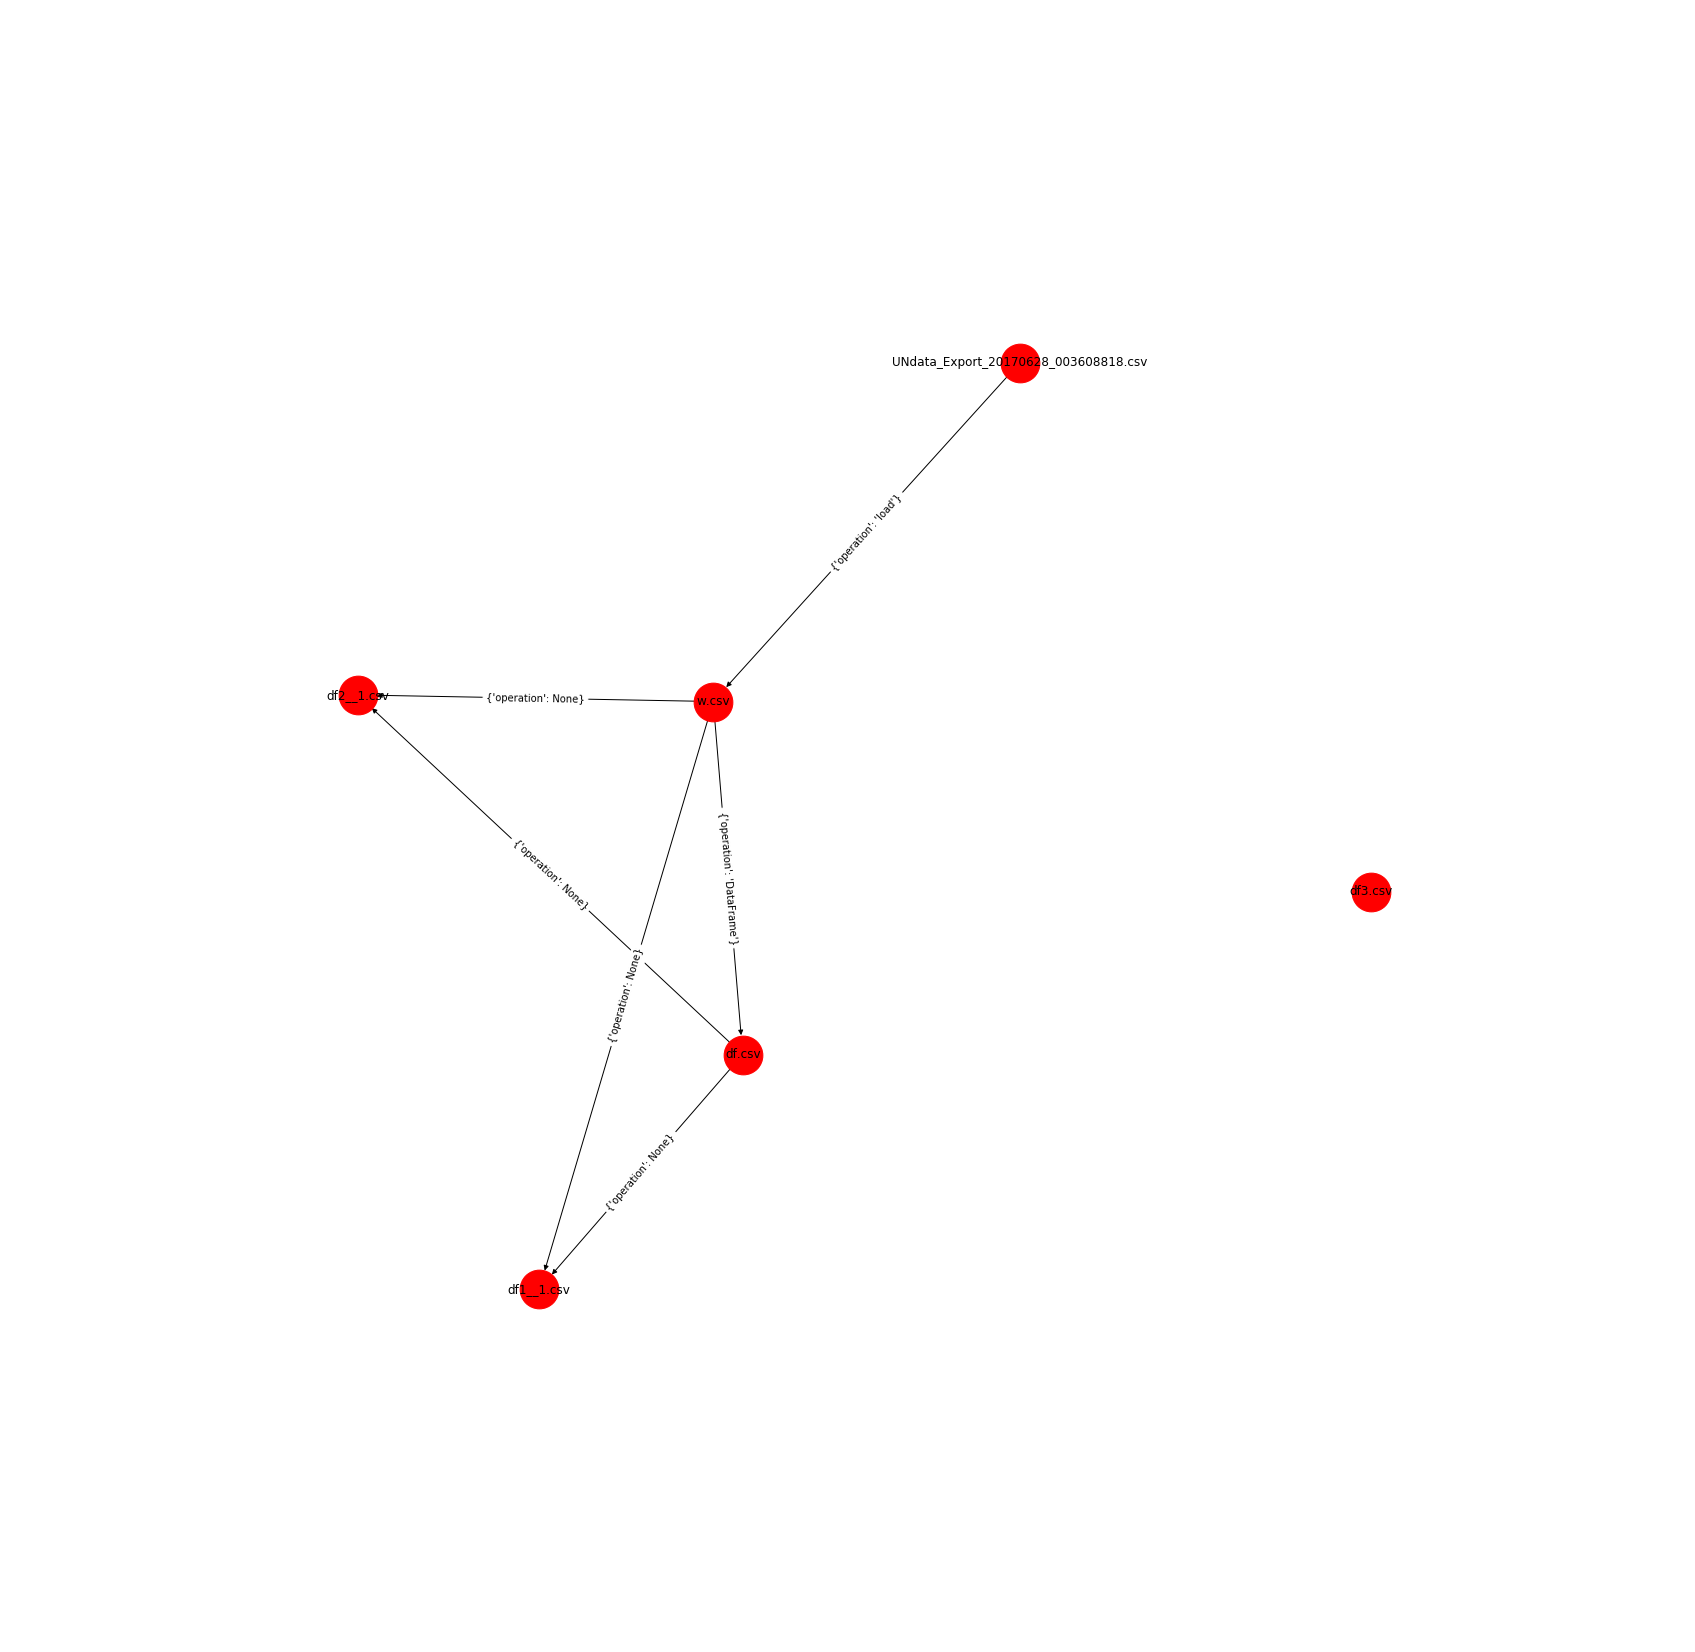

In [142]:
gt_df = pd.DataFrame(columns = ['nb_name', 'vertices', 'edges', 'diff_edge_tree'])

for nb in nb_list:
    nb_name = nb+'.ipynb'
    print(nb_name)
    g_truth = display_notebook(nb_name)
    gt_df = pd.concat([gt_df, compute_graph_metrics(nb_name)], ignore_index=True)
    

In [122]:
all_pr_df.loc[all_pr_df.nb_name == 'nb_986282.ipynb']

nb_name  index   preclustering distance_metric edges_correct  \
112  nb_986282.ipynb   True    exact_schema            cell             1   
113  nb_986282.ipynb   True    exact_schema             col             5   
114  nb_986282.ipynb  False    exact_schema            cell             0   
115  nb_986282.ipynb  False    exact_schema             col             0   
116  nb_986282.ipynb   True  no_pre_cluster            cell             0   
117  nb_986282.ipynb   True  no_pre_cluster             col             4   
118  nb_986282.ipynb  False  no_pre_cluster            cell             0   
119  nb_986282.ipynb  False  no_pre_cluster             col             0   

    edges_missing edges_to_remove  precision    recall        F1  
112             5               5   0.166667  0.166667  0.166667  
113             1               1   0.833333  0.833333  0.833333  
114             6               0   0.000000  0.000000  0.000000  
115             6               0   0.000000  0.000000  0.000000  
116             6               6   0.000000  0.000000  0.000000  
117             2               2   0.666667  0.666667  0.666667  
118             6               0   0.000000  0.000000  0.000000  
119             6               0   0.000000  0.000000  0.000000

In [137]:
len(g_truth.edges)
len(g_truth.nodes)

6

In [155]:
gt_df = gt_df.set_index('nb_name')

# Results

In [218]:
best_notebooks = gt_df.merge(top_nb_scores, on='nb_name').sort_values('F1',ascending=False)
best_notebooks.to_excel('best.xlsx')

In [219]:
new_cols = pd.read_excel('best.xlsx', header=[0, 1])
new_cols

nb_name         Ground Truth                      Inference Result  \
                    vertices edges diff_edge_tree    edges_correct   
nb_986282.ipynb            7     6              0                5   
nb_495072.ipynb           10     9              0                6   
nb_269991.ipynb            7     6              0                3   
nb_417011.ipynb            8     7              0                3   
nb_266913.ipynb            7     6              0                3   
nb_386796.ipynb            6     6             -1                2   
nb_331056.ipynb           12    12             -1                4   
nb_23457.ipynb             6     5              0                2   
nb_921915.ipynb            6     6             -1                2   
nb_315236.ipynb            9     8              0                2   
nb_33614.ipynb            21    21             -1                2   
nb_639263.ipynb            6     6             -1                1   
nb_772851.ipynb           13    13             -1                2   
nb_484354.ipynb           20    22             -3                1   
nb_316514.ipynb           10     8              1                0   
nb_924102.ipynb            6     9             -4                0   

nb_name                                          Scores                      
                edges_missing edges_to_remove precision    recall        F1  
nb_986282.ipynb             1               1  0.833333  0.833333  0.833333  
nb_495072.ipynb             3               1  0.666667  0.857143  0.750000  
nb_269991.ipynb             3               2  0.500000  0.600000  0.545455  
nb_417011.ipynb             4               2  0.428571  0.600000  0.500000  
nb_266913.ipynb             3               3  0.500000  0.500000  0.500000  
nb_386796.ipynb             4               1  0.333333  0.666667  0.444444  
nb_331056.ipynb             8               3  0.333333  0.571429  0.421053  
nb_23457.ipynb              3               3  0.400000  0.400000  0.400000  
nb_921915.ipynb             4               3  0.333333  0.400000  0.363636  
nb_315236.ipynb             6               3  0.250000  0.400000  0.307692  
nb_33614.ipynb             19               0  0.095238  1.000000  0.173913  
nb_639263.ipynb             5               5  0.166667  0.166667  0.166667  
nb_772851.ipynb            11              10  0.153846  0.166667  0.160000  
nb_484354.ipynb            21              10  0.045455  0.090909  0.060606  
nb_316514.ipynb             8               1  0.000000  0.000000  0.000000  
nb_924102.ipynb             9               2  0.000000  0.000000  0.000000

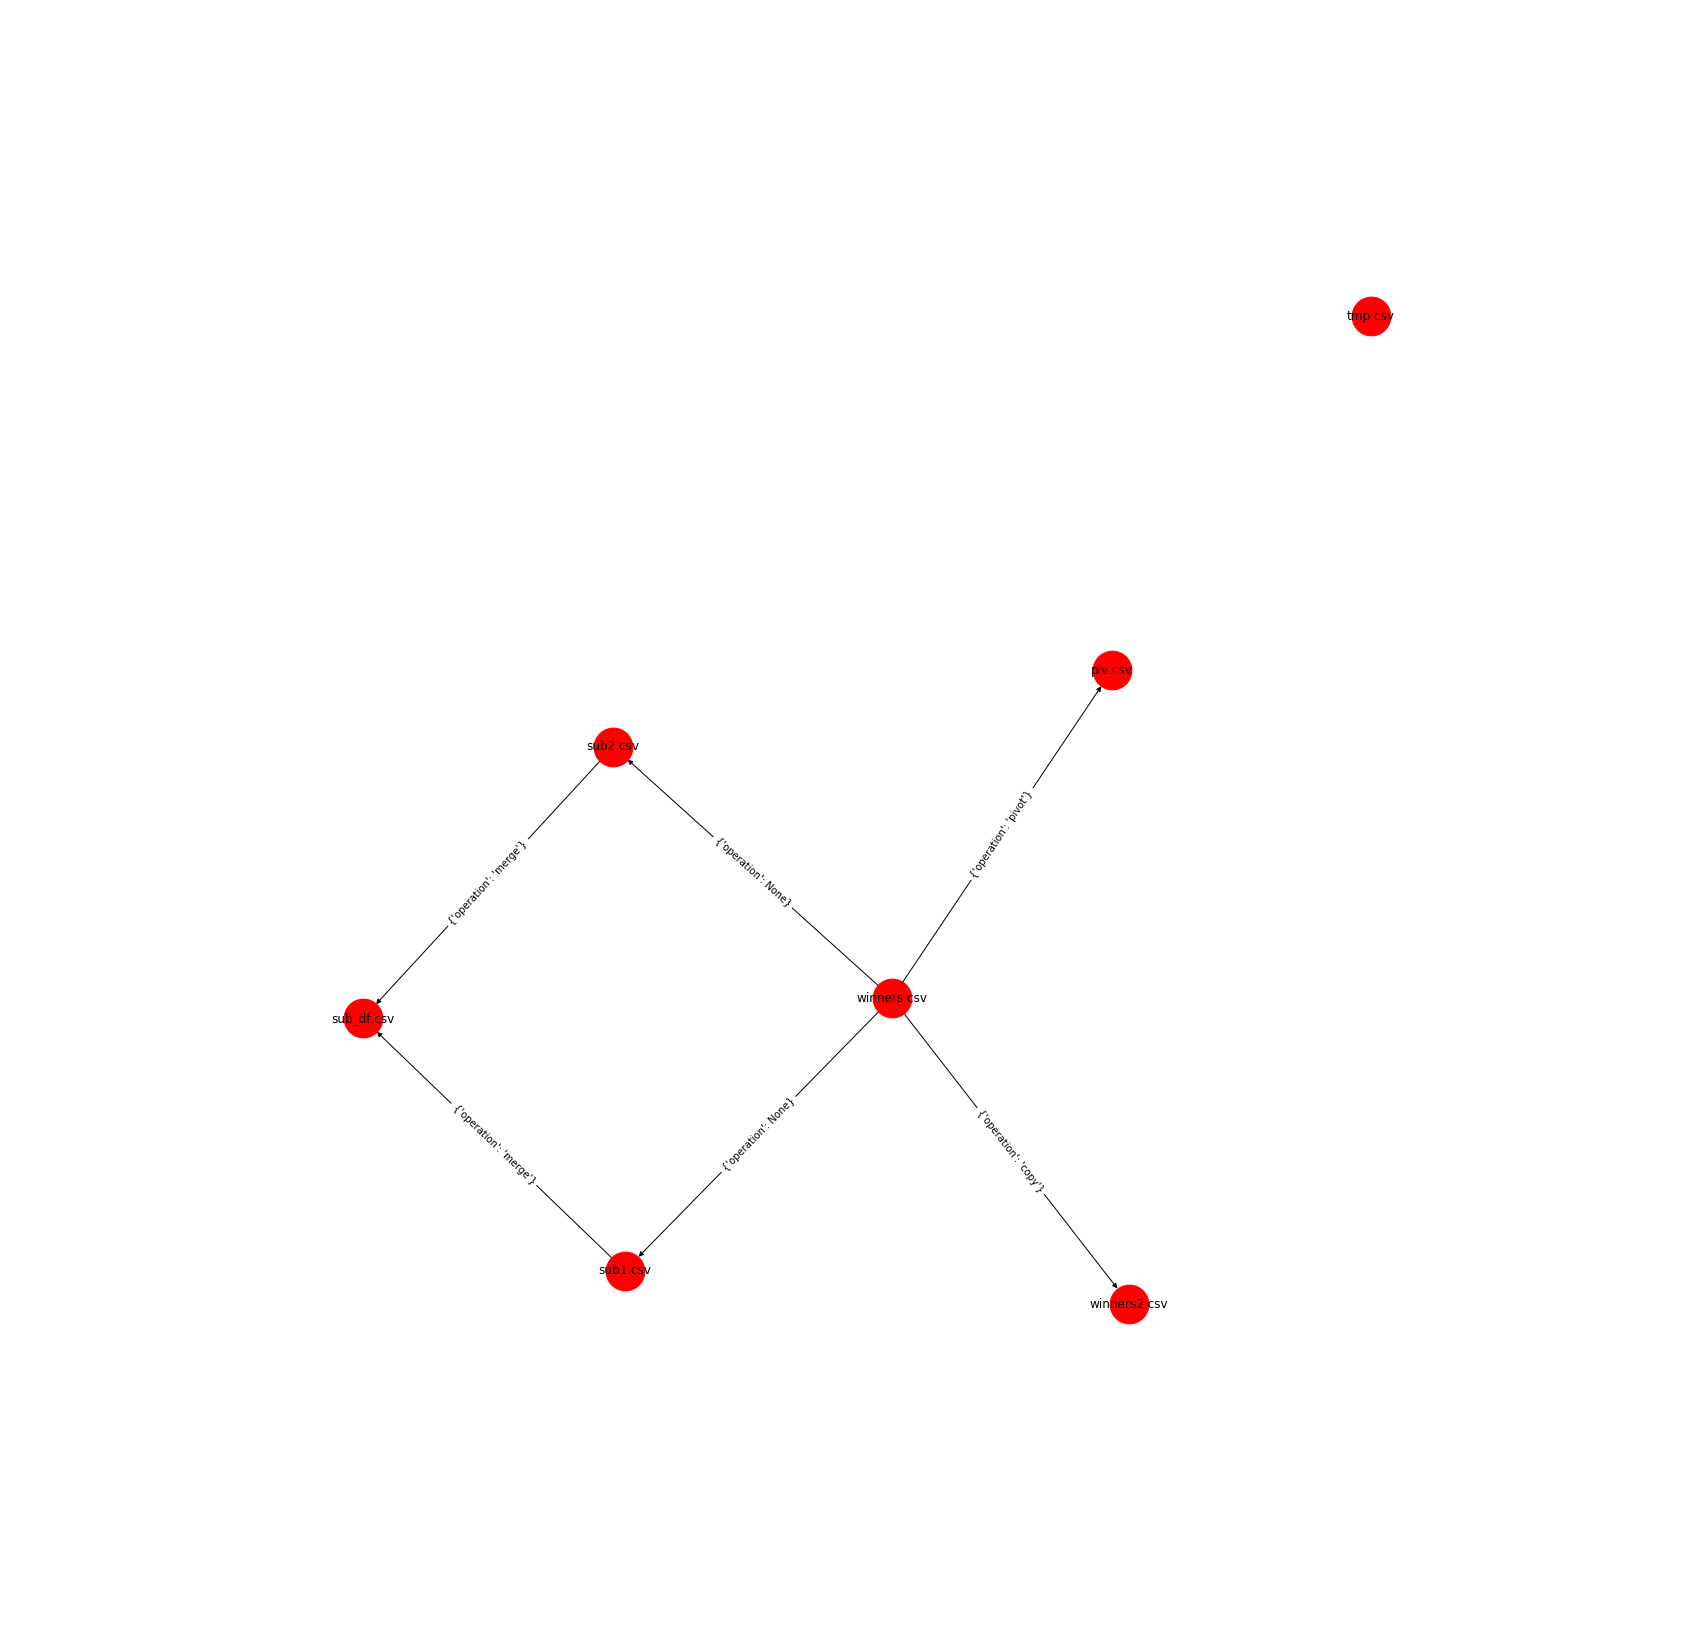

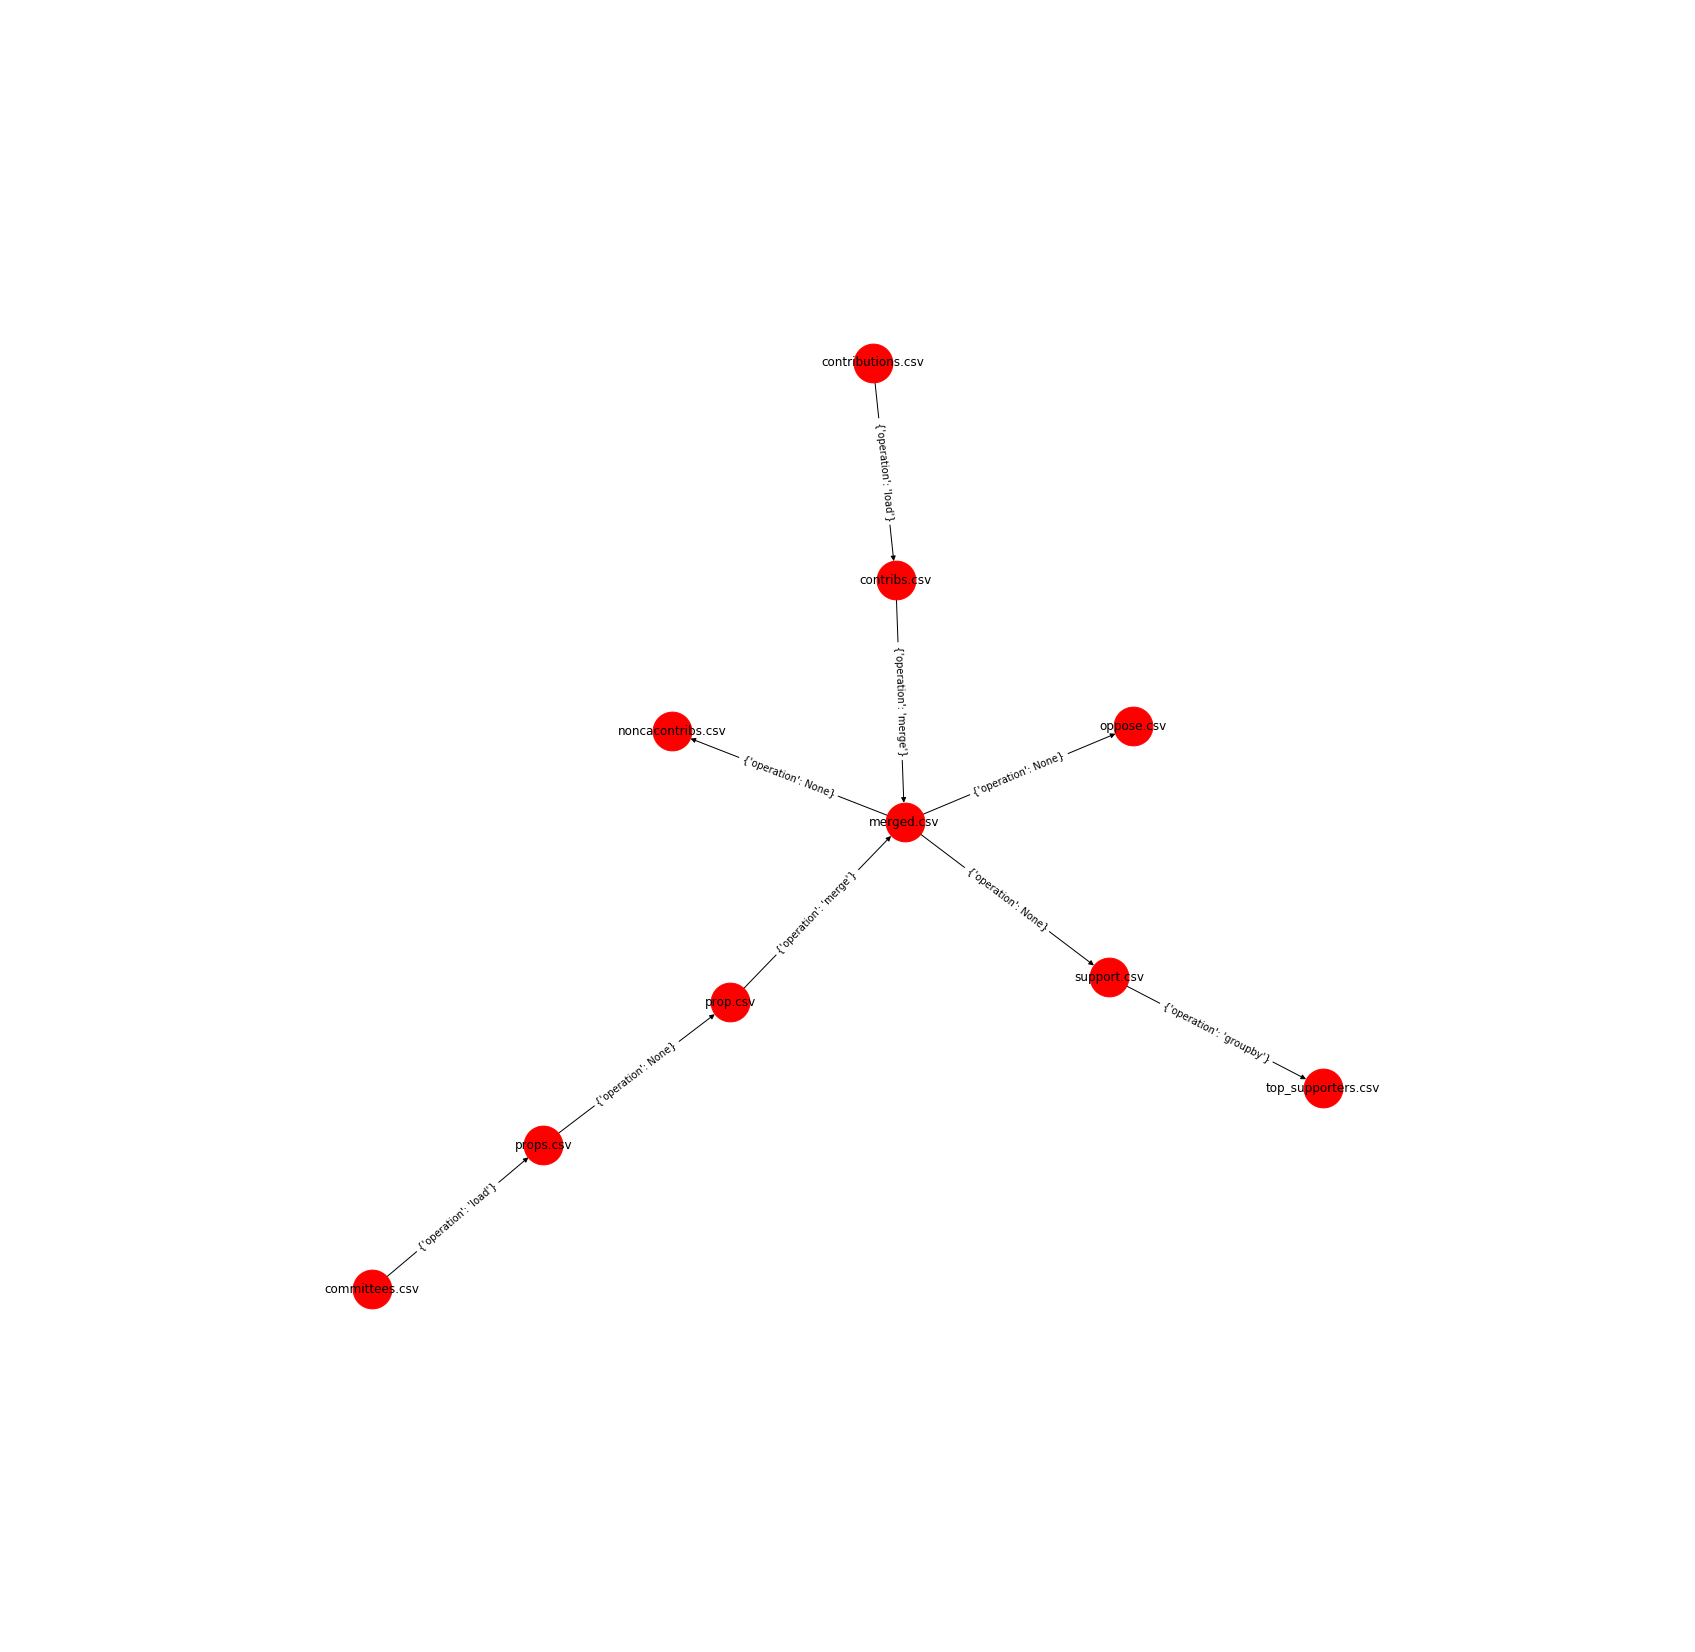

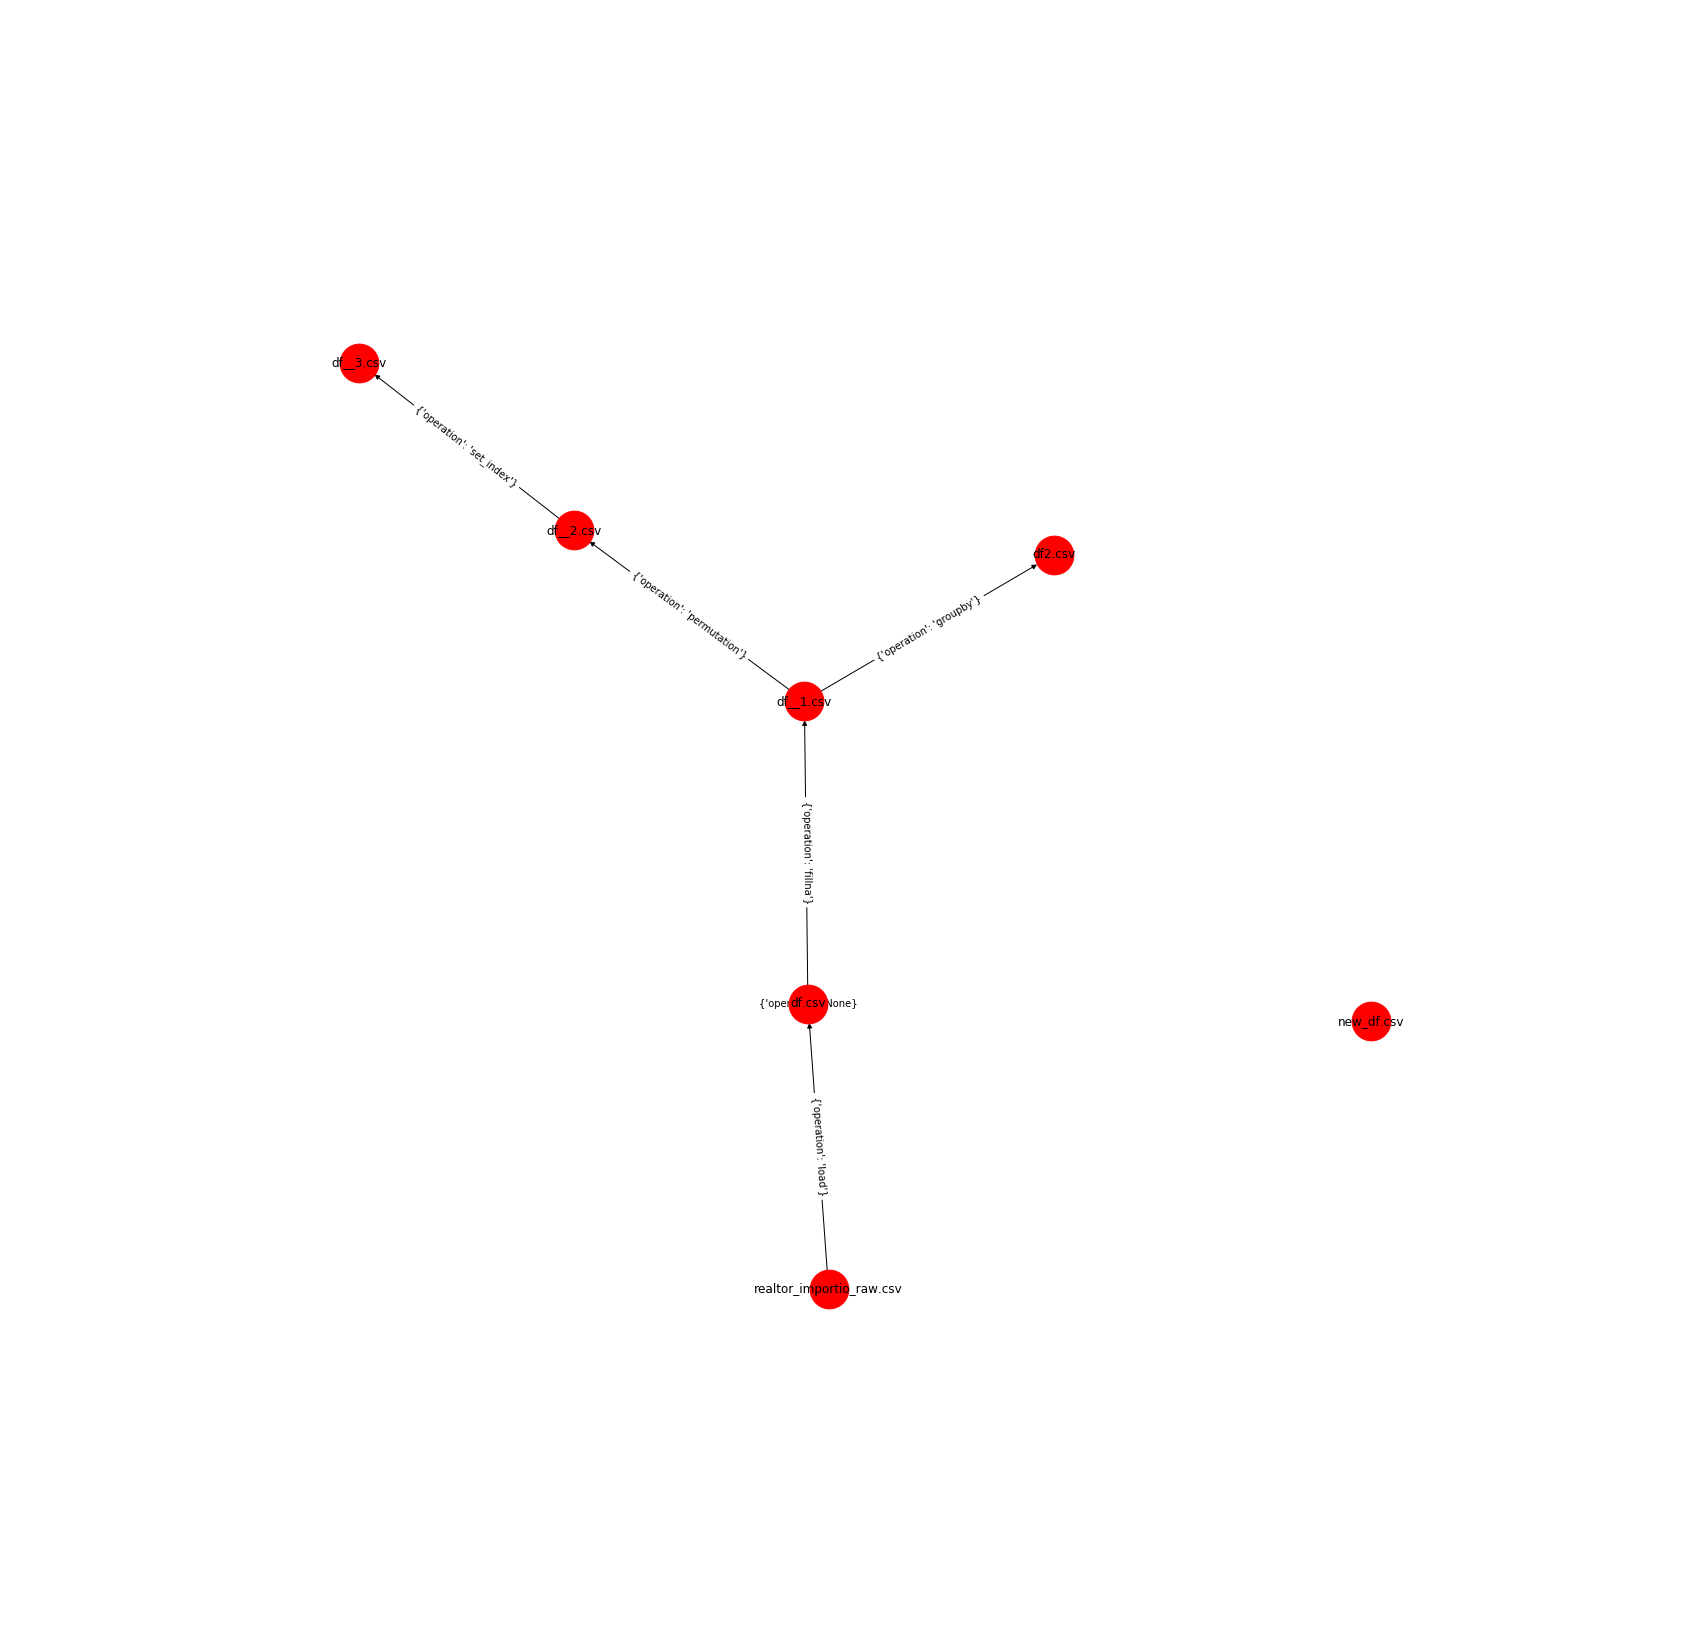

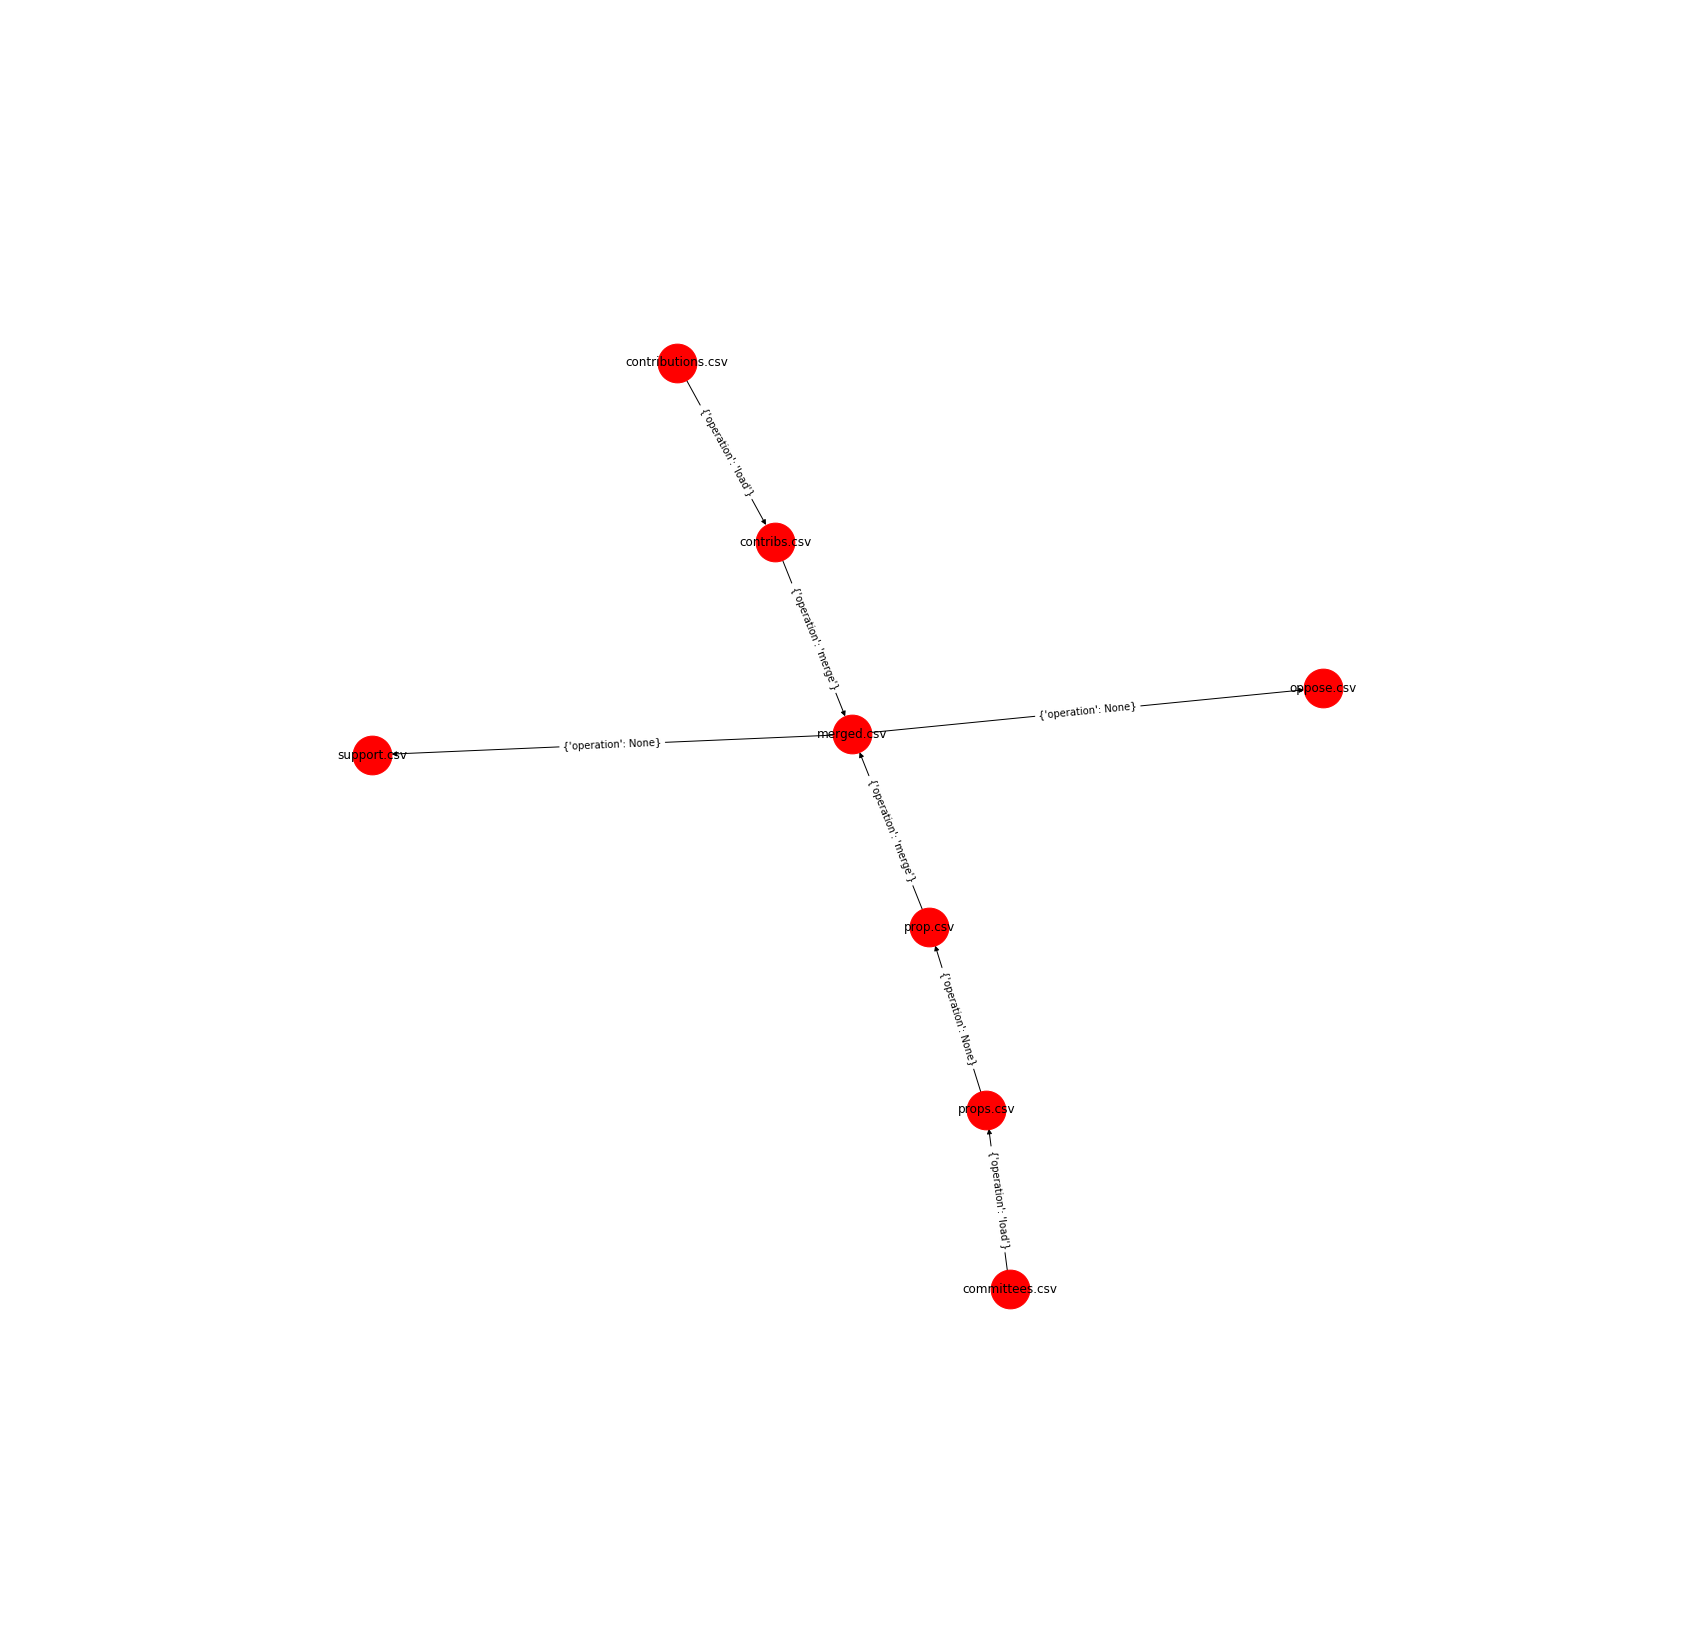

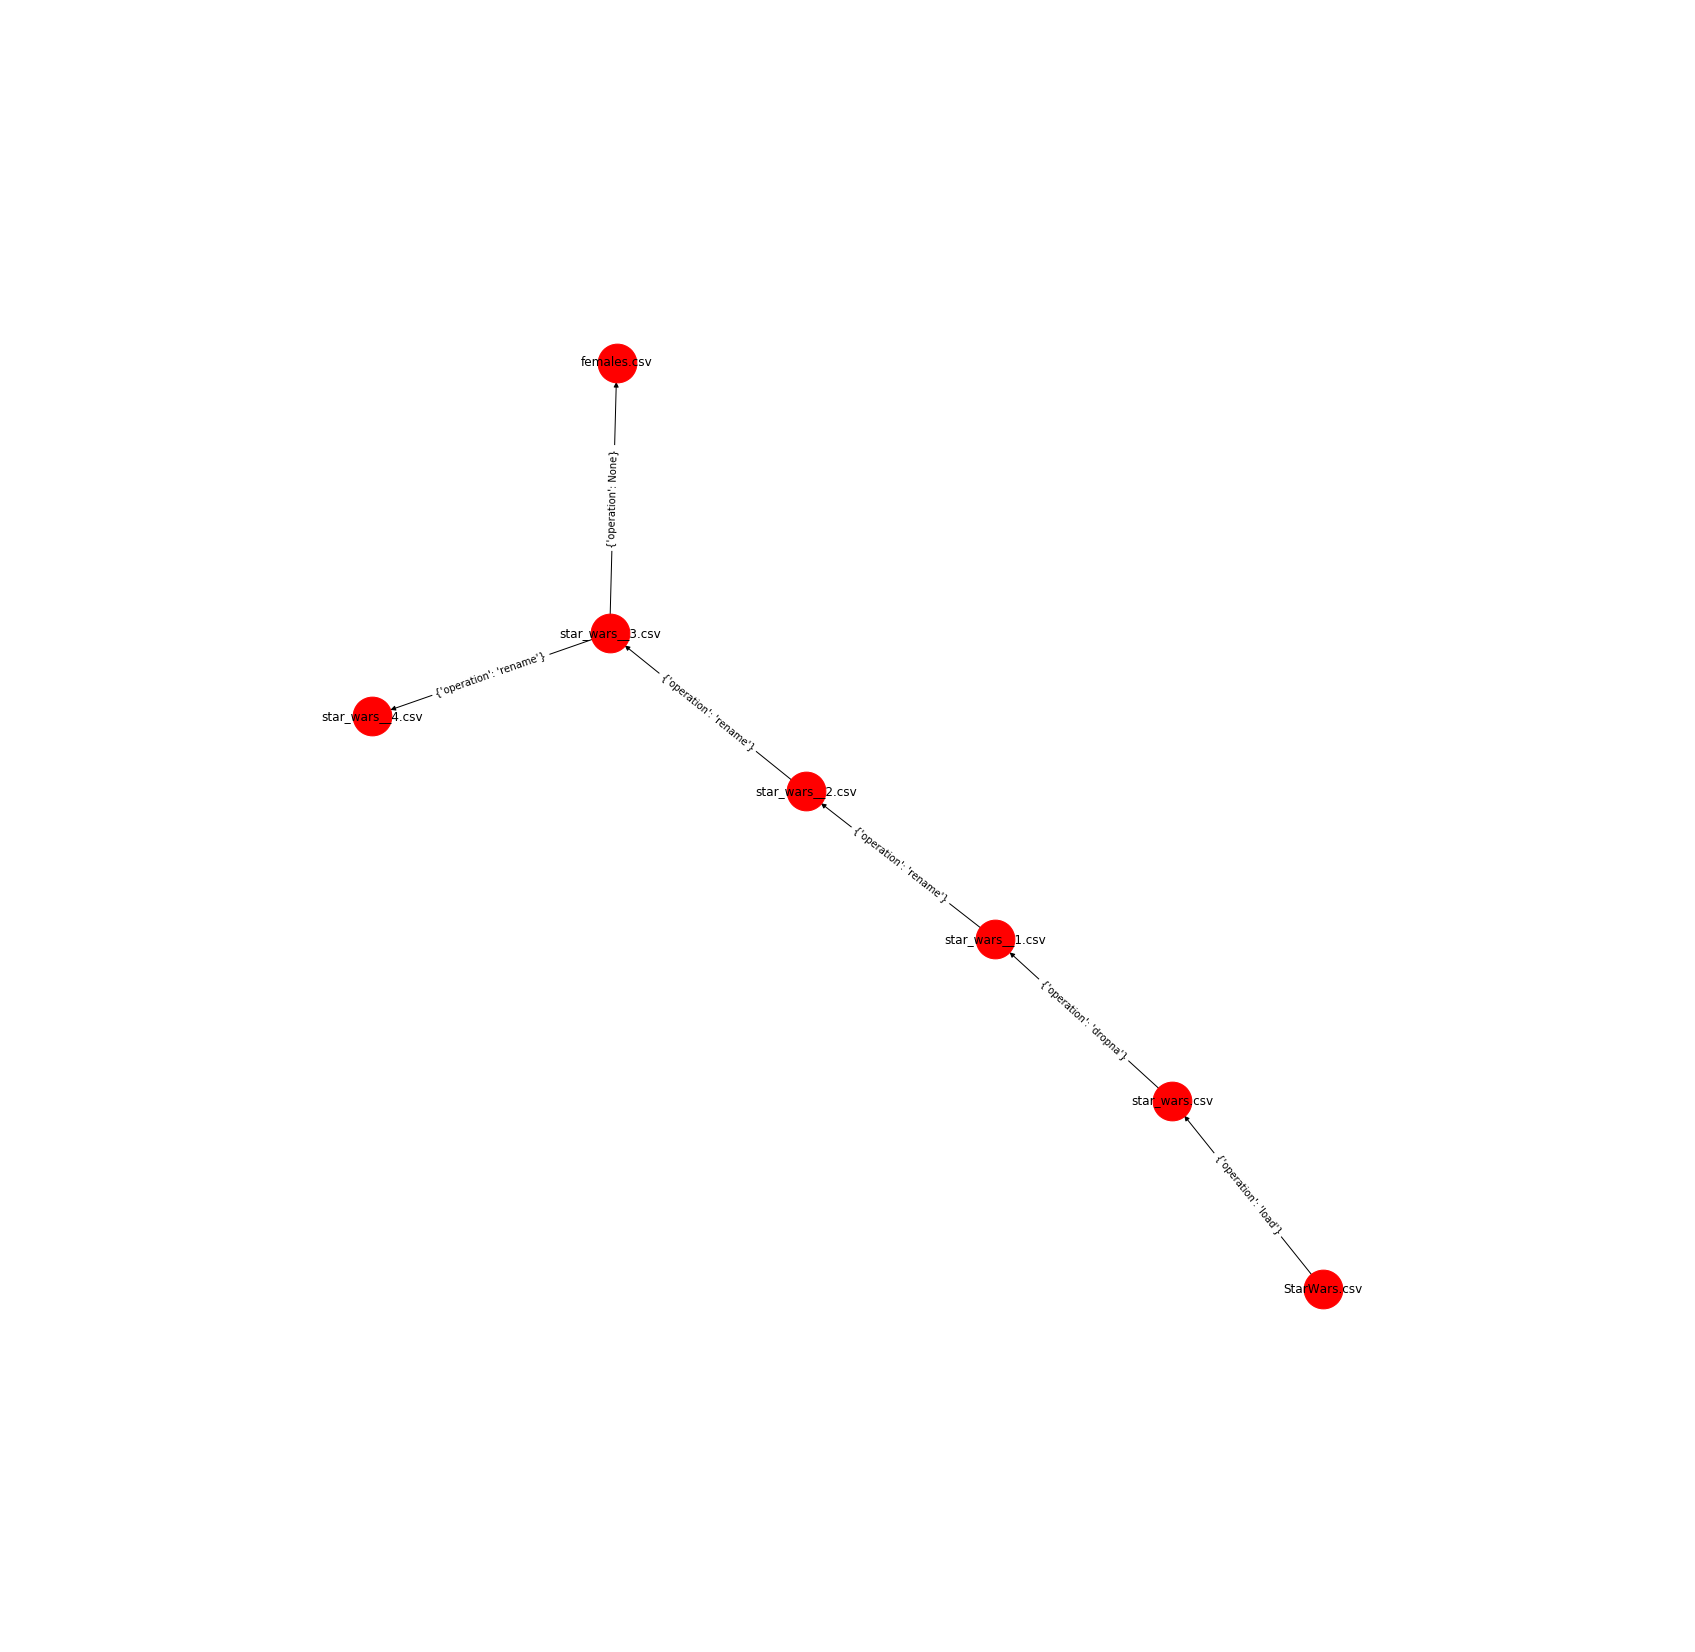

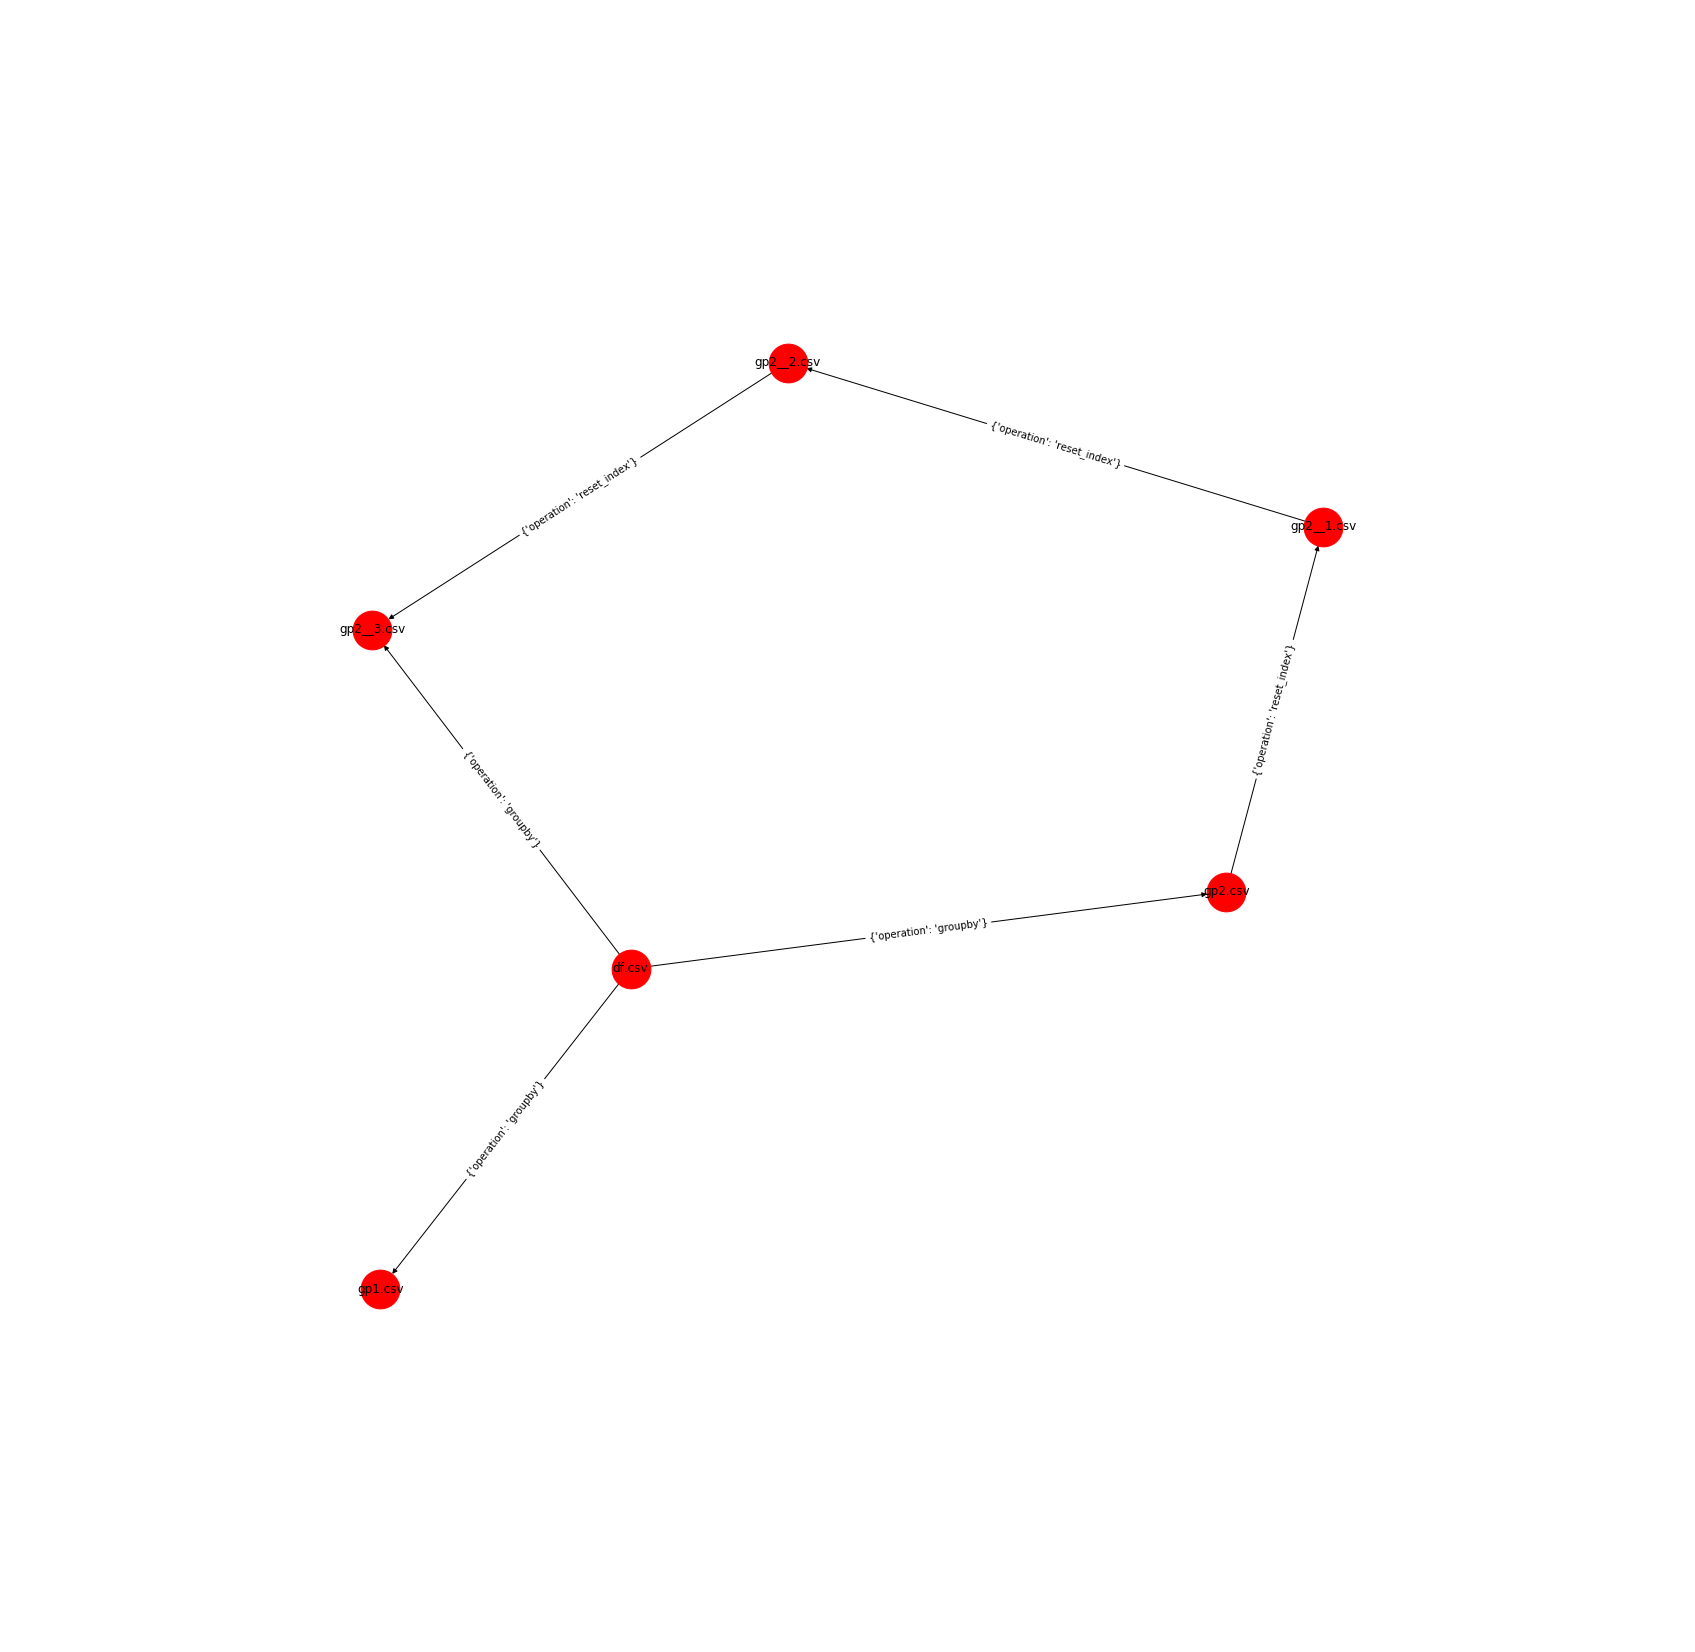

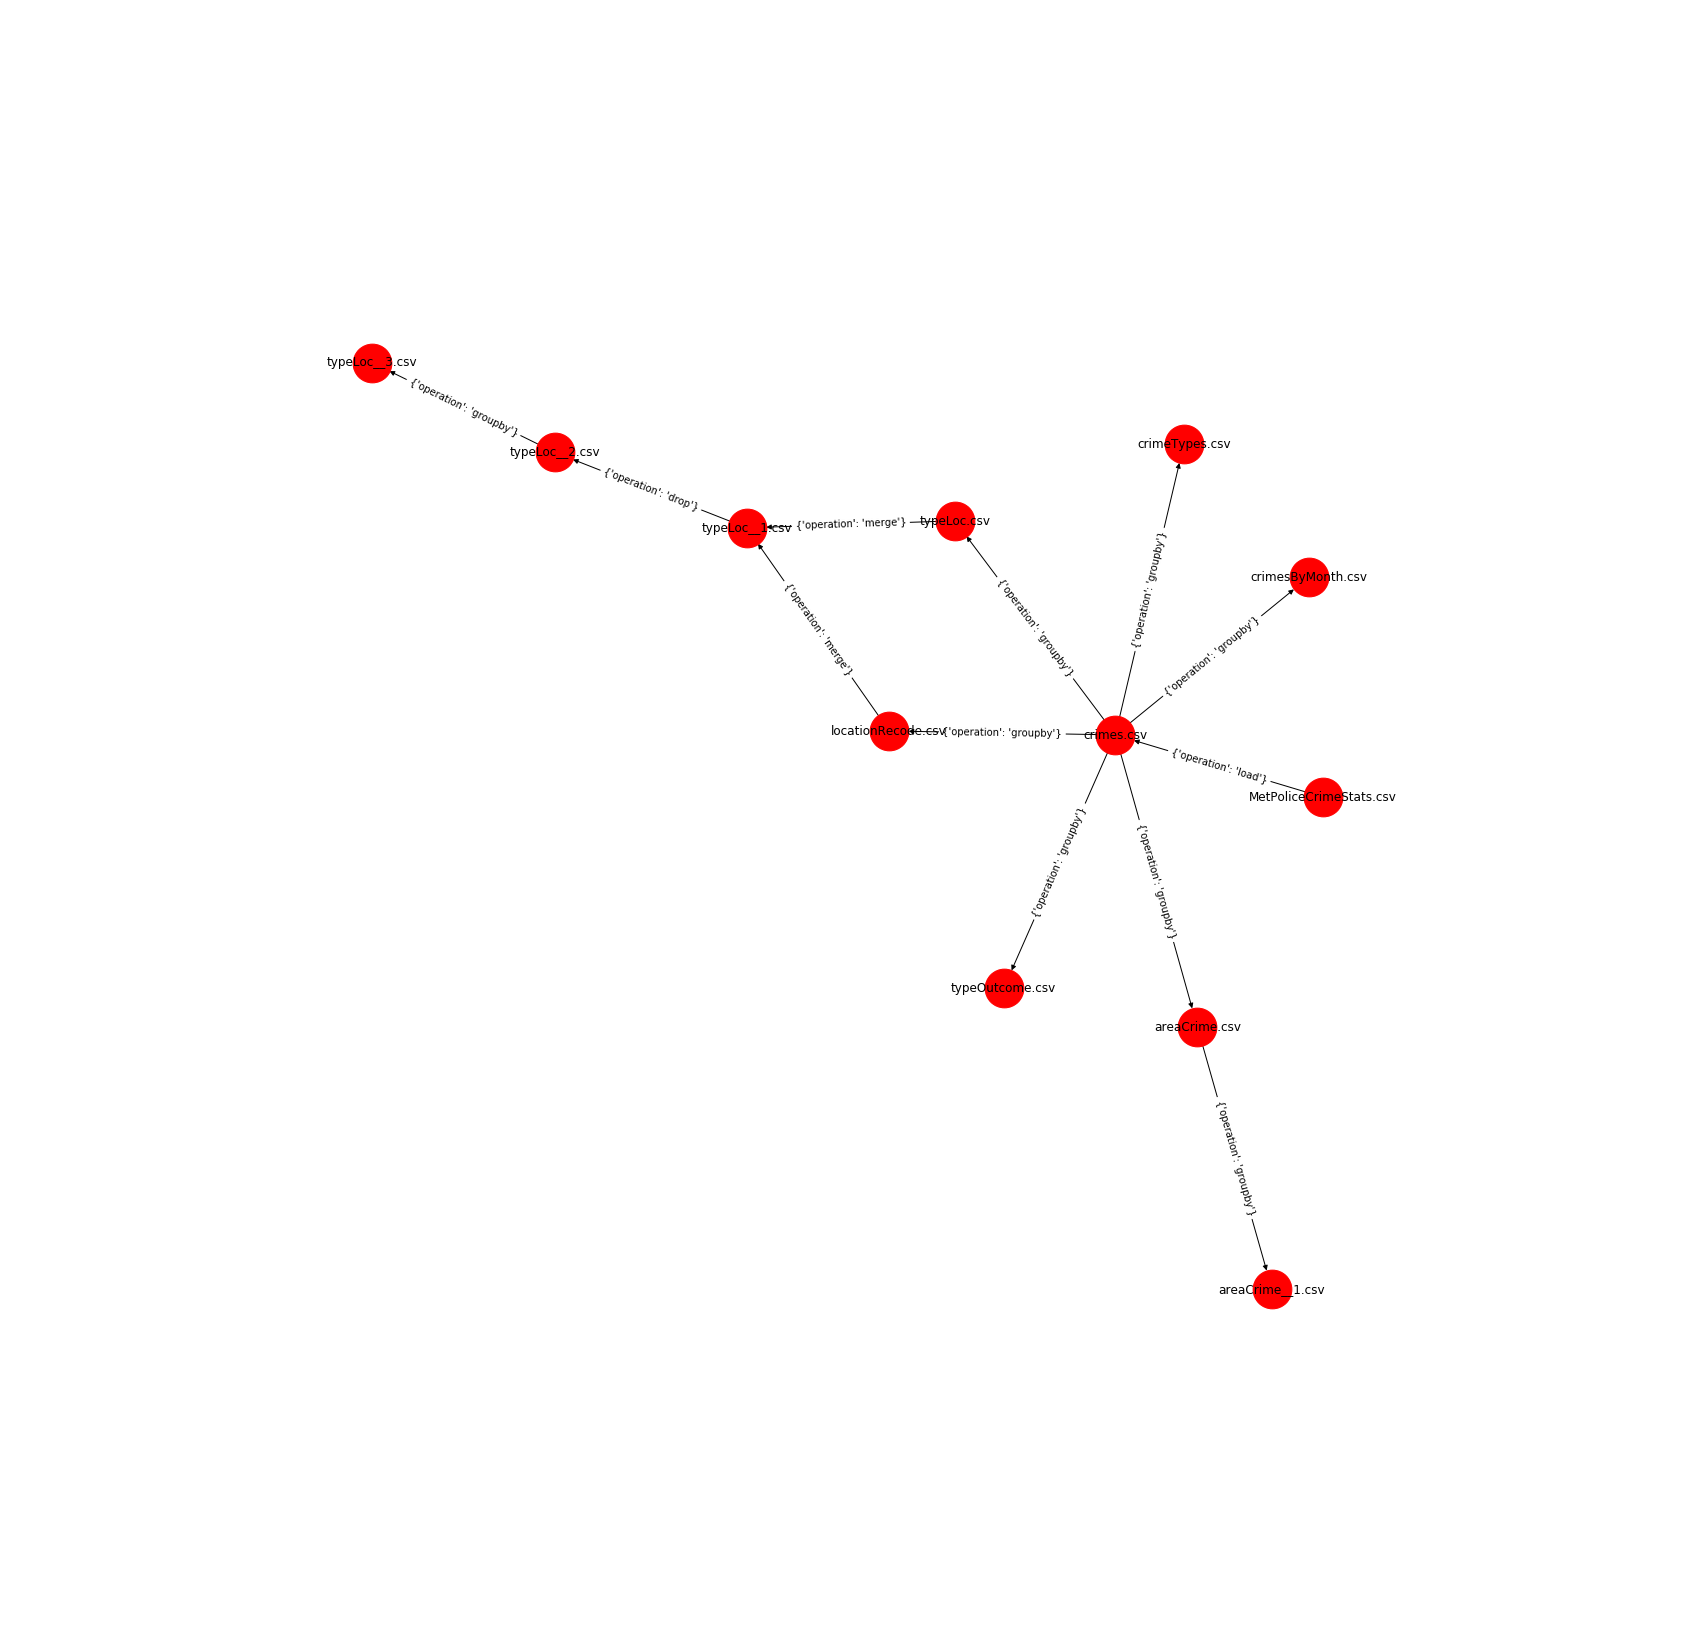

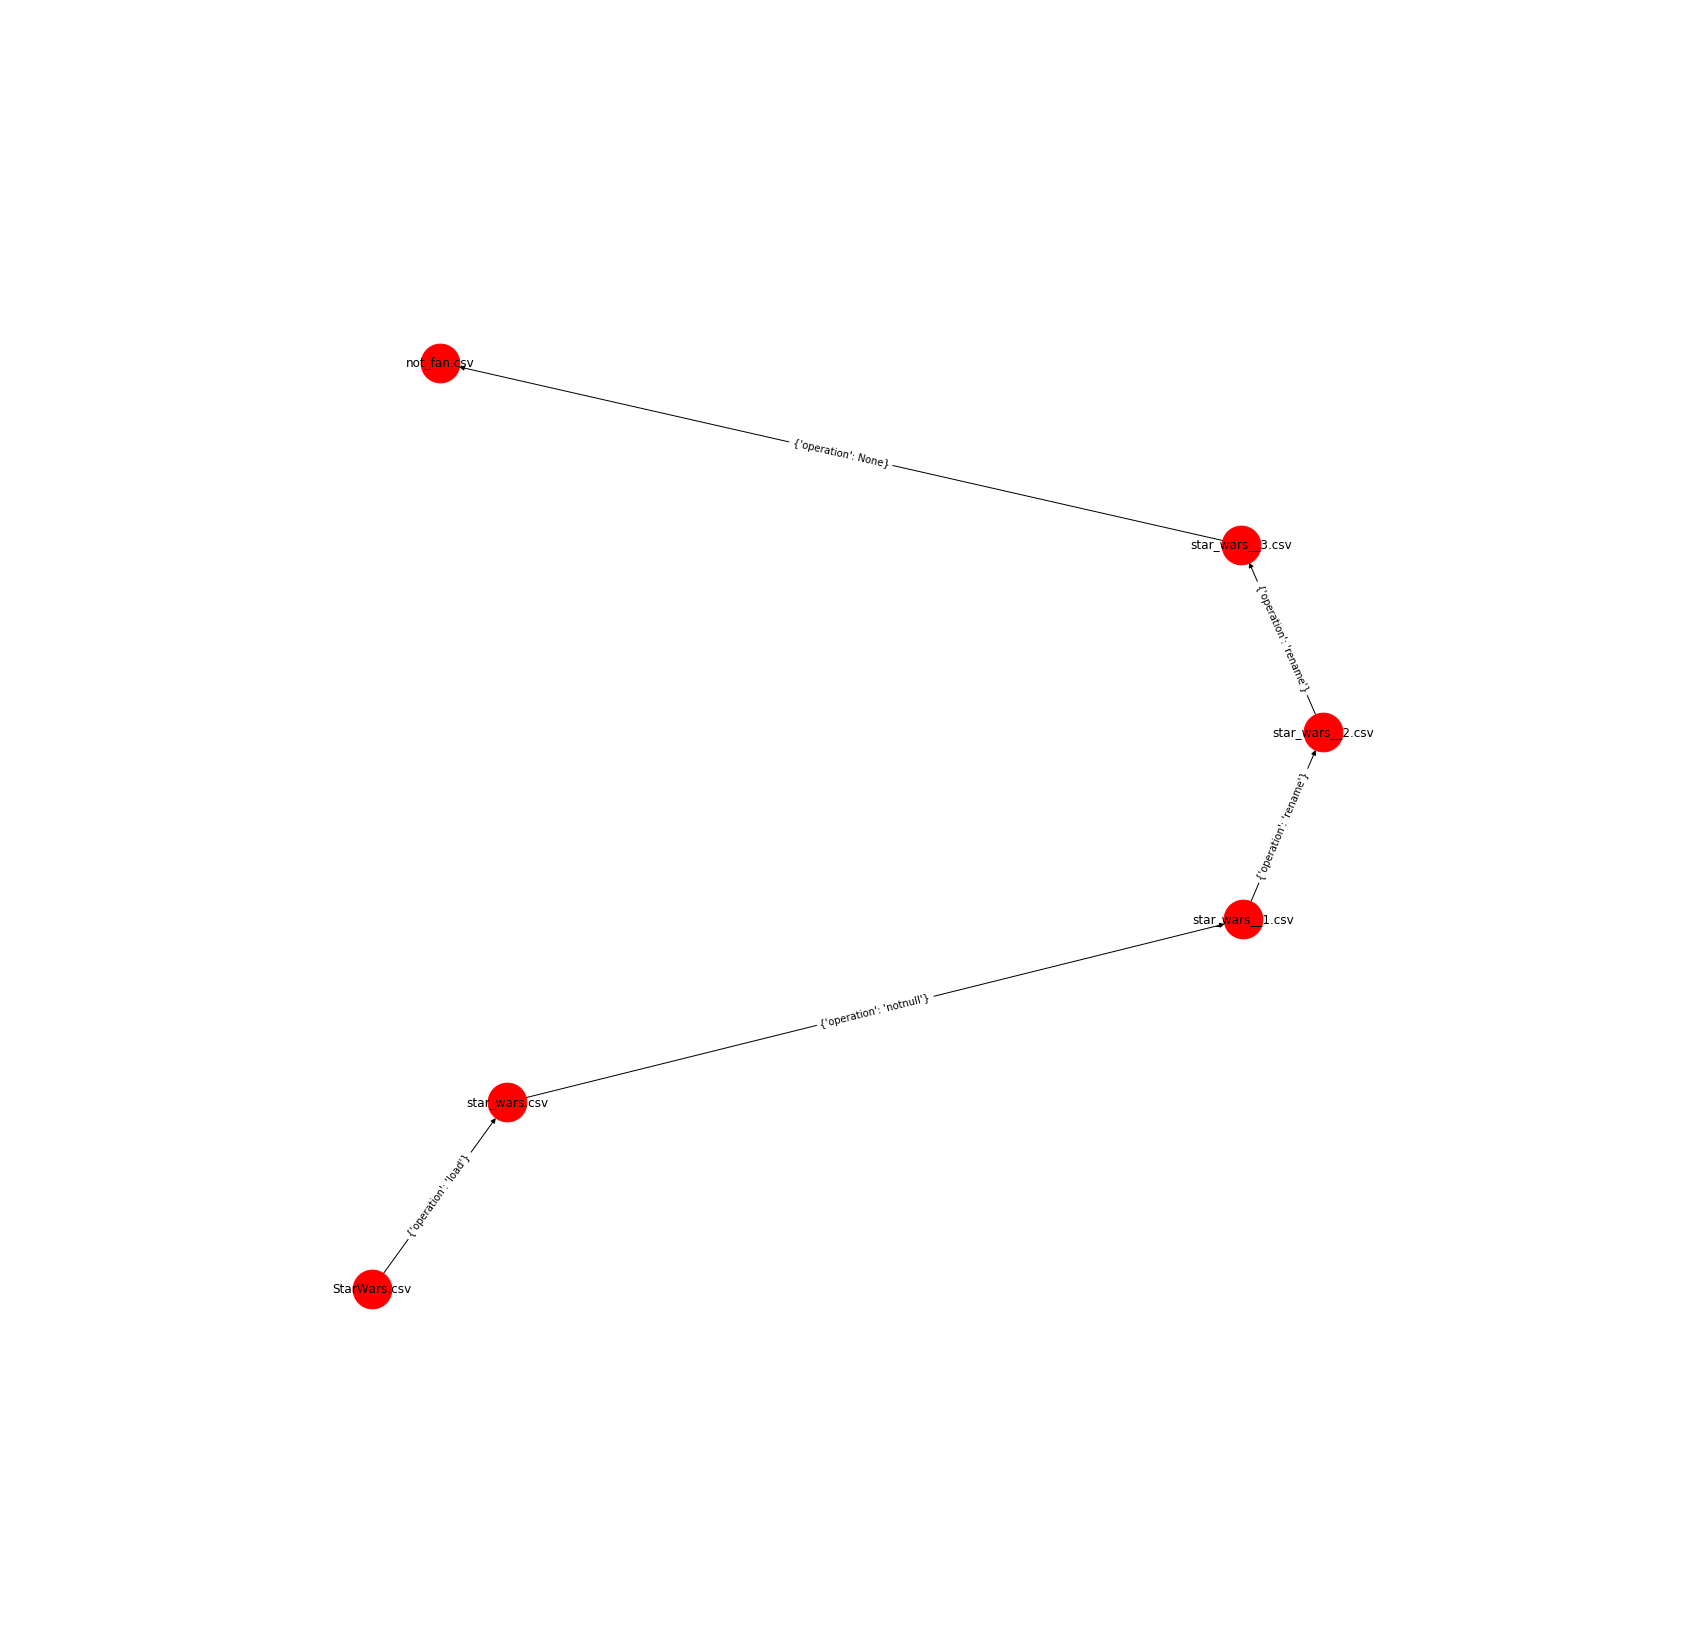

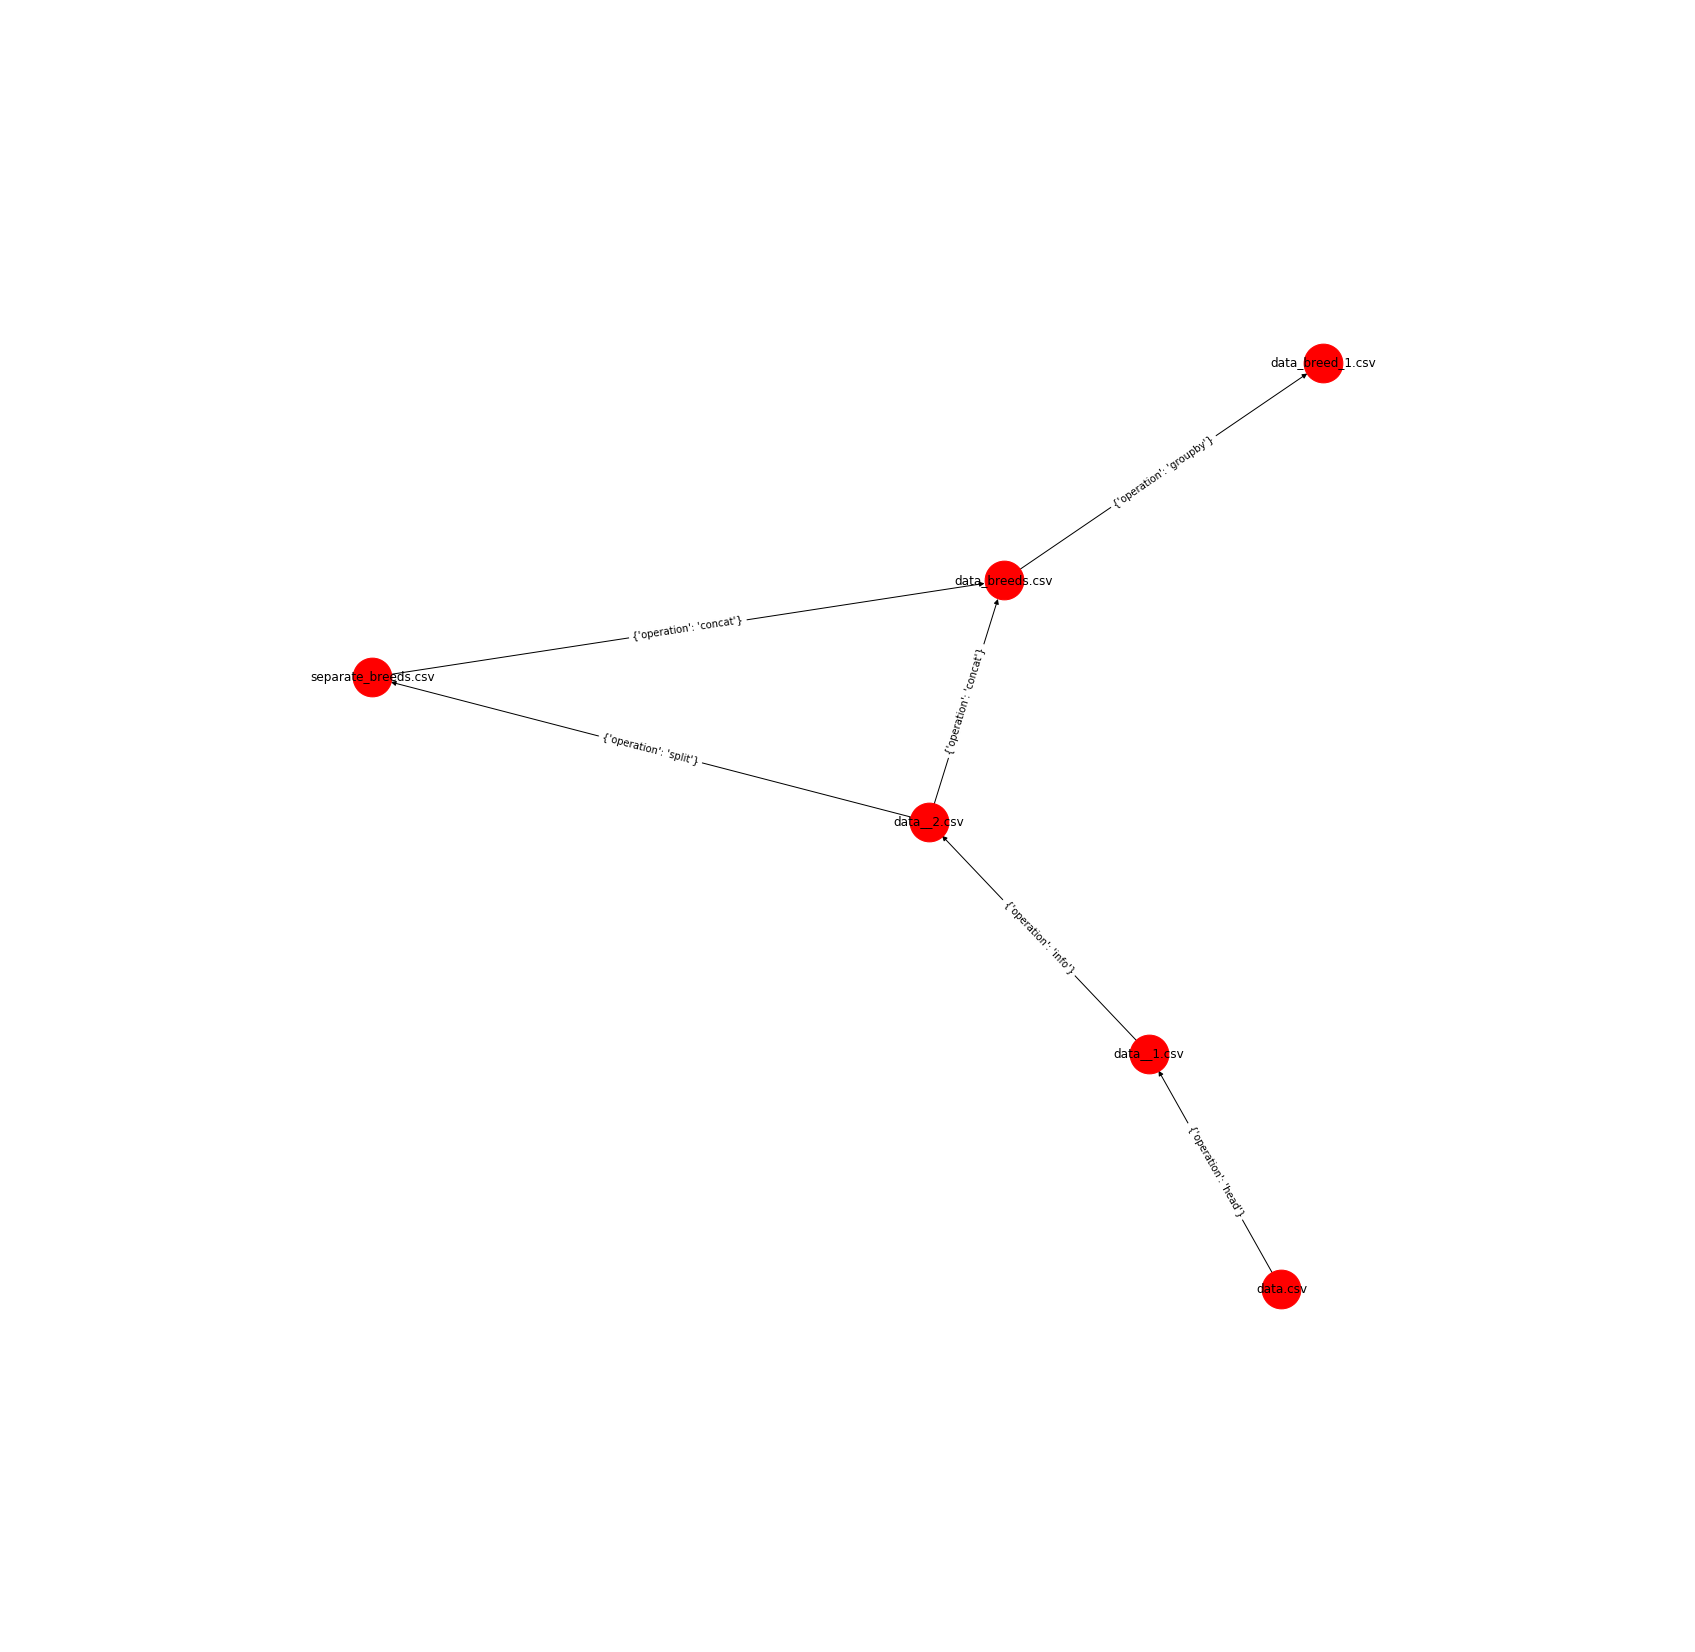

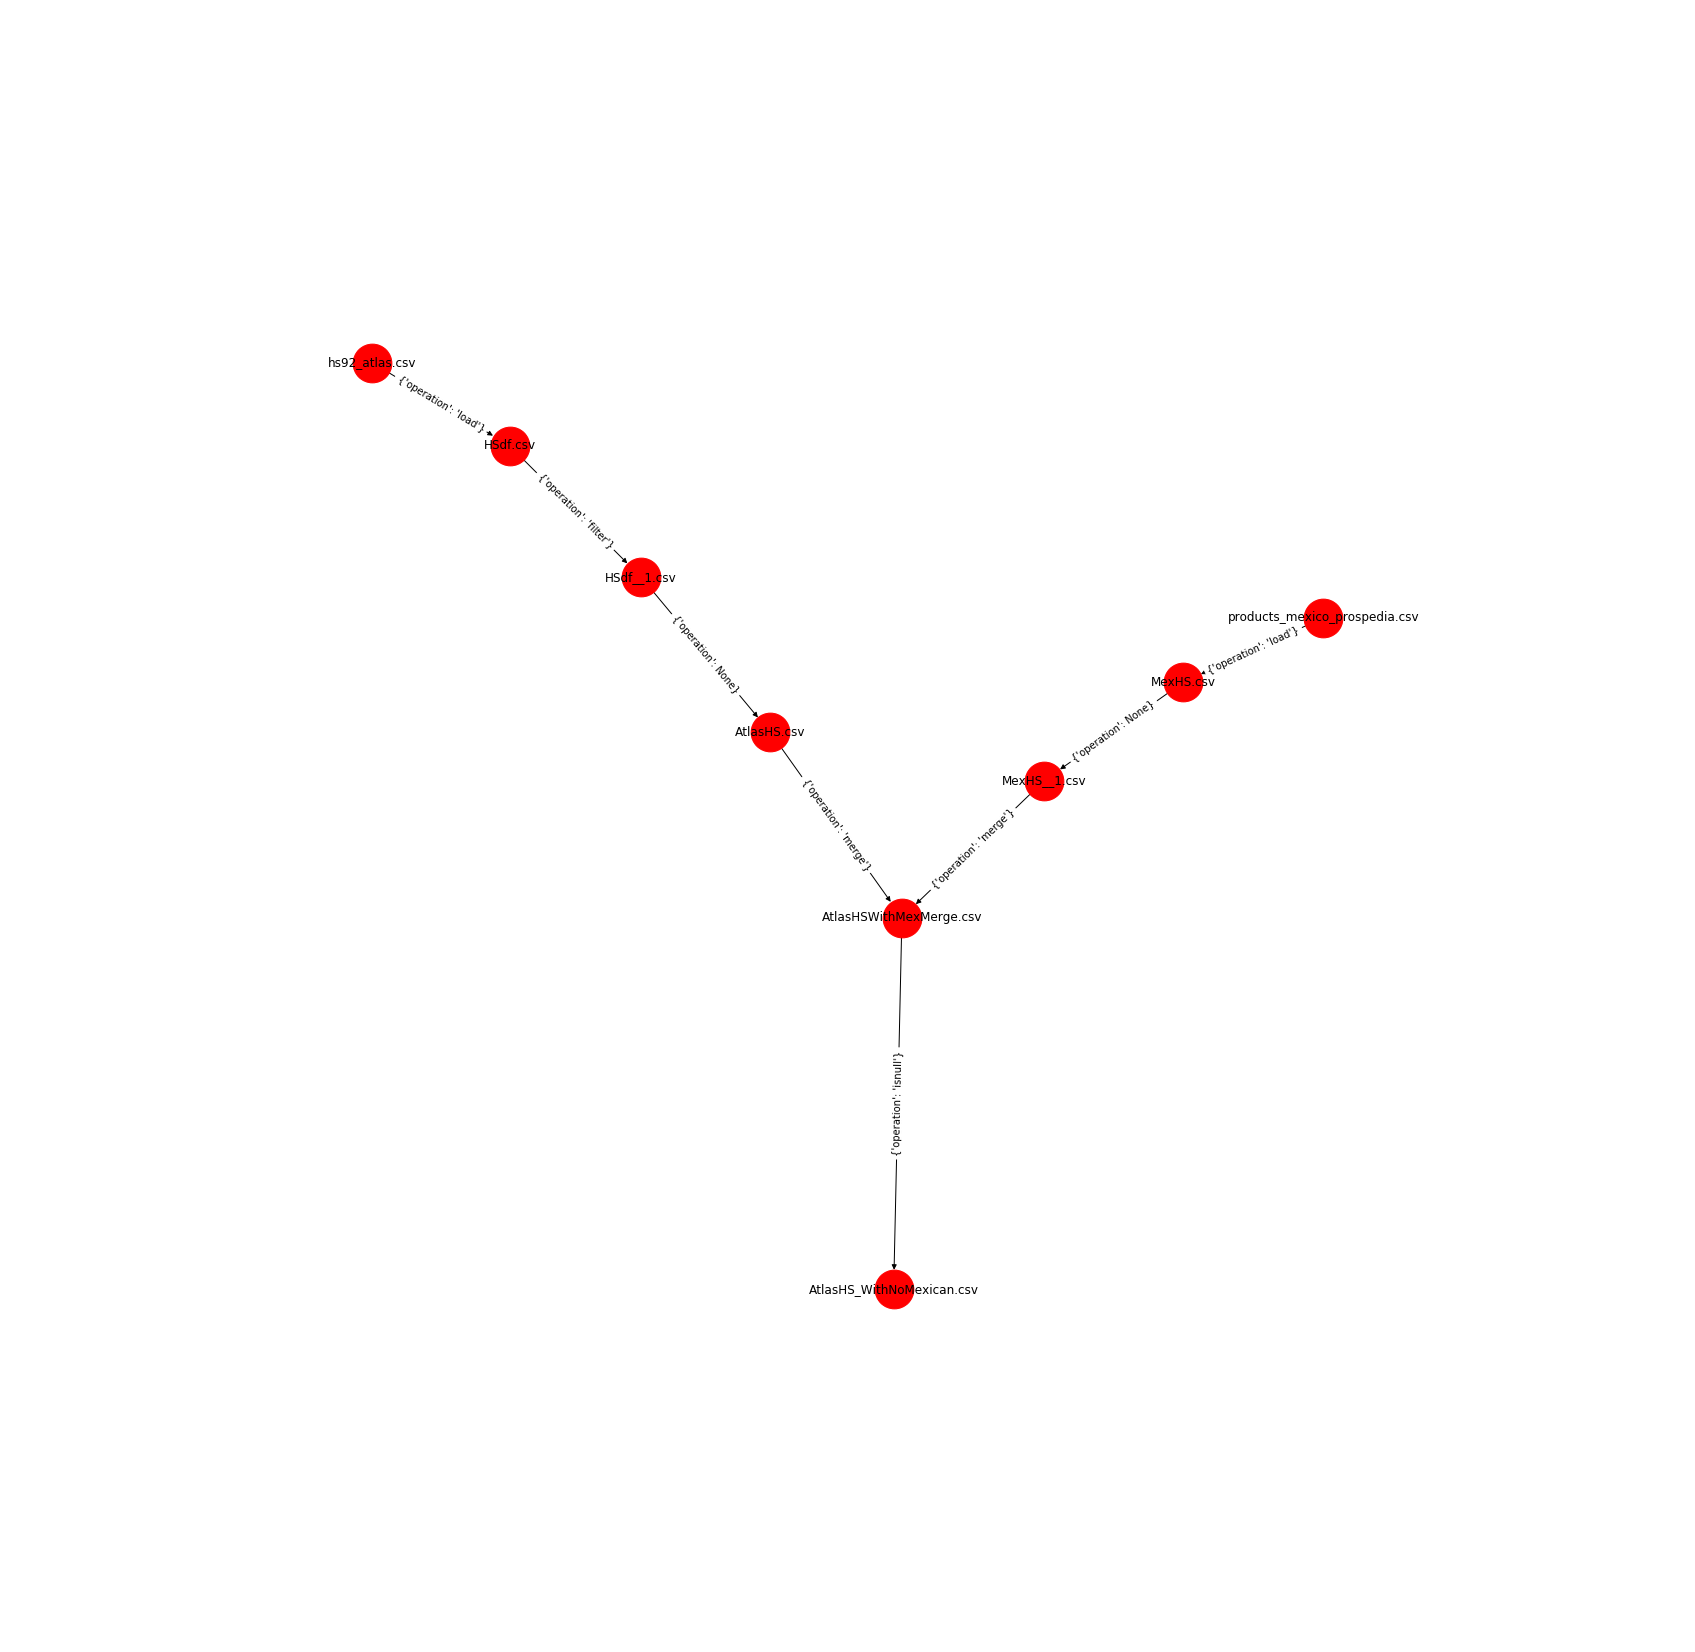

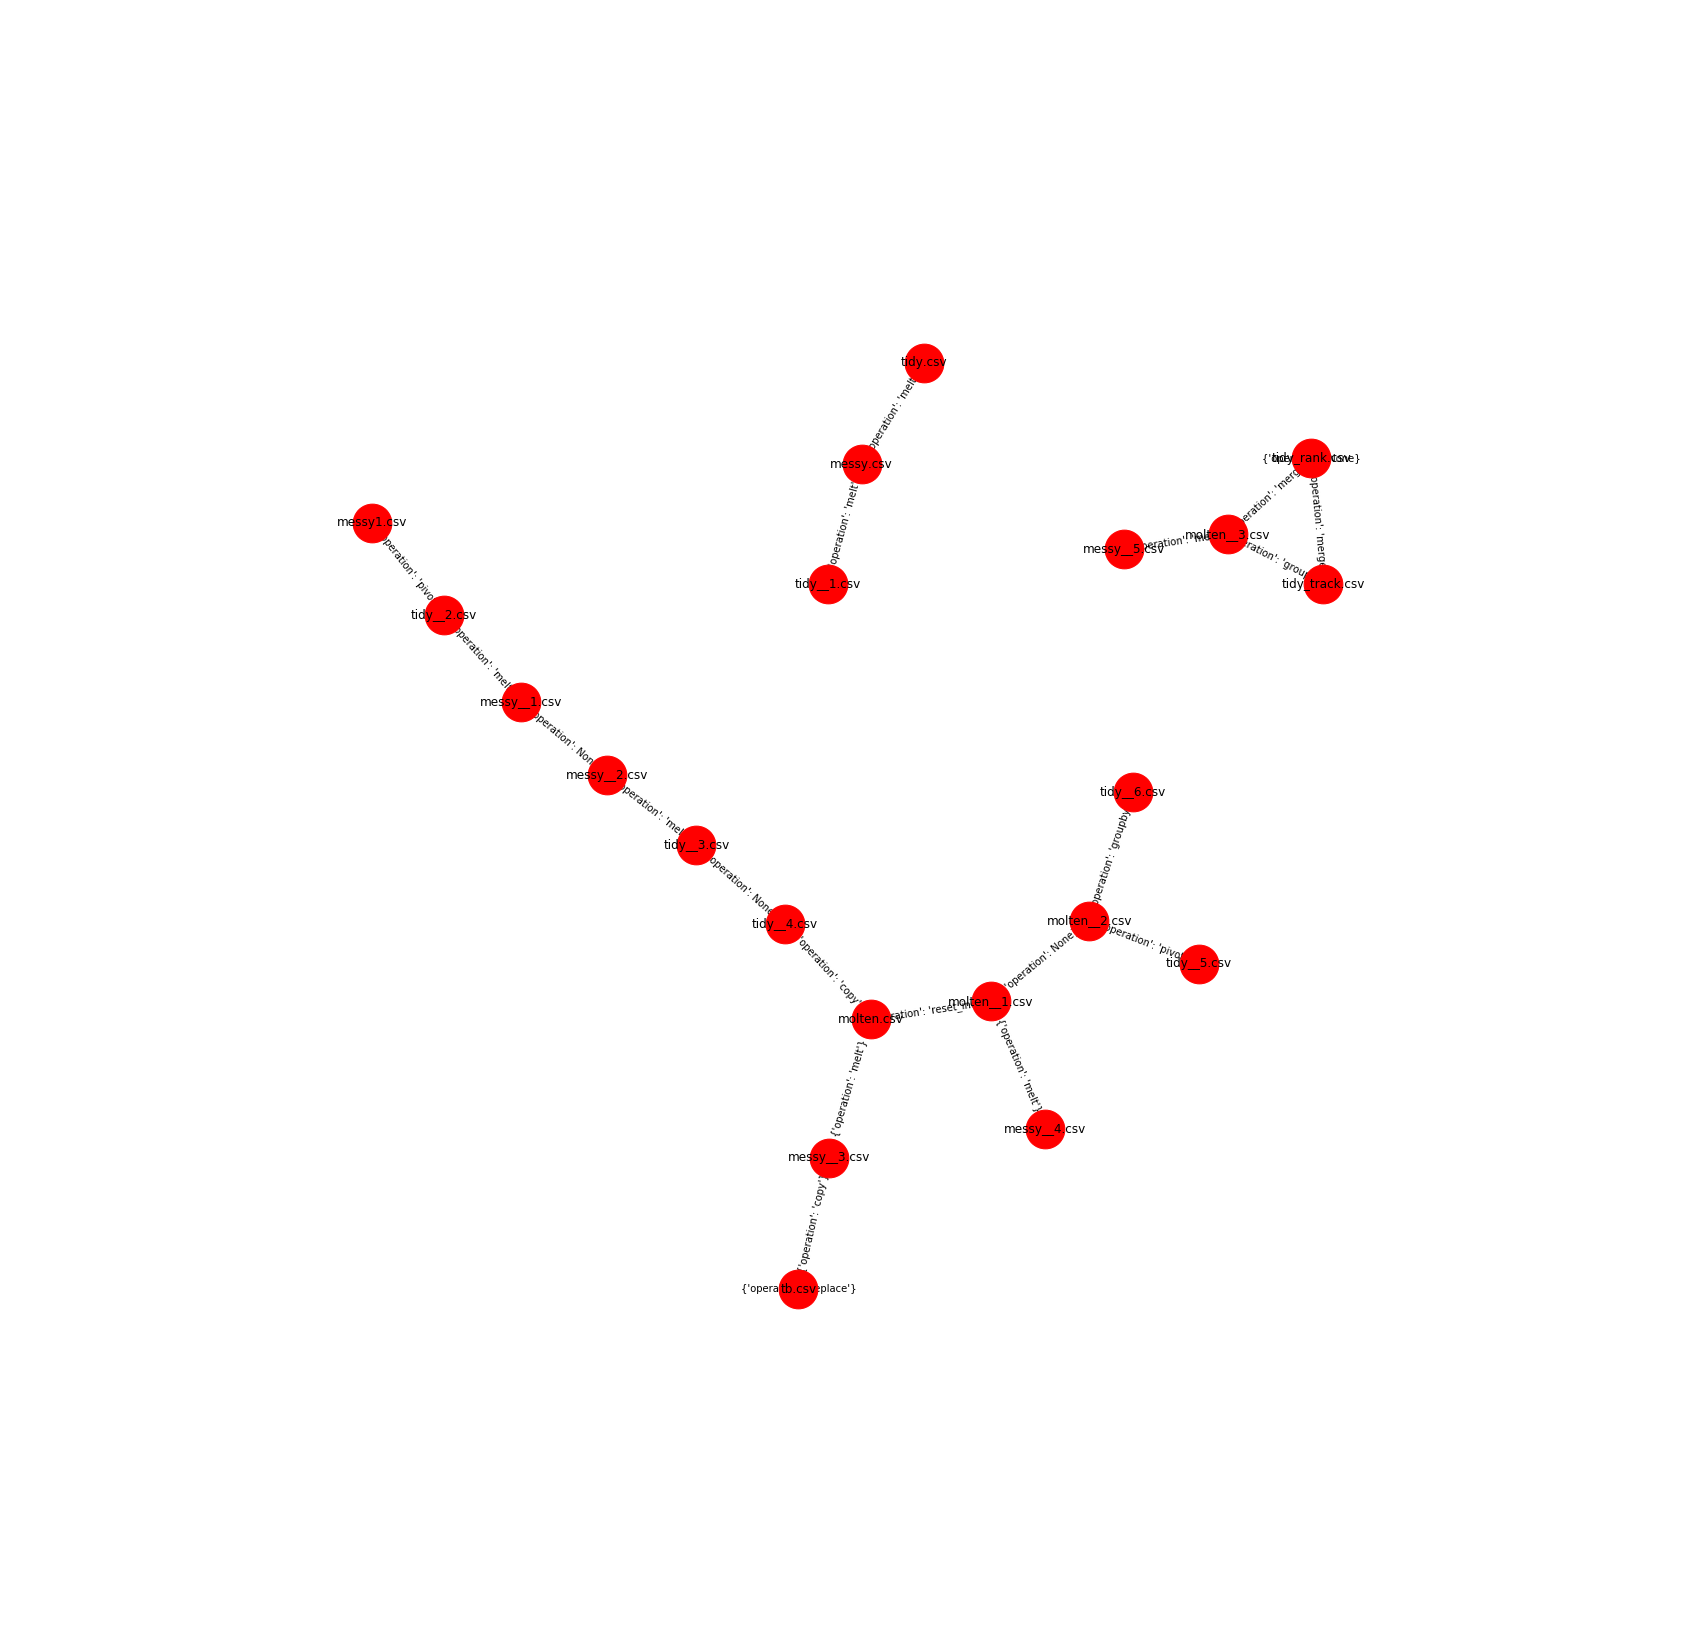

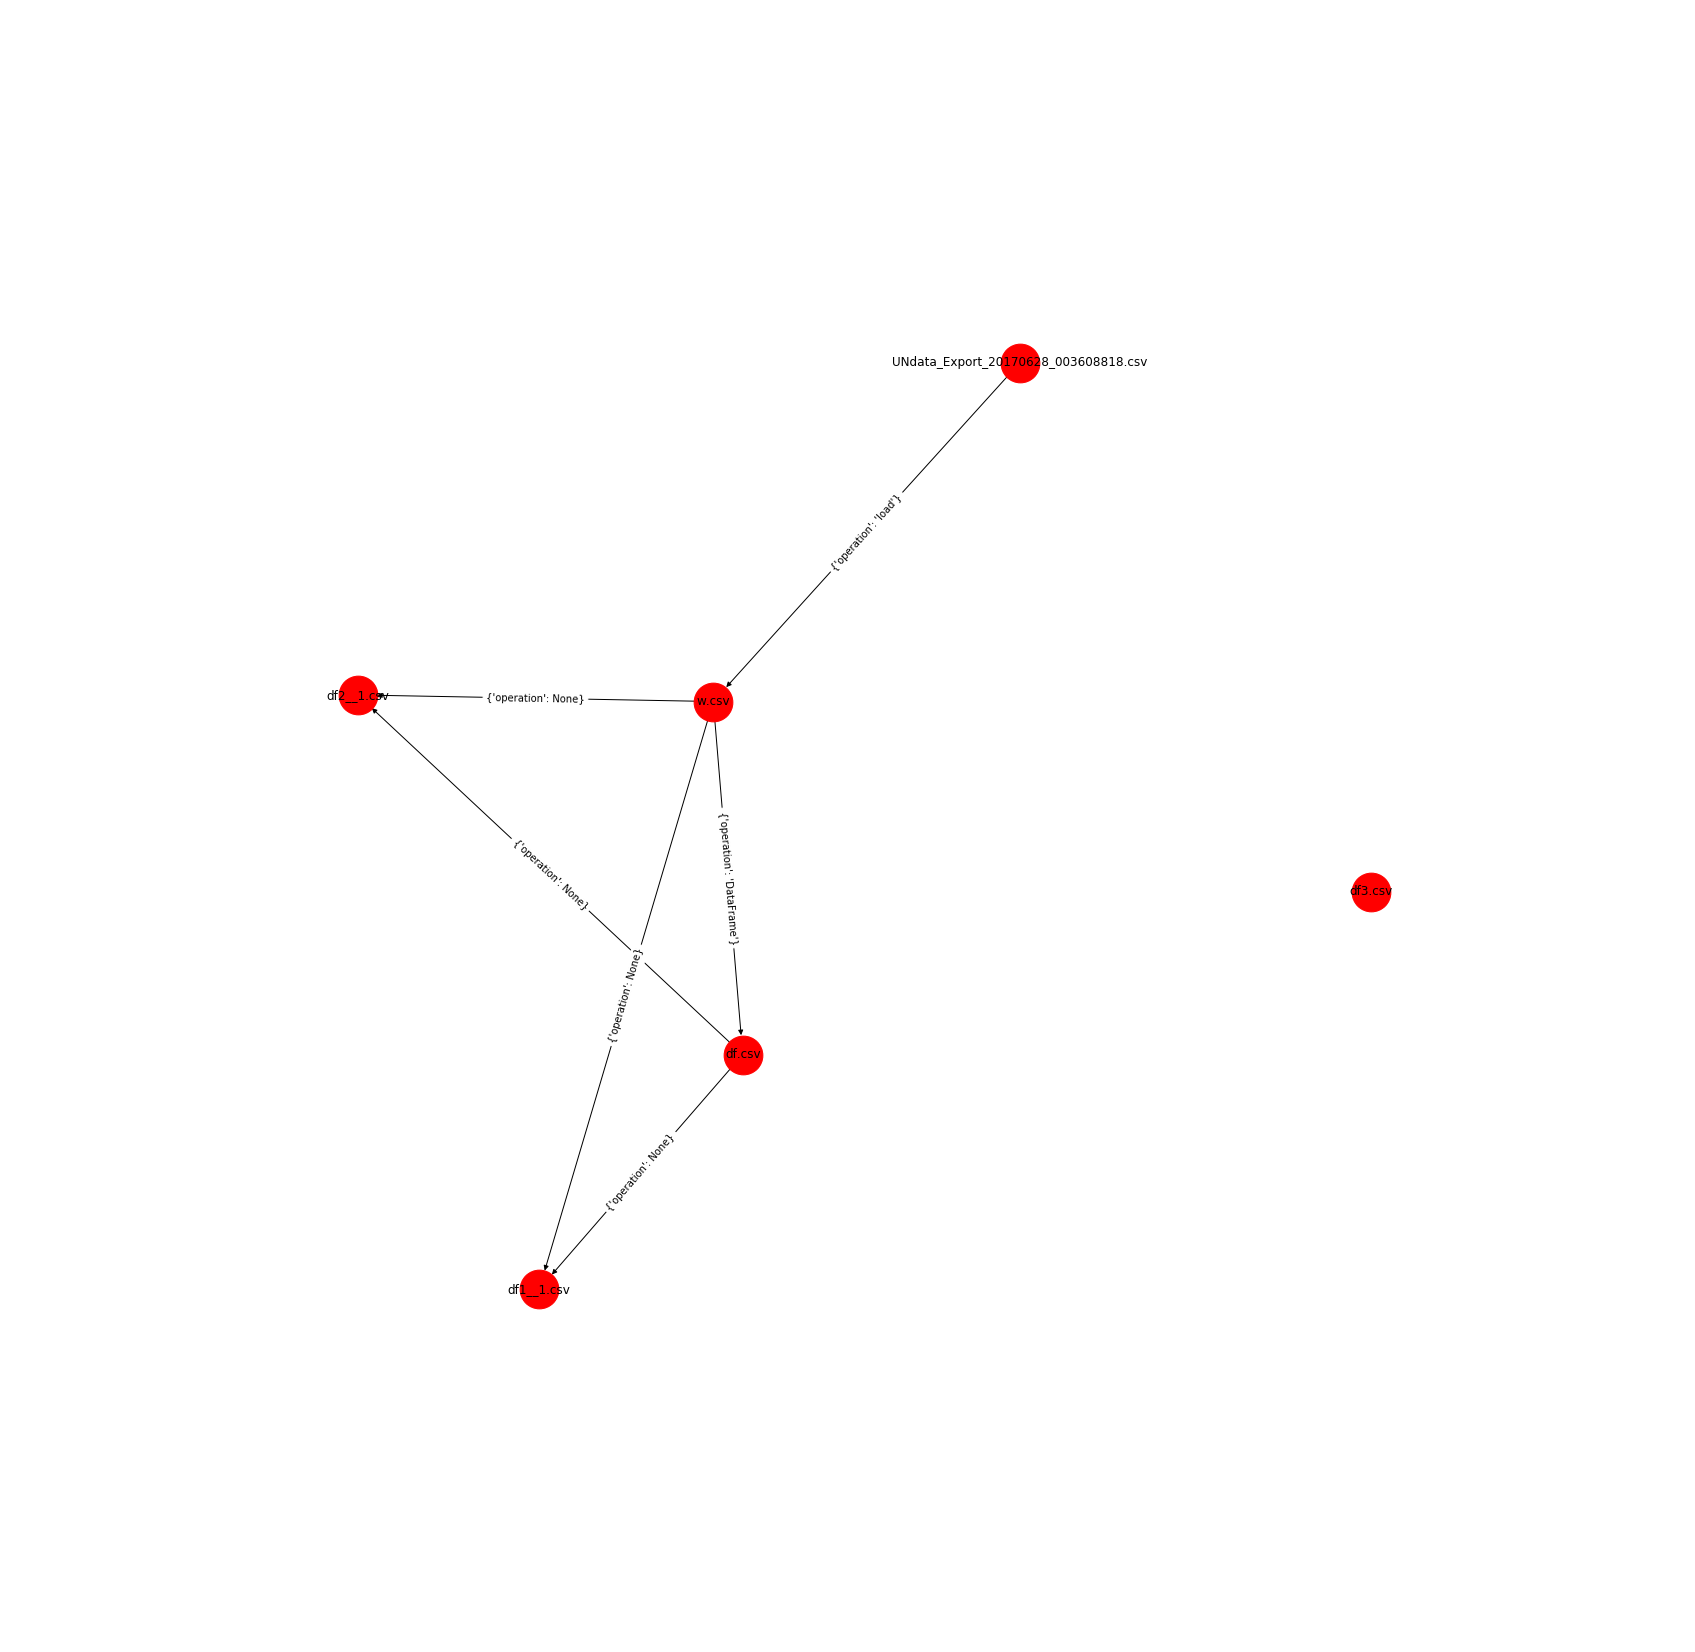

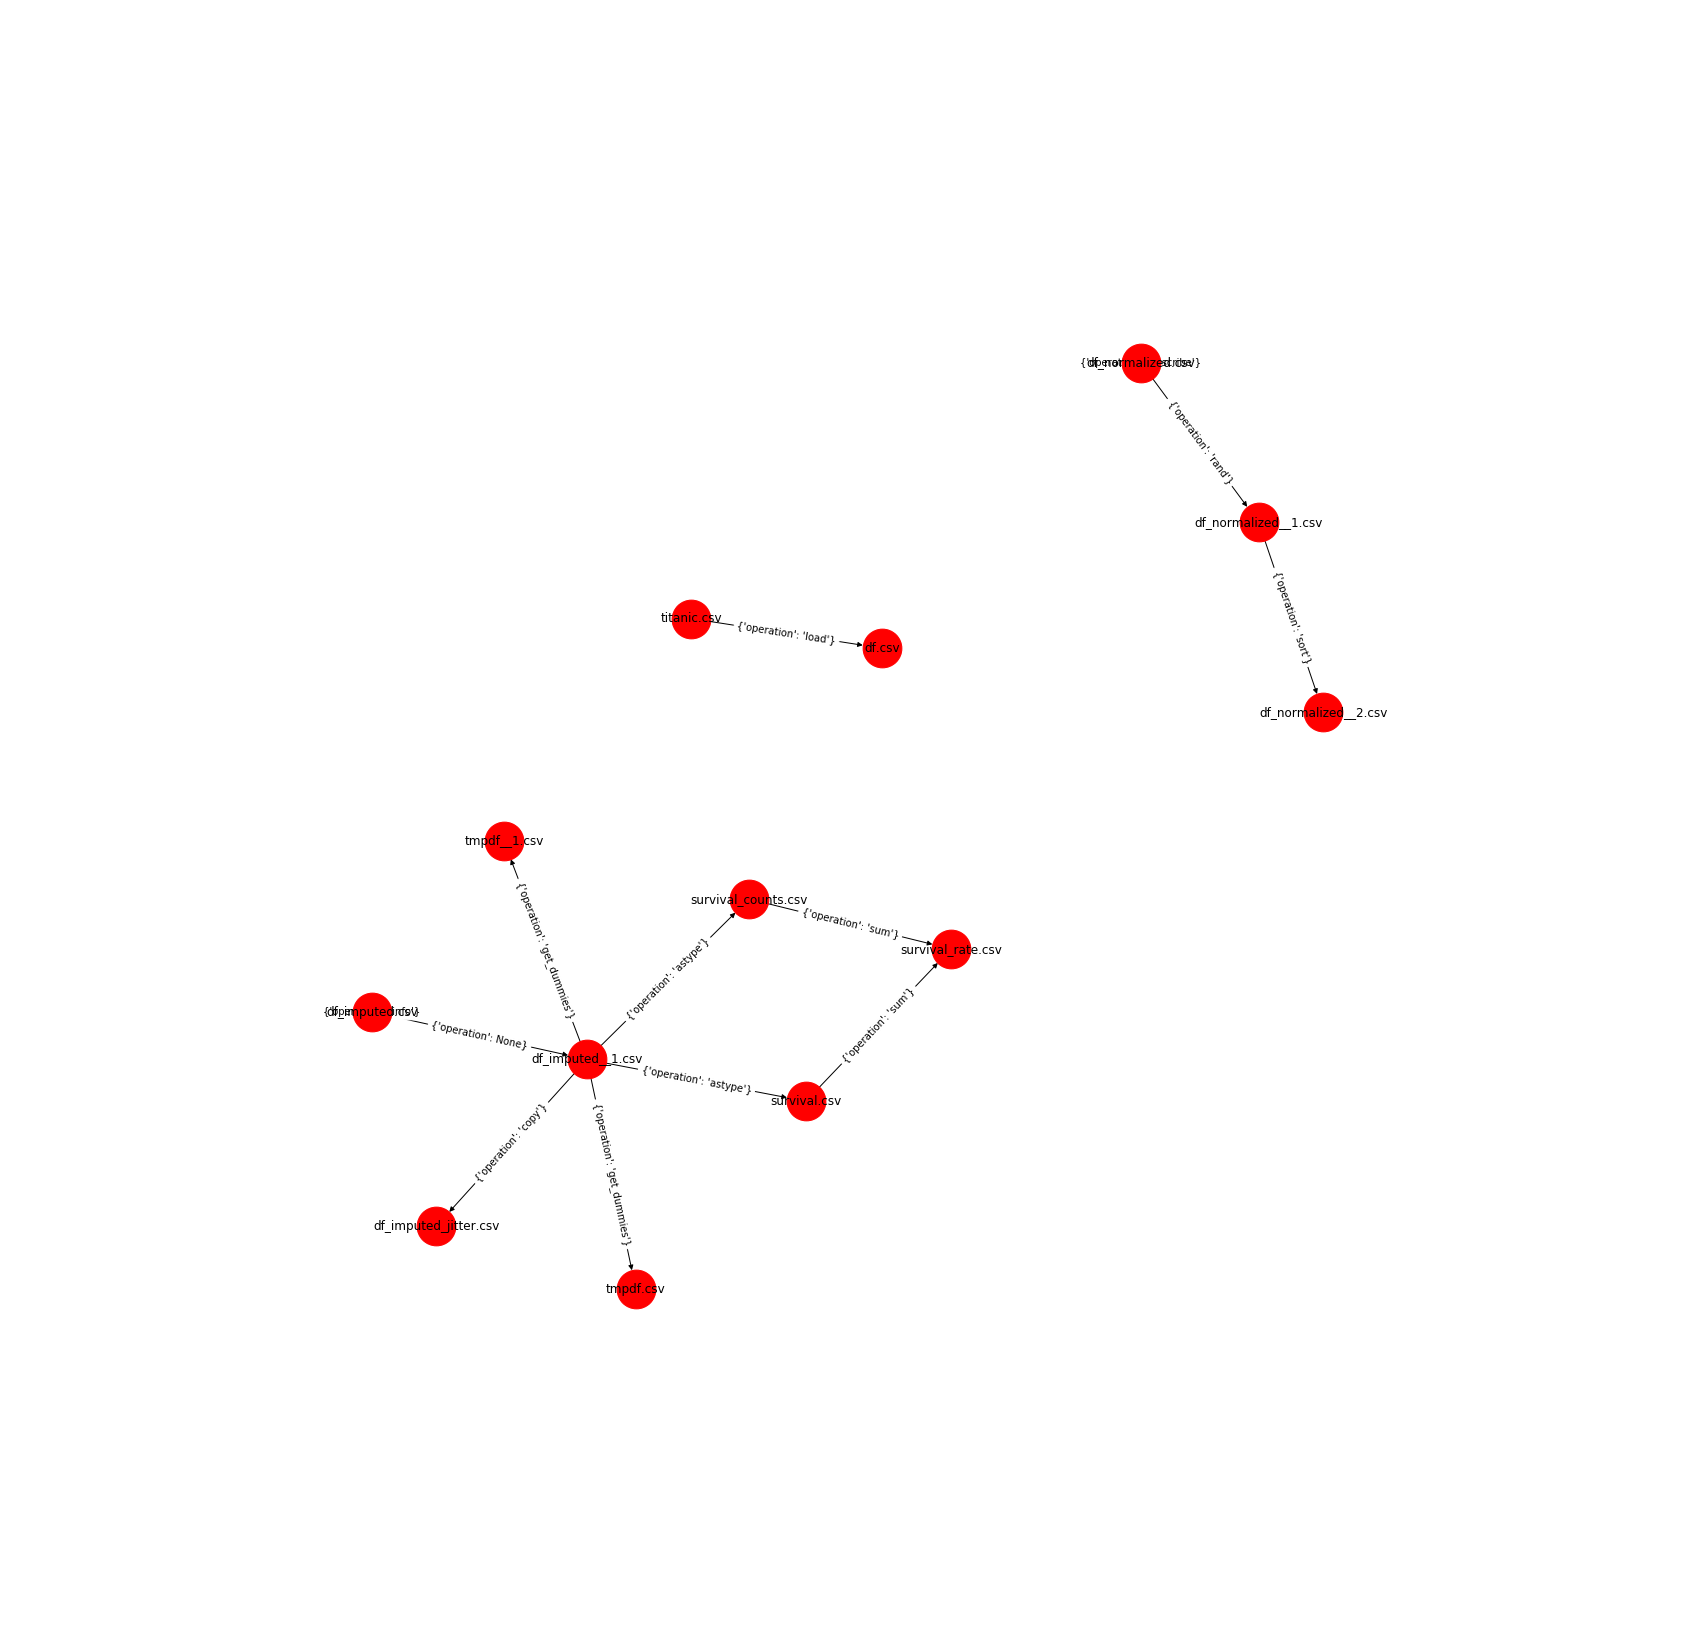

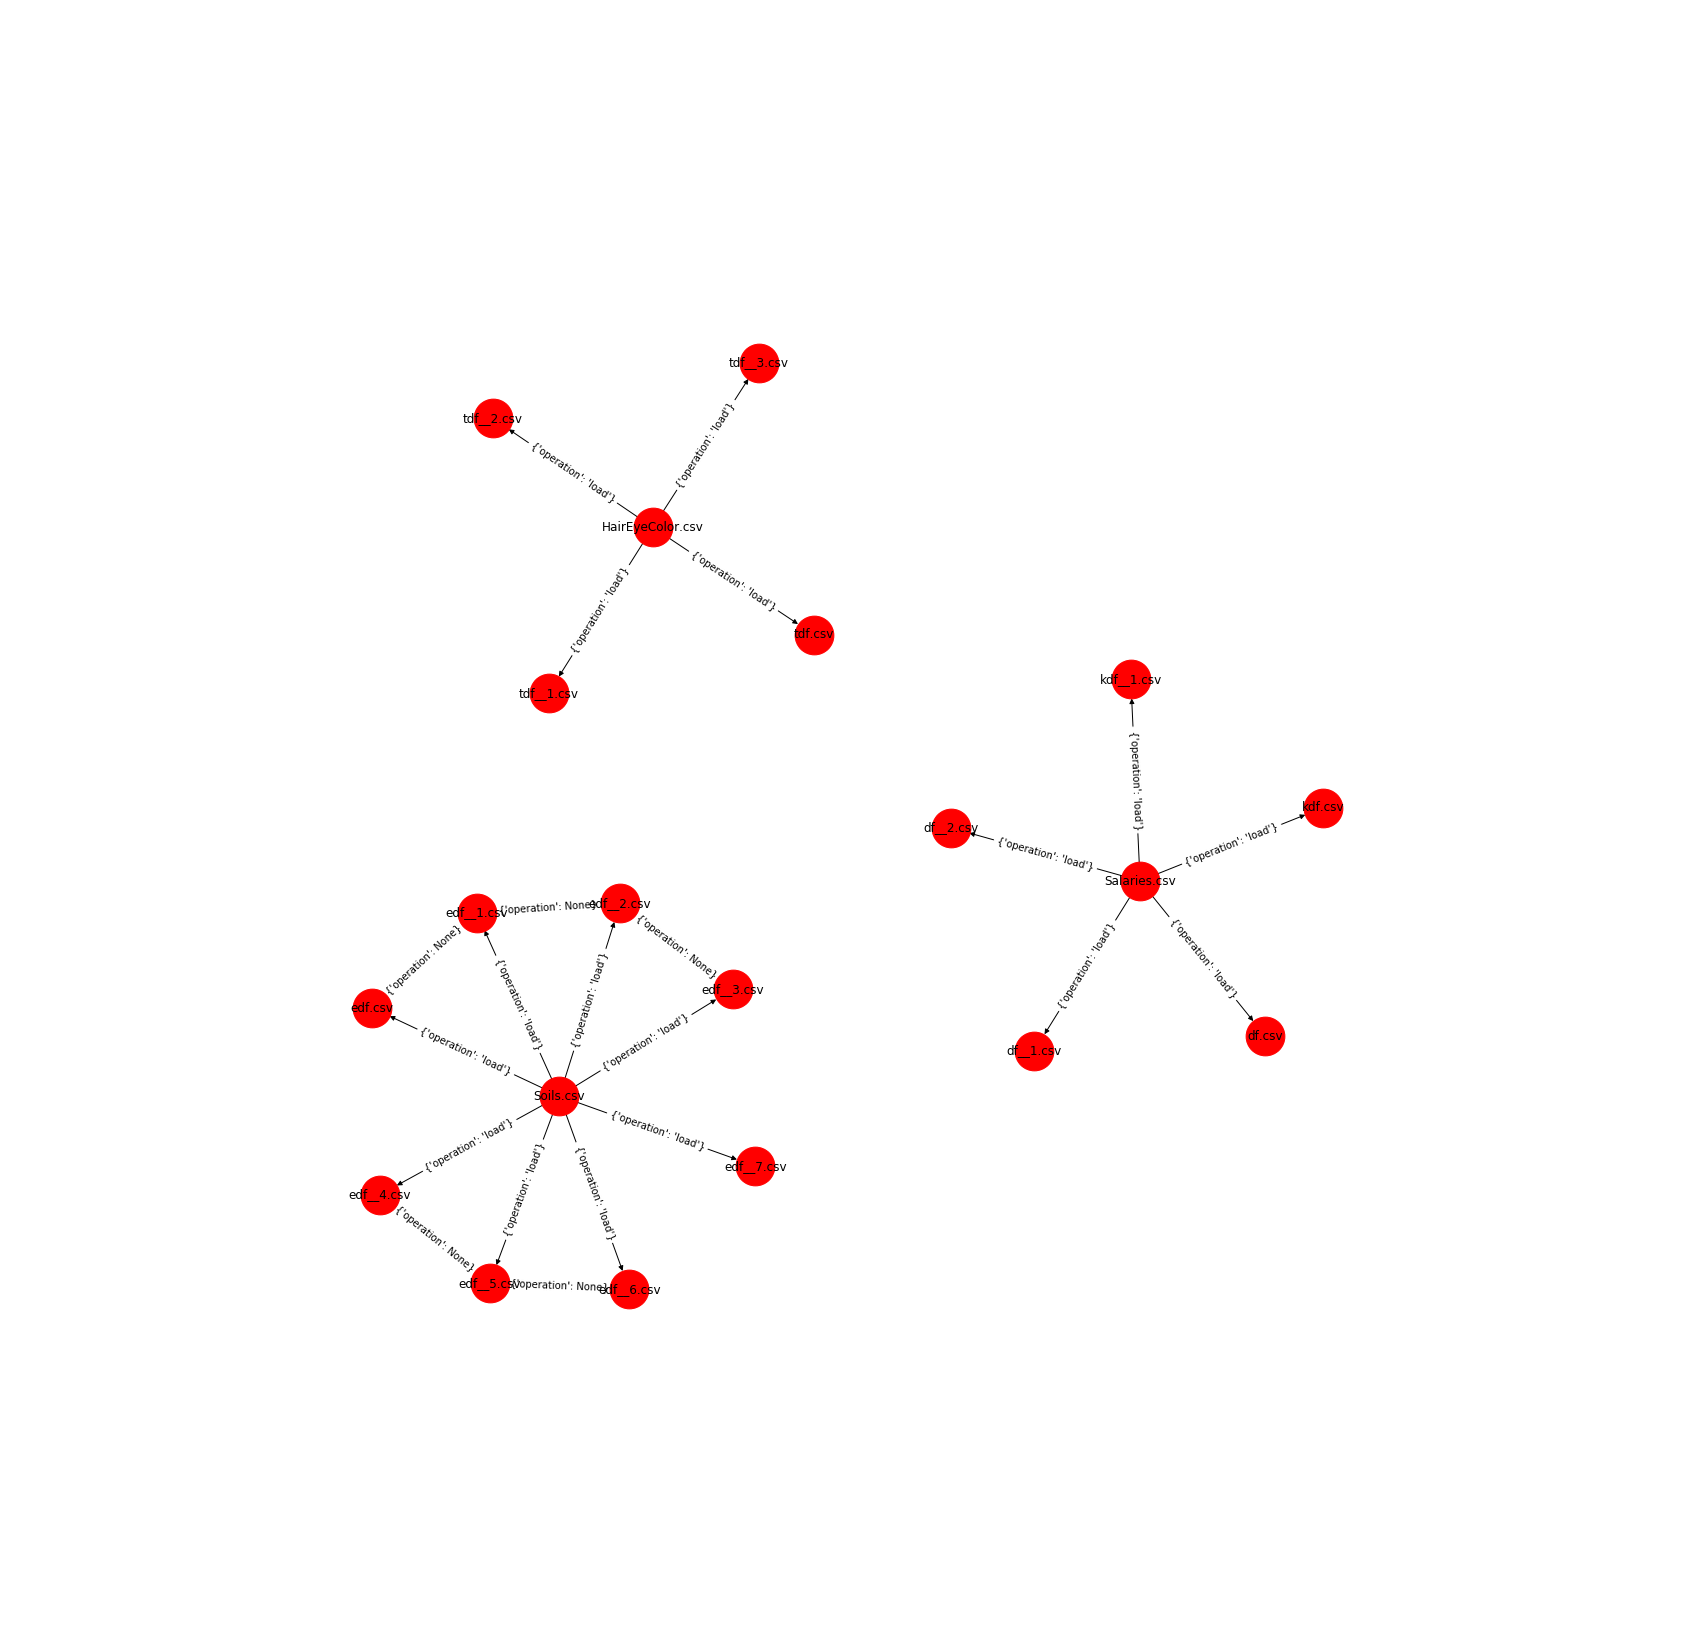

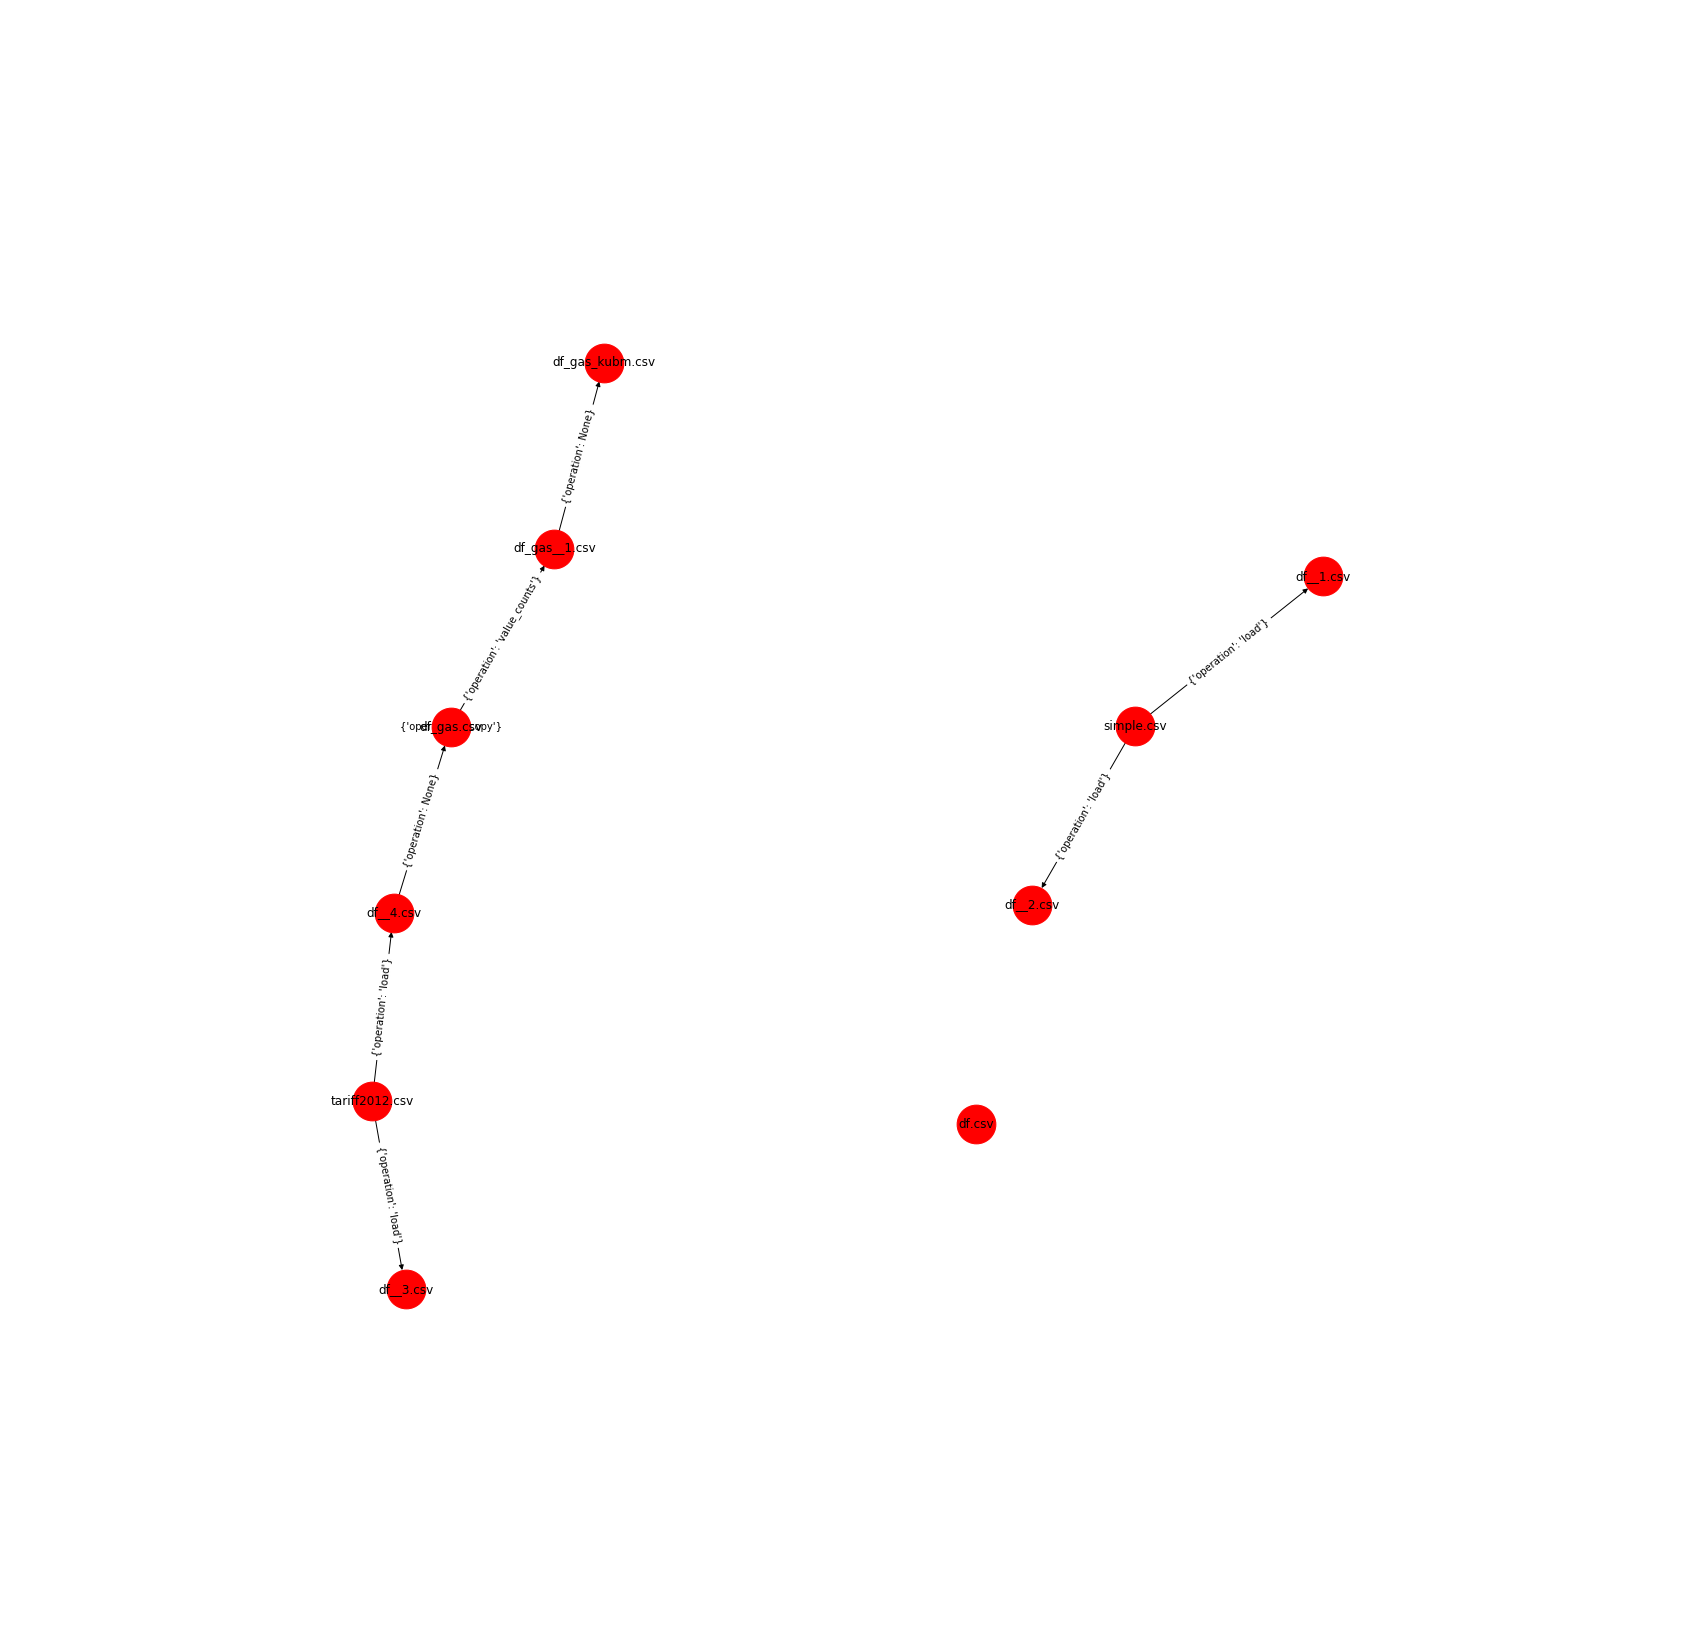

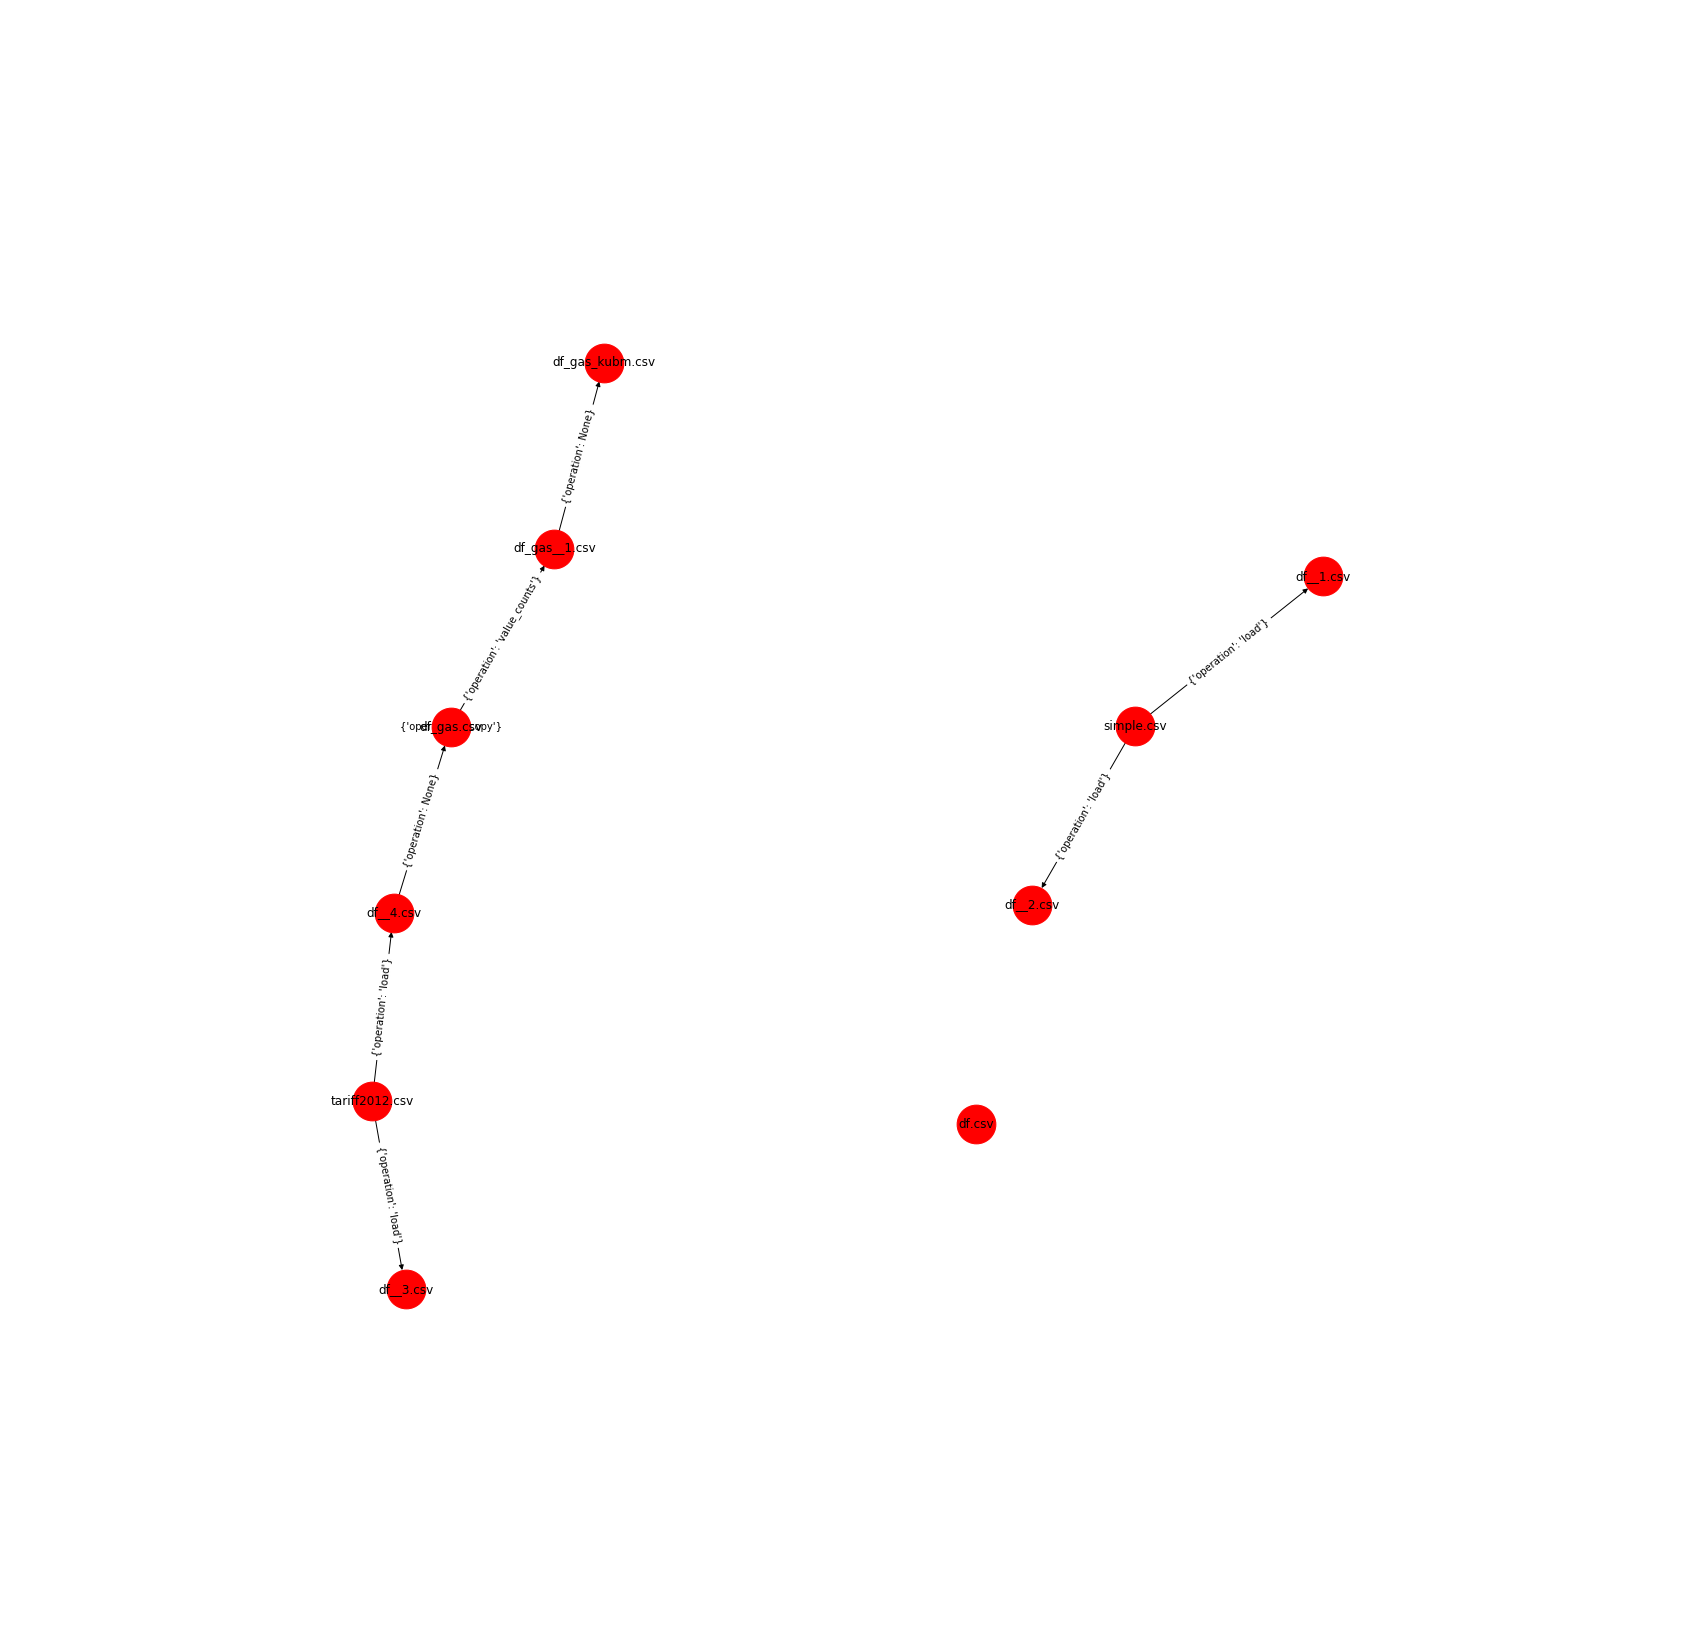

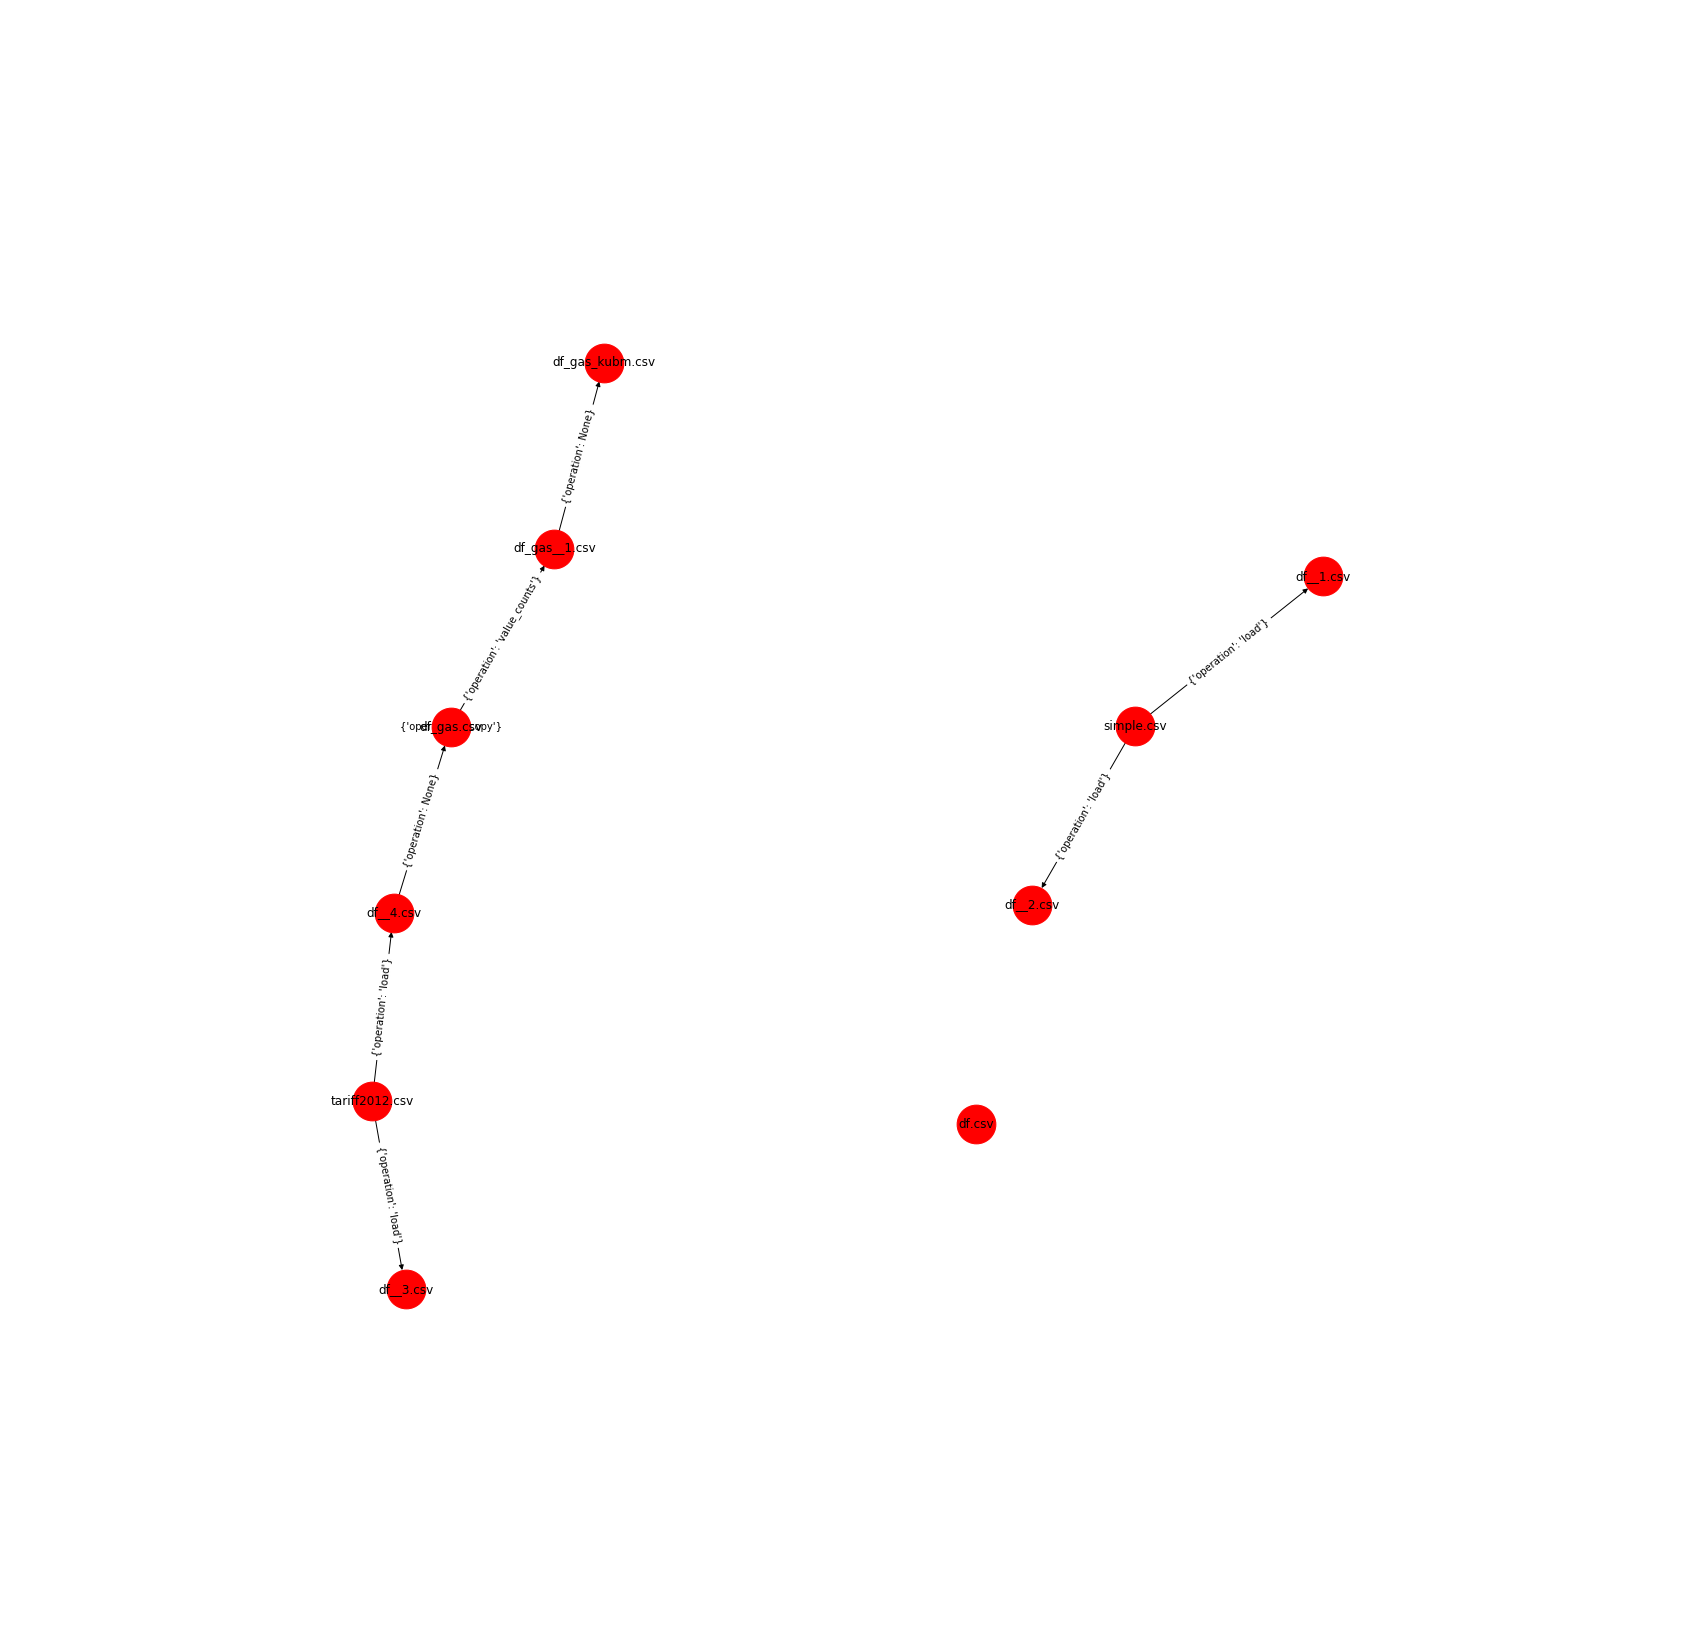

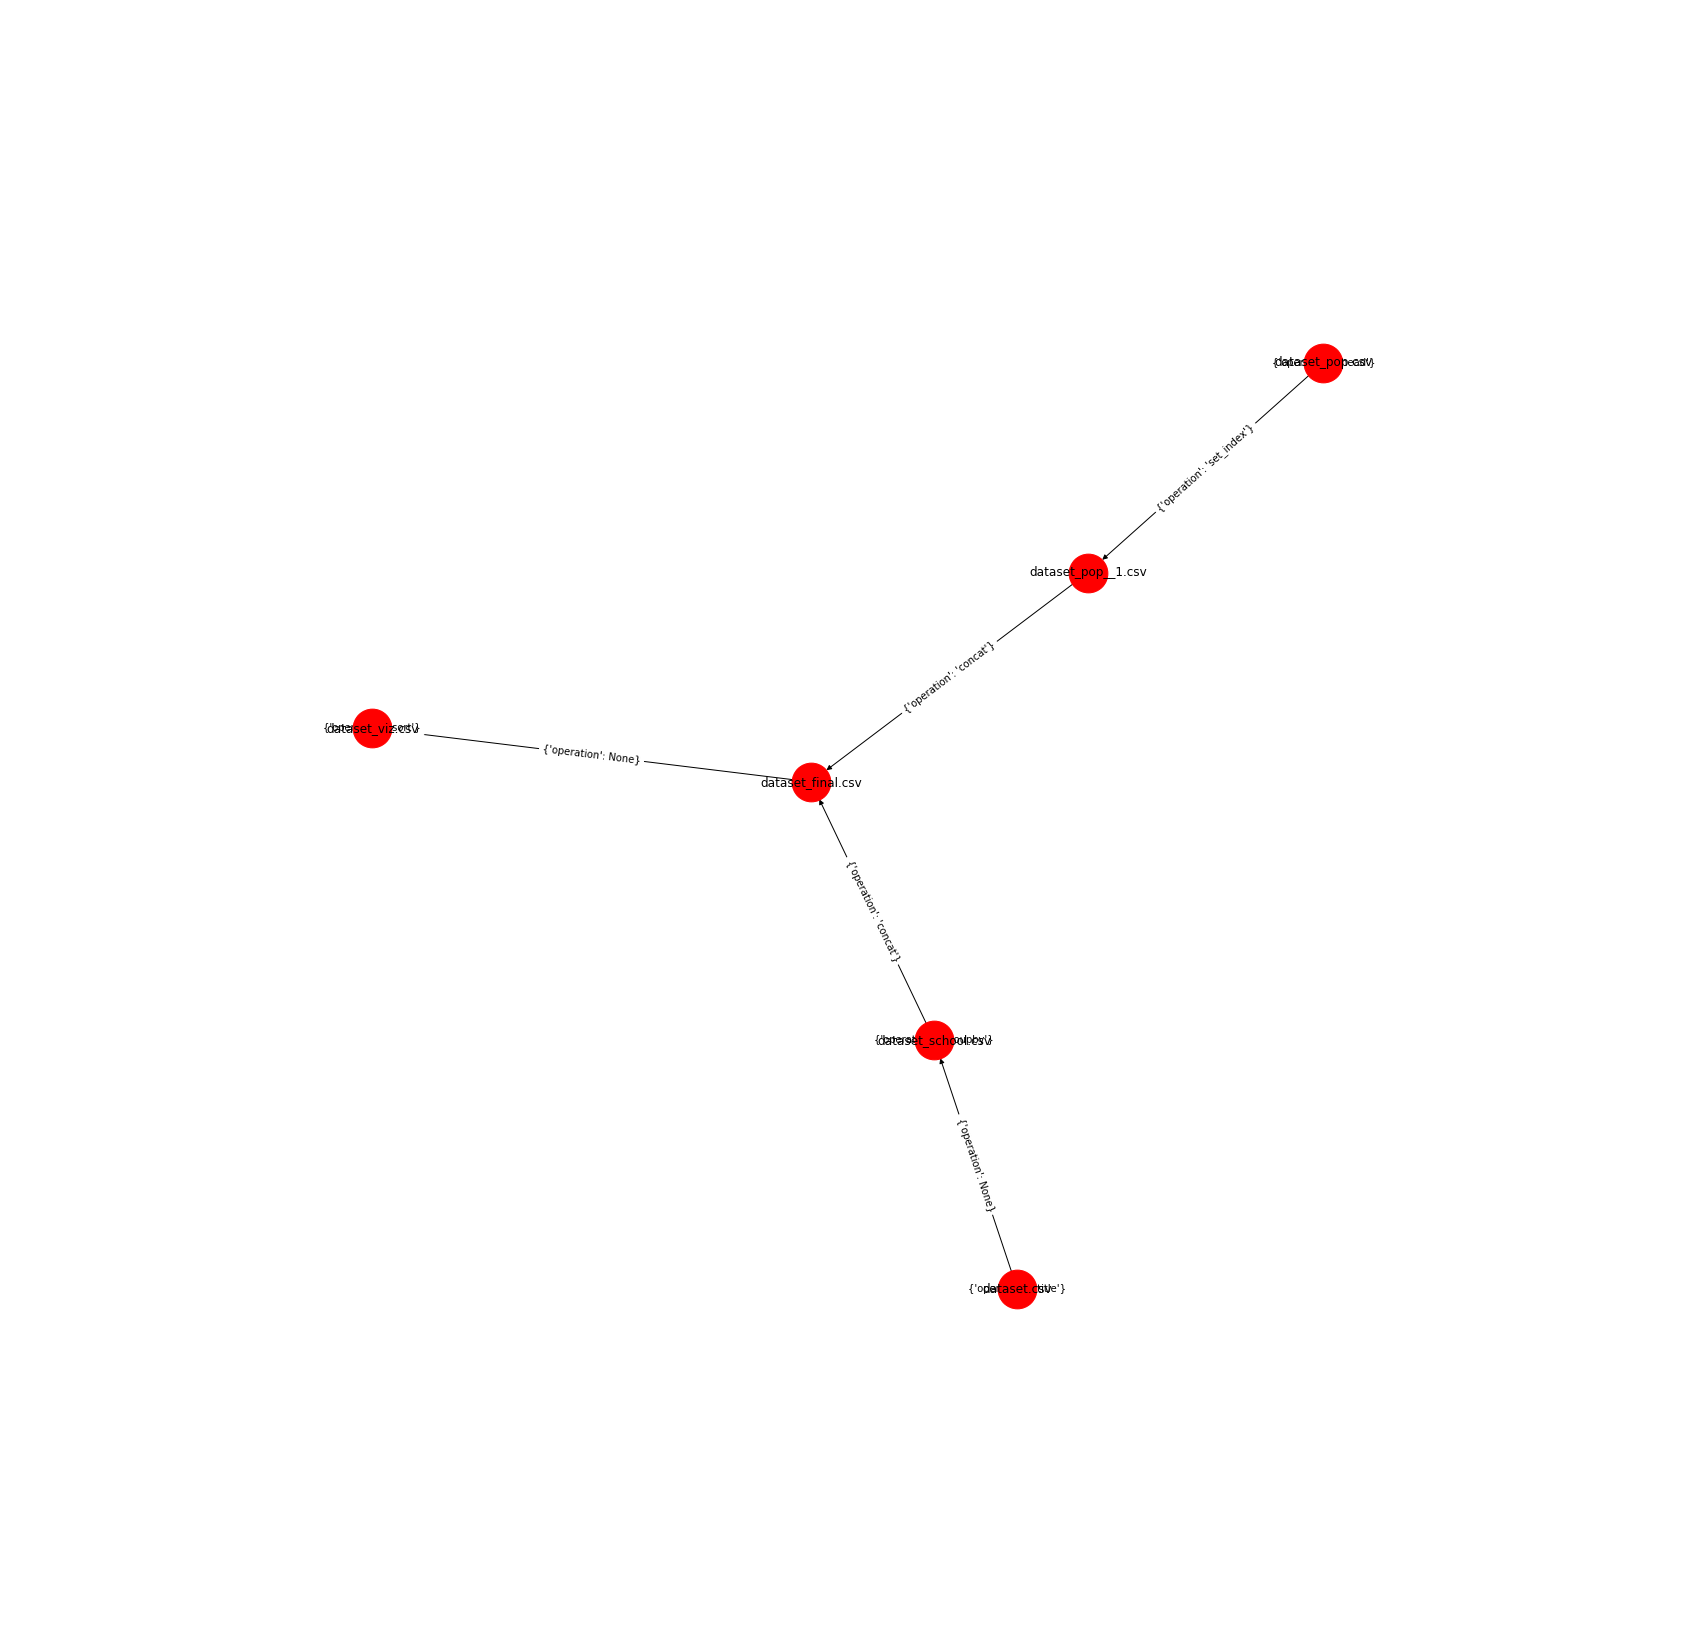

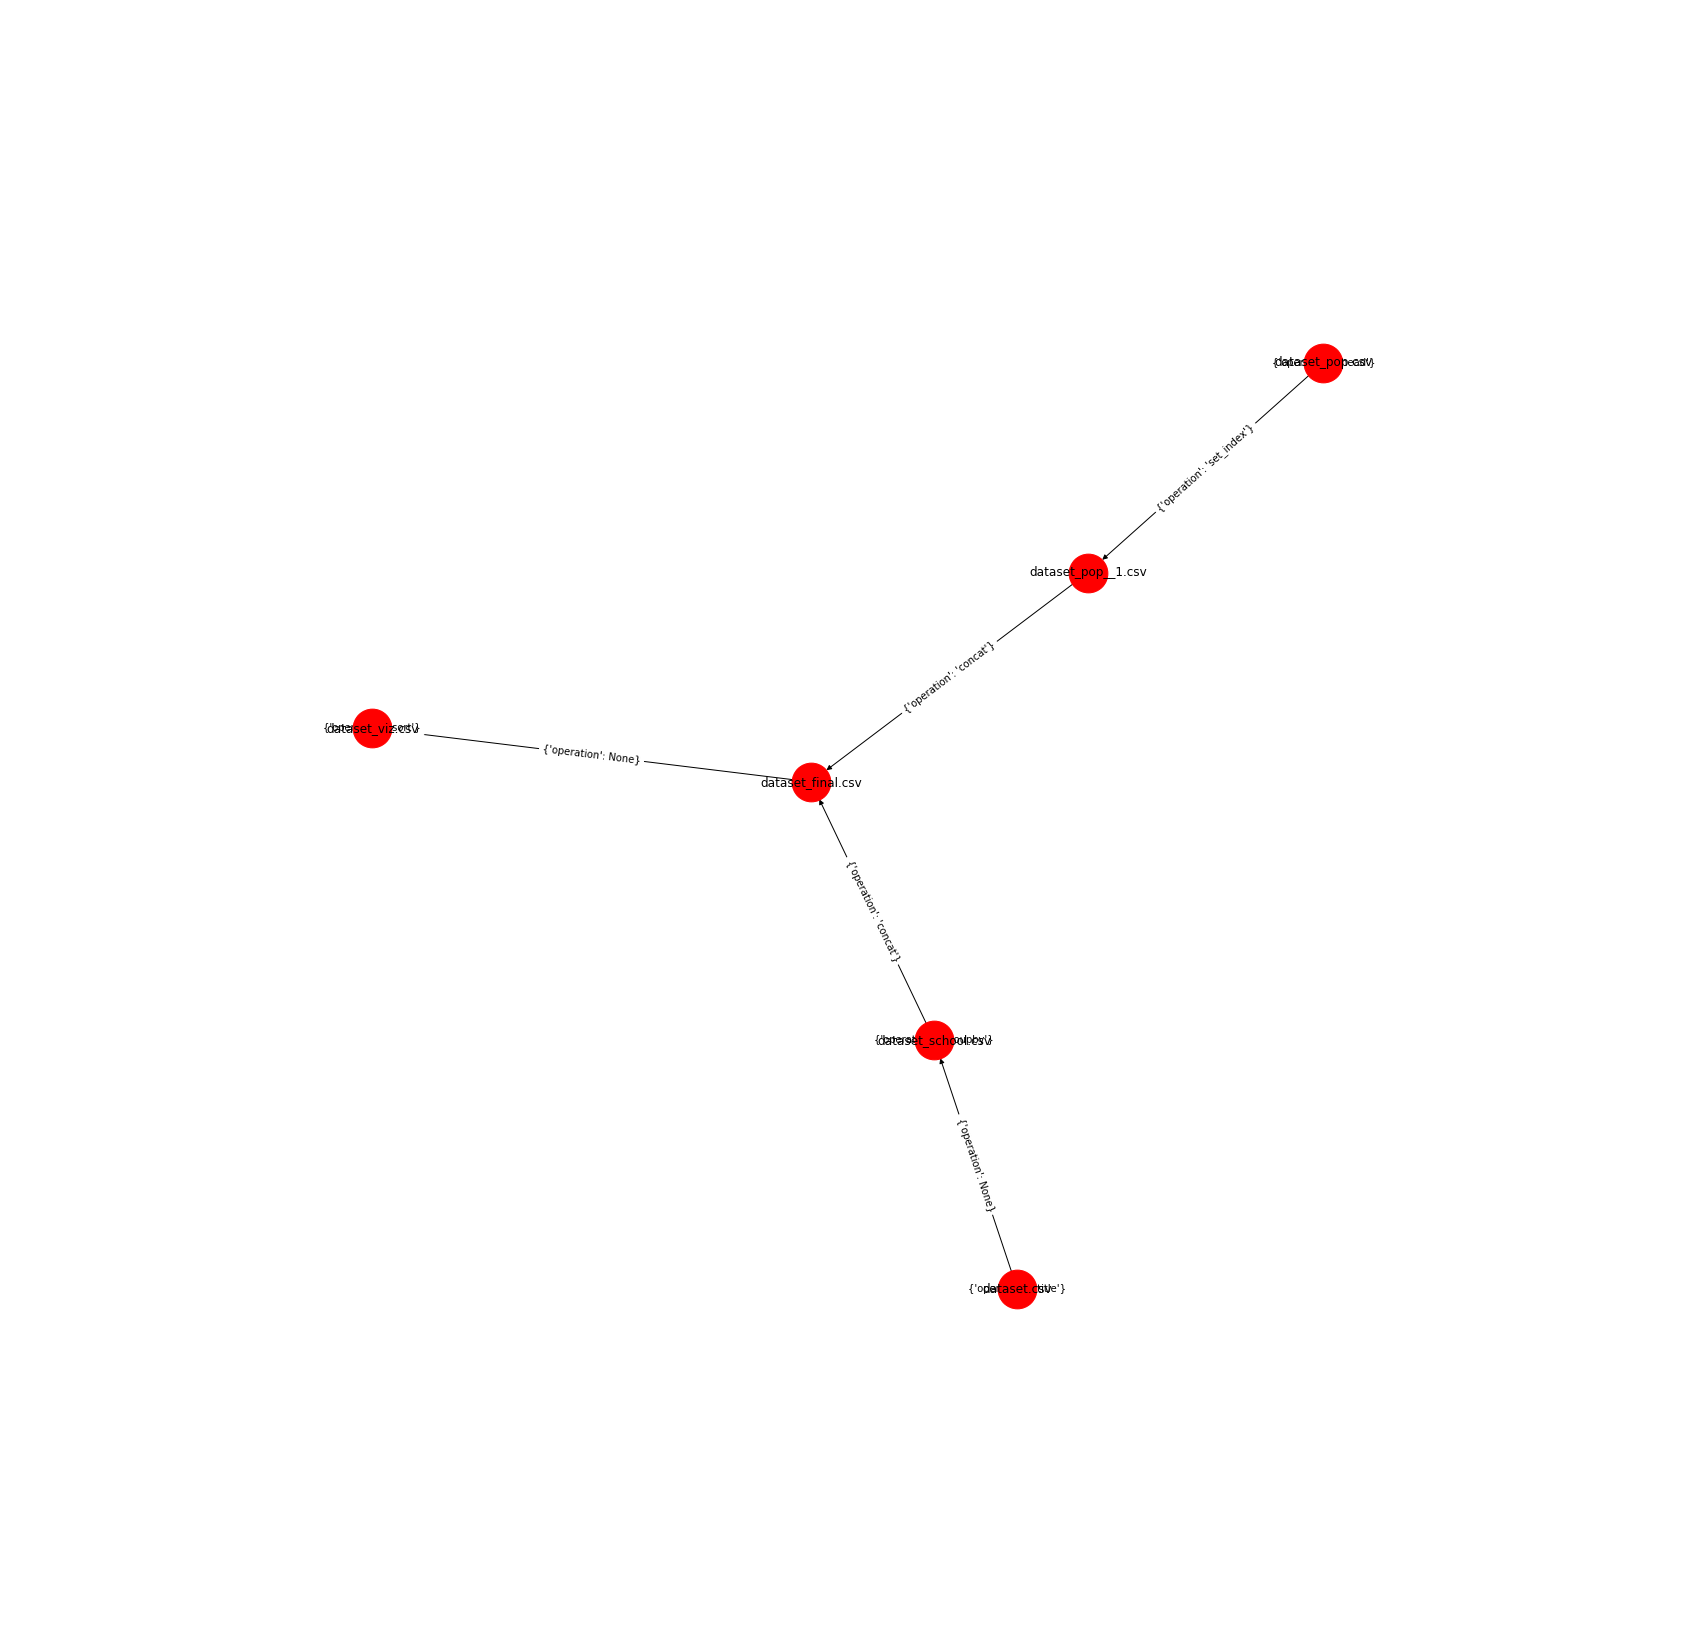

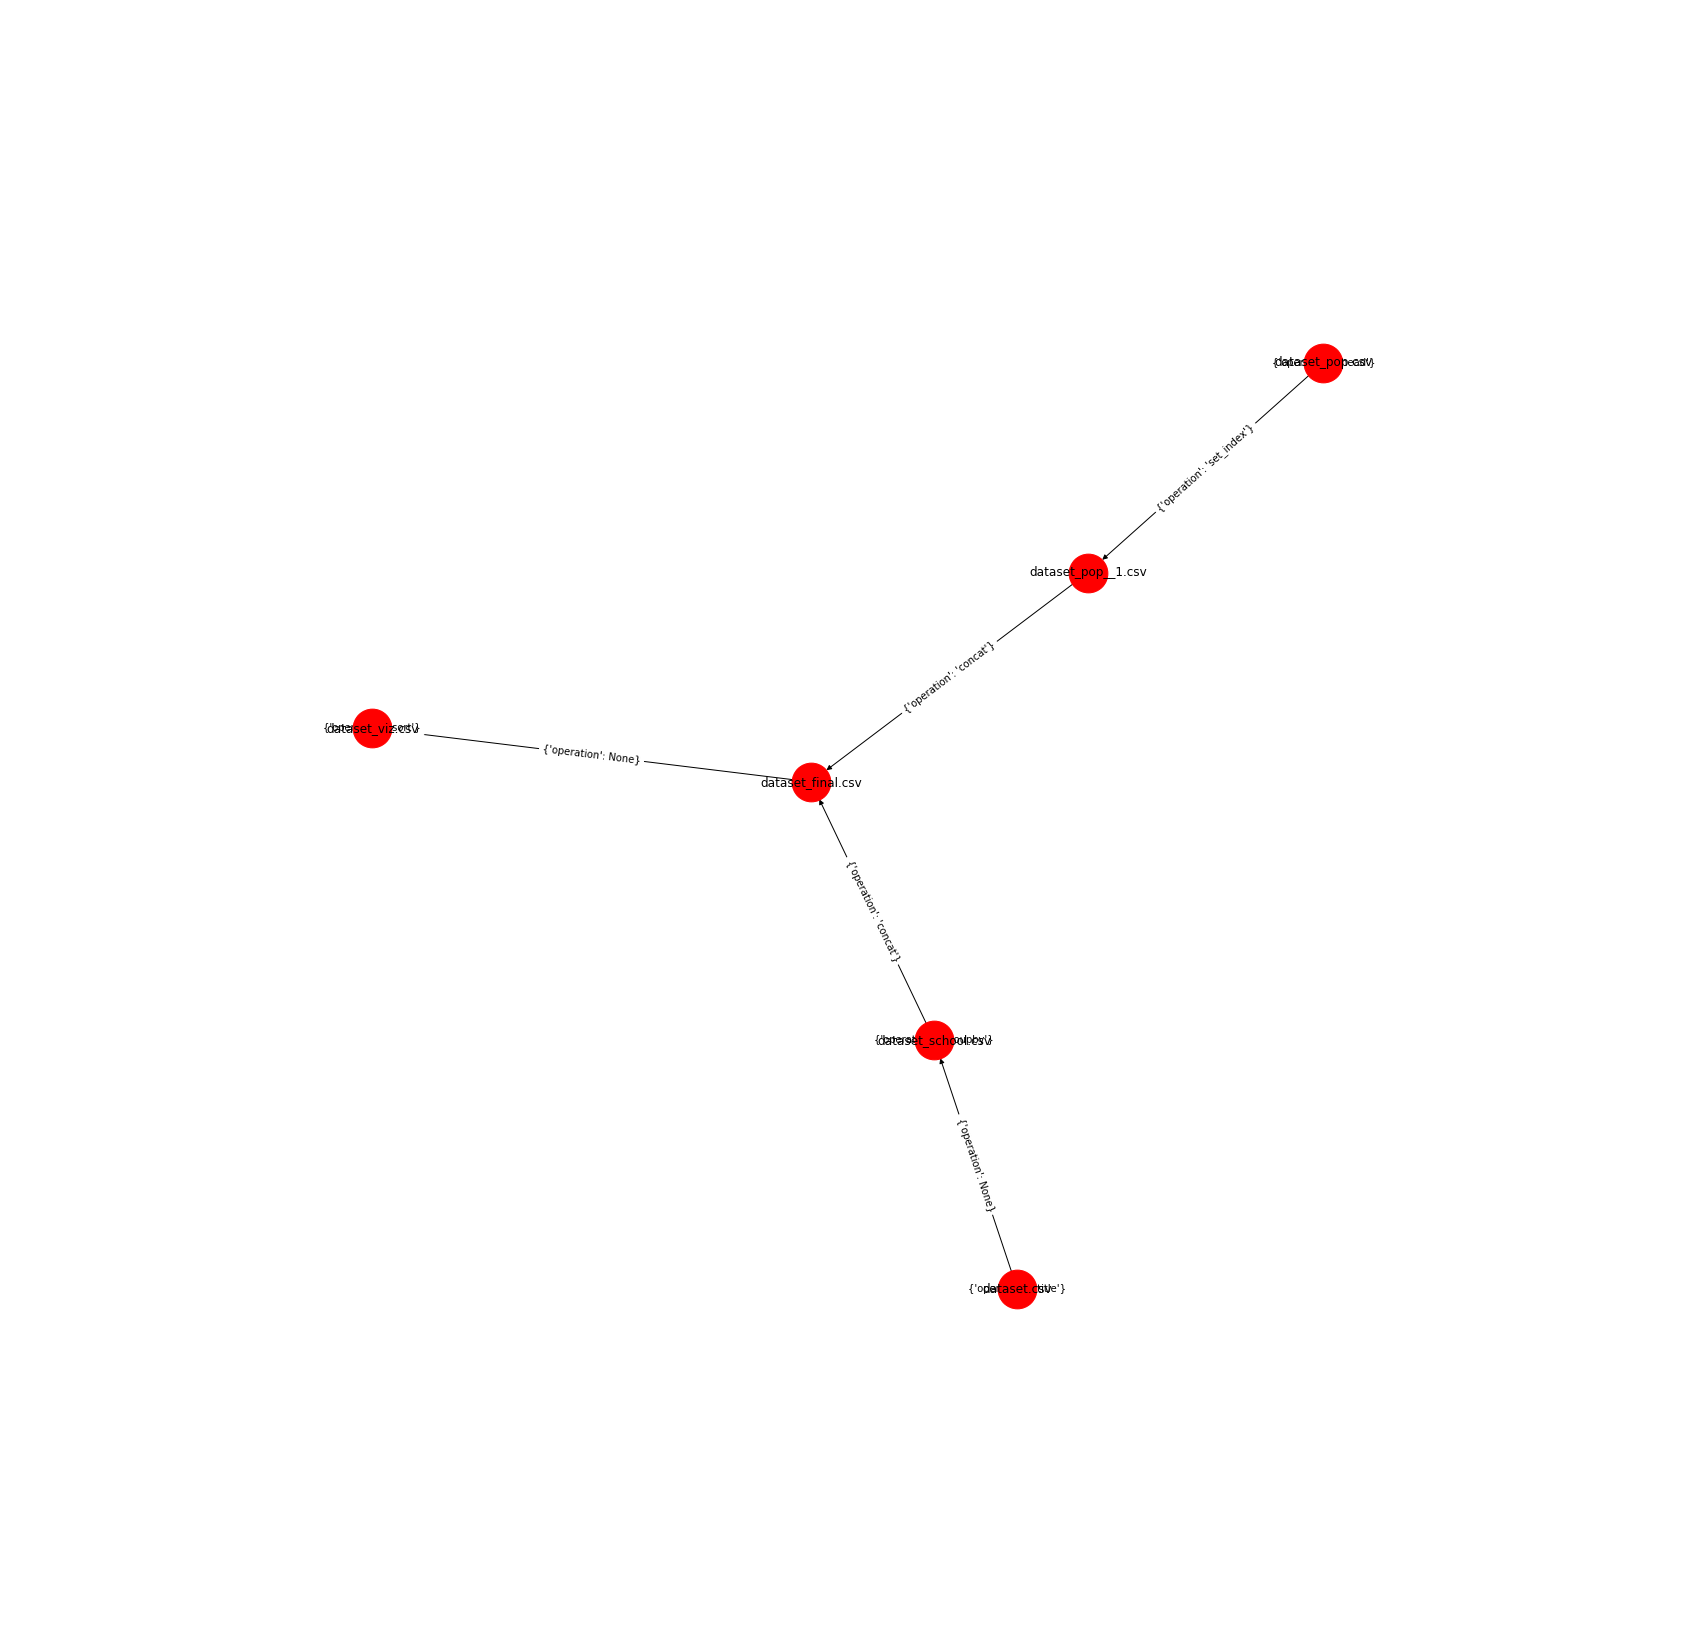

In [220]:
[display_notebook(nb) for nb in best_notebooks.index]

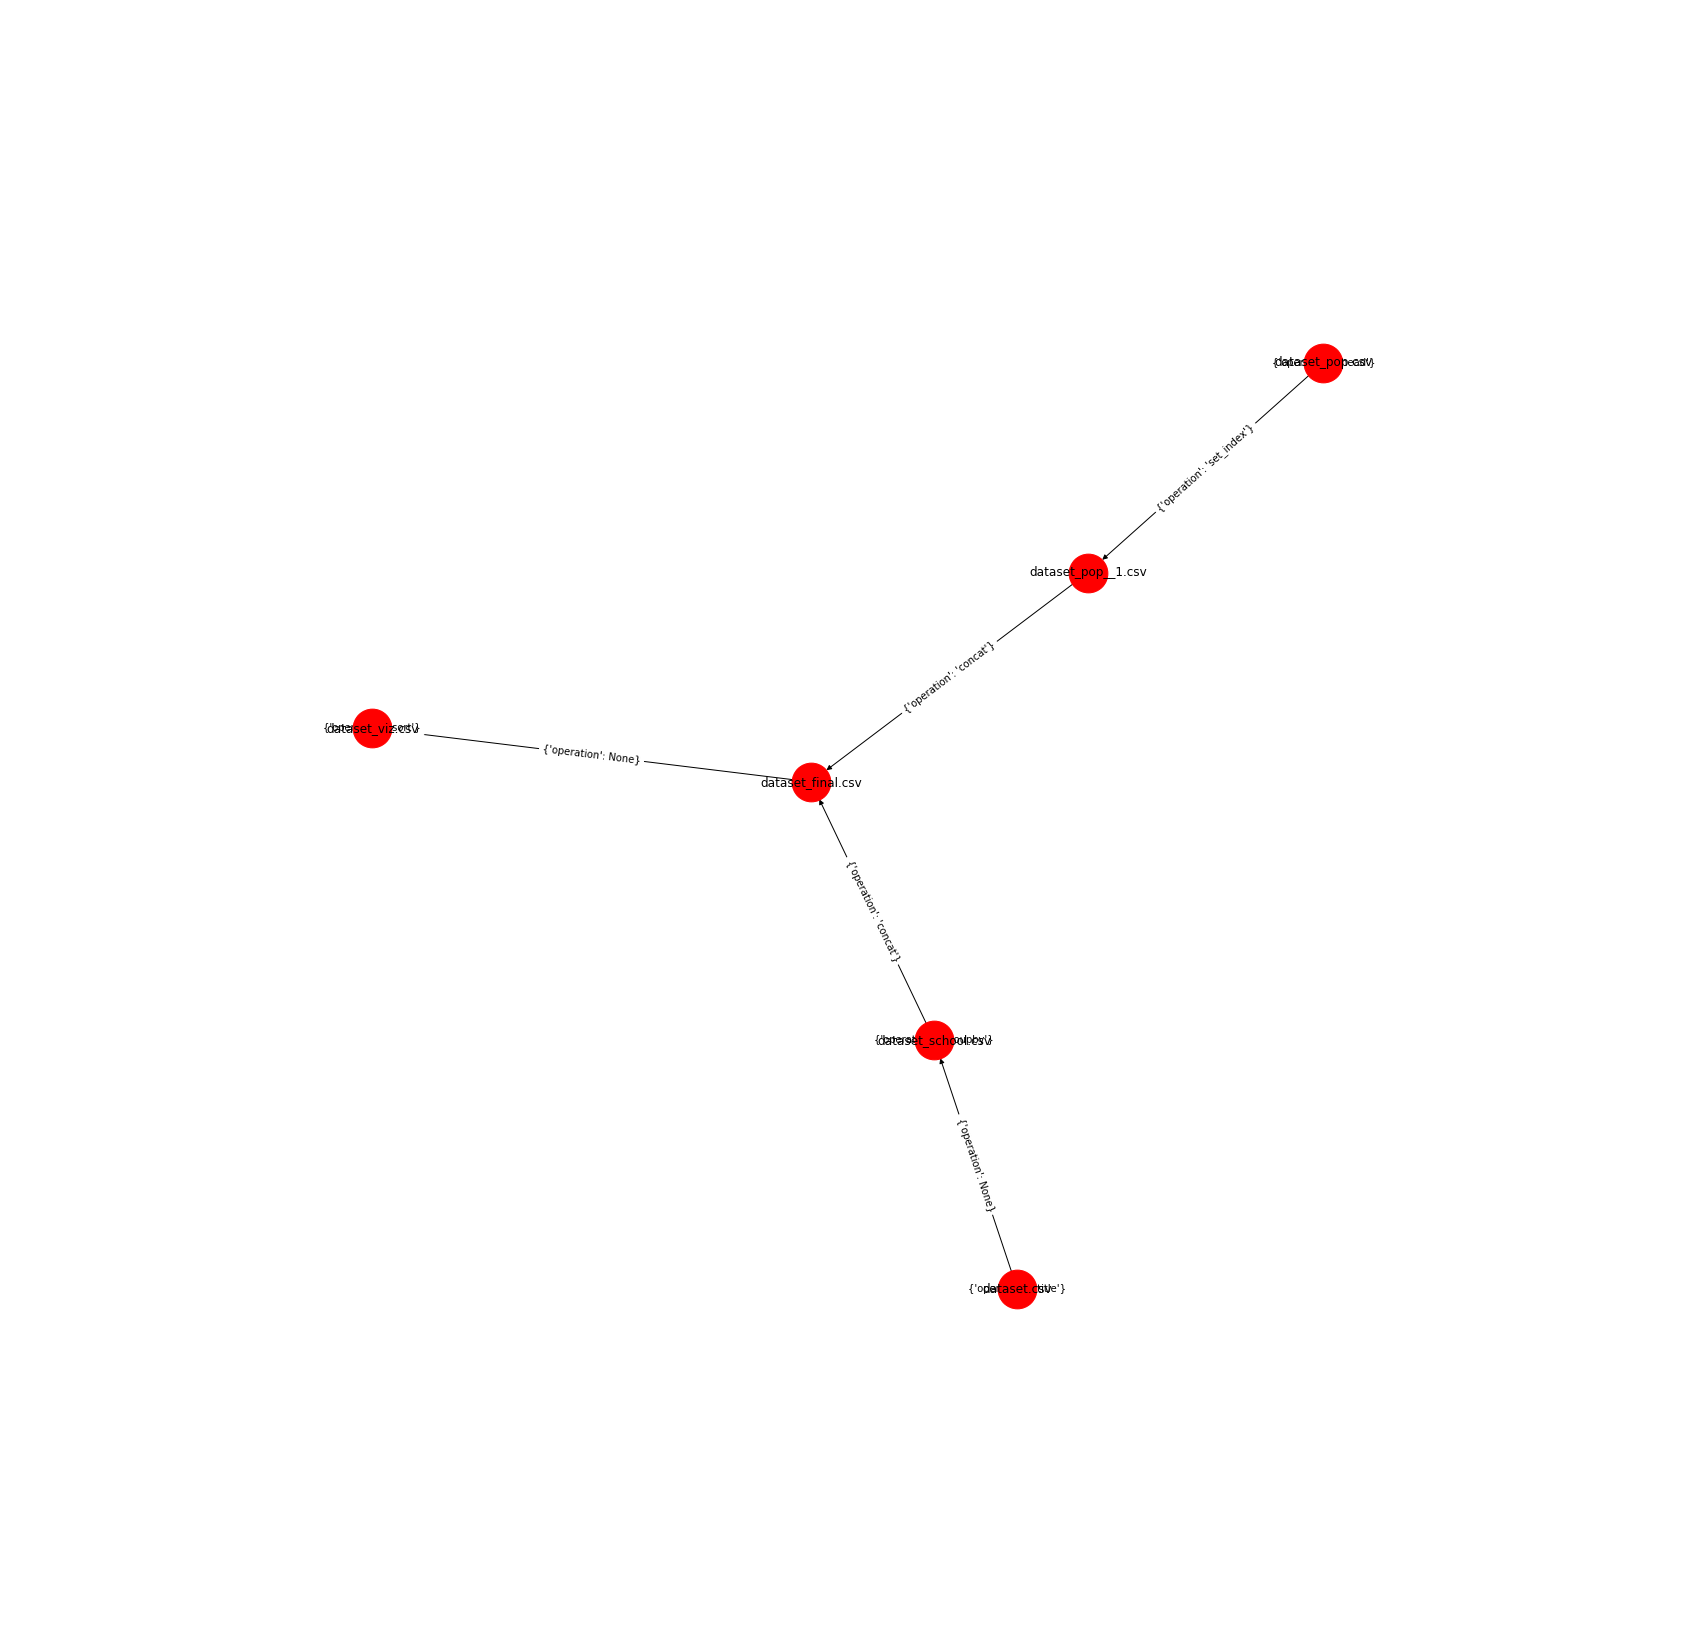

In [209]:
display_notebook('nb_924102.ipynb')

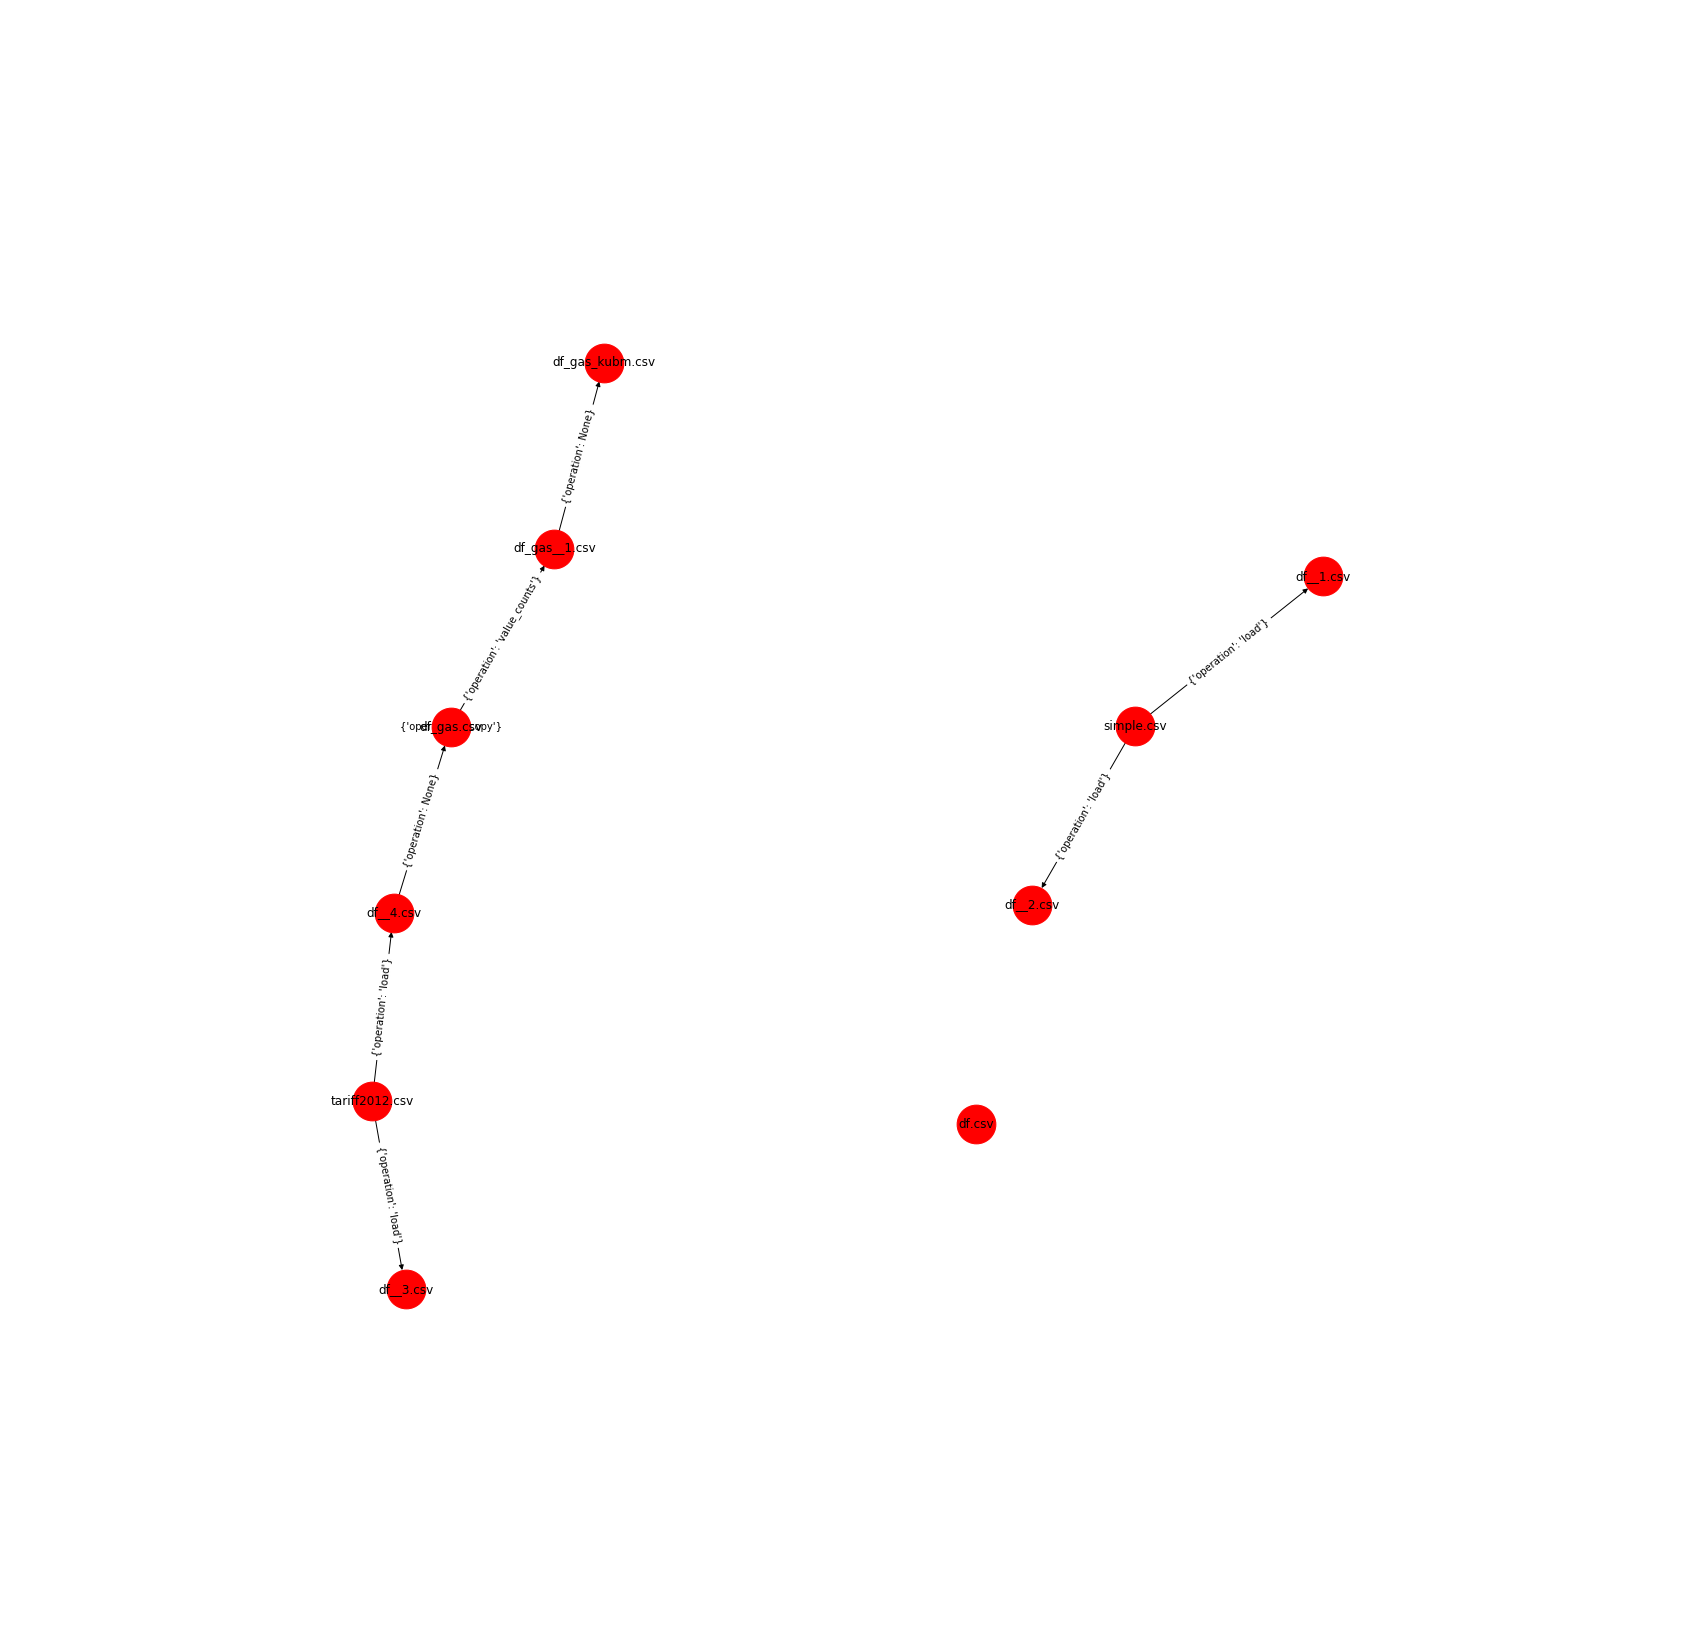

In [210]:
display_notebook('nb_316514.ipynb')

# Post Mortem

In [225]:
base_dir = '/media/suhail/Data/experiments/results/ok/'
wf_dir = '/media/suhail/Data/experiments/results/ok/nb_986282.ipynb'
nb_name  = os.path.basename(wf_dir)


In [258]:
def get_graph_edge_list(nb_name, metric):
    result_file = base_dir+nb_name+'/inferred/infered_mst_'+metric+'.csv'
    return nx.read_edgelist(result_file, delimiter=',', data=(('weight', float),))

def get_distance_matrix(nb_name, metric):
    result_file = base_dir+nb_name+'/inferred/'+metric+'_sim.csv'
    return pd.read_csv(result_file, index_col=0)


In [396]:
def generate_explaination_graph(g_truth, g_inferred, distance_matrix):
    exp_graph = nx.to_undirected(g_truth).copy()
    nx.set_edge_attributes(exp_graph, True, 'truth')
    for edge_t in g_inferred.edges(data=True):
        exp_graph.add_edge(edge_t[0], edge_t[1], inferred=True)
        if g_truth.has_edge(edge_t[0], edge_t[1]):
            exp_graph[edge_t[0]][edge_t[1]]['correct']=True
        elif g_truth.has_edge(edge_t[1], edge_t[0]):
            exp_graph[edge_t[0]][edge_t[1]]['correct']=True
        else:
            exp_graph[edge_t[0]][edge_t[1]]['correct']=False
    
    for edge_t in exp_graph.edges():
        try:
            exp_graph[edge_t[0]][edge_t[1]]['weight'] = distance_matrix[edge_t[0]][edge_t[1]]
        except KeyError as e:
            exp_graph[edge_t[0]][edge_t[1]]['weight'] = 0.0
        
    return exp_graph
    

In [397]:
g_truth = get_graph('nb_495072.ipynb')
g_infered = get_graph_edge_list('nb_495072.ipynb','col')
dist = get_distance_matrix('nb_495072.ipynb','col')
exp_graph = generate_explaination_graph(g_truth, g_infered, dist)


In [398]:
dist

contribs.csv  merged.csv  noncacontribs.csv  oppose.csv  \
name                                                                          
contribs.csv            1.000000    0.012443           0.010181    0.003394   
merged.csv              0.012443    1.000000           0.040909    0.013636   
noncacontribs.csv       0.010181    0.040909           1.000000    0.016667   
oppose.csv              0.003394    0.013636           0.016667    1.000000   
prop.csv                0.012443    0.050000           0.040909    0.013636   
props.csv               0.067061    0.007051           0.005769    0.001923   
support.csv             0.009050    0.036364           0.027273    0.000000   
top_supporters.csv      0.000000    0.000000           0.000000    0.000000   

                    prop.csv  props.csv  support.csv  top_supporters.csv  
name                                                                      
contribs.csv        0.012443   0.067061     0.009050                   0  
merged.csv          0.050000   0.007051     0.036364                   0  
noncacontribs.csv   0.040909   0.005769     0.027273                   0  
oppose.csv          0.013636   0.001923     0.000000                   0  
prop.csv            1.000000   0.017628     0.090909                   0  
props.csv           0.017628   1.000000     0.012821                   0  
support.csv         0.090909   0.012821     1.000000                   0  
top_supporters.csv  0.000000   0.000000     0.000000                   1

In [399]:
from networkx.drawing.nx_agraph import graphviz_layout

# Draw Graph Plot:
def draw_exp_graph(G, canvas_size=(8, 12), node_size=1500,
               layout_fn=graphviz_layout, **kwargs):
    # Set Canvas Size
    plt.figure(10, figsize=canvas_size)

    # Remove axes and set a margin to prevent cut-off
    ax = plt.gca()
    [sp.set_visible(False) for sp in ax.spines.values()]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.margins(0.30)

    root = kwargs.pop('root', None)
    pos = layout_fn(G, root=root, prog='dot')

    try:
        edge_labels = {i[0:2]: '{0:.4f}'.format(i[2]['weight'])
                       for i in G.edges(data=True)}
    except:
        edge_labels = None

    #nx.draw_networkx(G, pos=pos, with_labels=True, node_size=node_size)
    #nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    nx.draw_networkx_nodes(G, pos,
                       node_color='r',
                       node_size=500,
                       alpha=0.9)
    nx.draw_networkx_labels(G, pos, font_size=10)
    
    
    correct_edges = [edge for edge in G.edges(data=True) 
                     if 'correct' in edge[2] and edge[2]['correct']]
    
    print(correct_edges)
    
    nx.draw_networkx_edges(G, pos,
                       edgelist=correct_edges,
                       width=8, alpha=0.5, edge_color='green')
    
    incorrect_edges = [edge for edge in G.edges(data=True) 
                       if 'correct' in edge[2] and edge[2]['correct'] == False]
    
    nx.draw_networkx_edges(G, pos,
                       edgelist=incorrect_edges,
                       width=3, alpha=0.5, edge_color='red', style='dashed')
    
    print(incorrect_edges)
    
    gt_edges = [edge for edge in G.edges(data=True) 
                       if 'truth' in edge[2] and edge[2]['truth'] == True]
    
    nx.draw_networkx_edges(G, pos,
                       edgelist=gt_edges,
                       width=2, alpha=0.75, edge_color='black')
    edge_labels = {}
    for i in G.edges(data=True):
        edge_label = ''
        if 'truth' in i[2] and i[2]['truth'] == True:
            if i[2]['operation'] is not None:
                edge_label = edge_label + i[2]['operation']
        
        if 'weight' in i[2]:
            edge_label = edge_label + ' ('+'{0:.8f}'.format(i[2]['weight'])+')'
        
        edge_labels[(i[0],i[1])] = edge_label
                  
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

    
    plt.show()

[('props.csv', 'prop.csv', {'operation': None, 'truth': True, 'inferred': True, 'correct': True, 'weight': 0.0176282}), ('prop.csv', 'merged.csv', {'operation': 'merge', 'truth': True, 'inferred': True, 'correct': True, 'weight': 0.05}), ('merged.csv', 'noncacontribs.csv', {'operation': None, 'truth': True, 'inferred': True, 'correct': True, 'weight': 0.040909100000000004})]
[('props.csv', 'contribs.csv', {'inferred': True, 'correct': False, 'weight': 0.06706110000000001}), ('prop.csv', 'support.csv', {'inferred': True, 'correct': False, 'weight': 0.0909091}), ('oppose.csv', 'noncacontribs.csv', {'inferred': True, 'correct': False, 'weight': 0.0166667})]


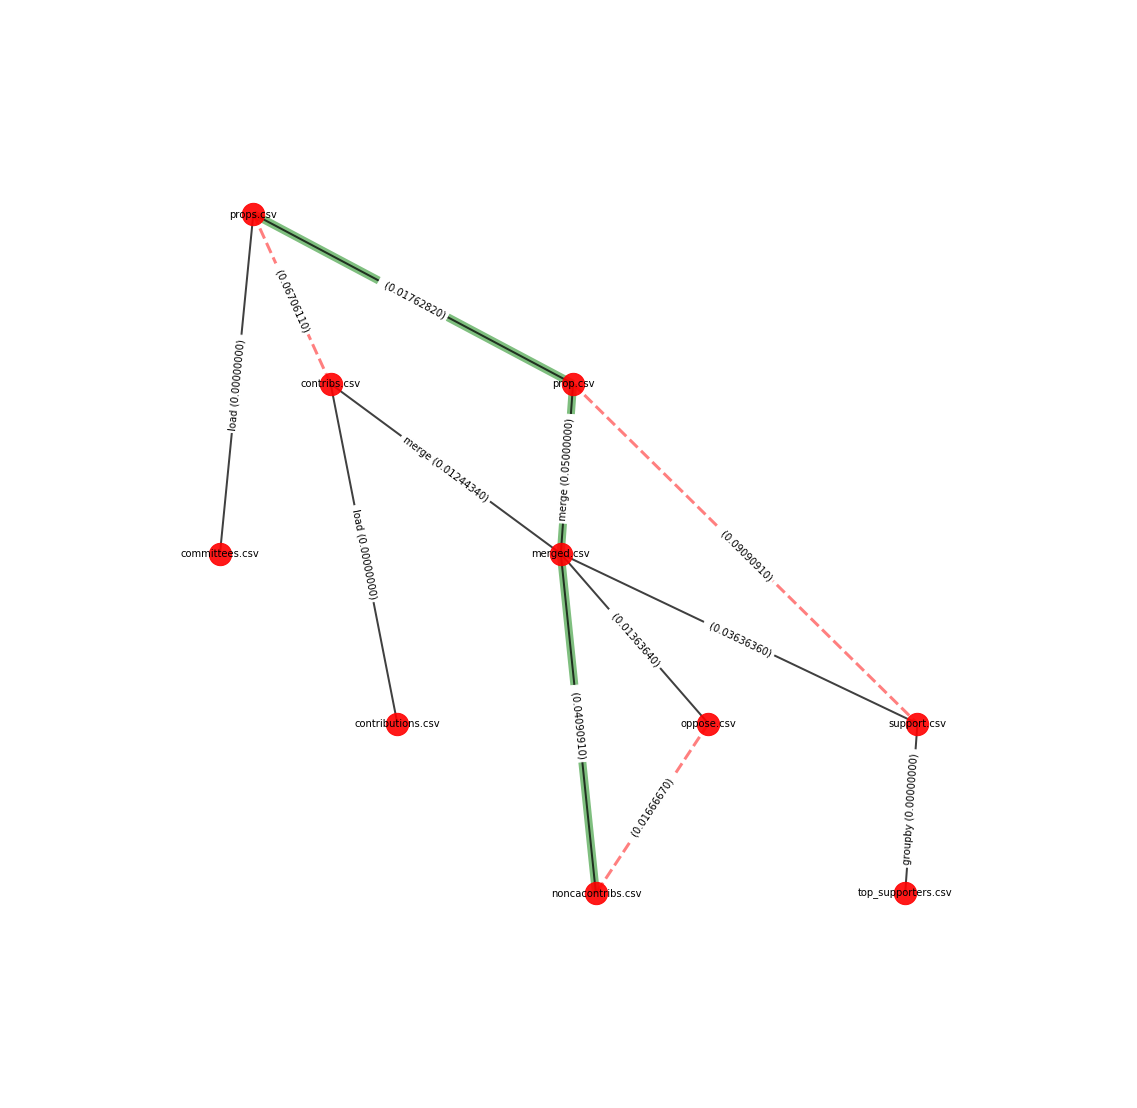

In [400]:
draw_exp_graph(exp_graph, canvas_size=(20,20))

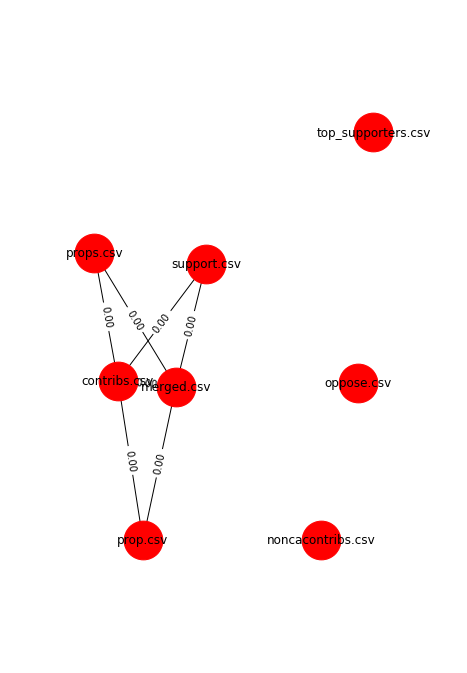

In [362]:
import numpy as np
dist_df = pd.read_csv(get_distance_graph('nb_495072','cell'), index_col=0)
dist_df = dist_df.astype(np.float64)
graphs.draw_graph(nx.from_pandas_adjacency(dist_df))

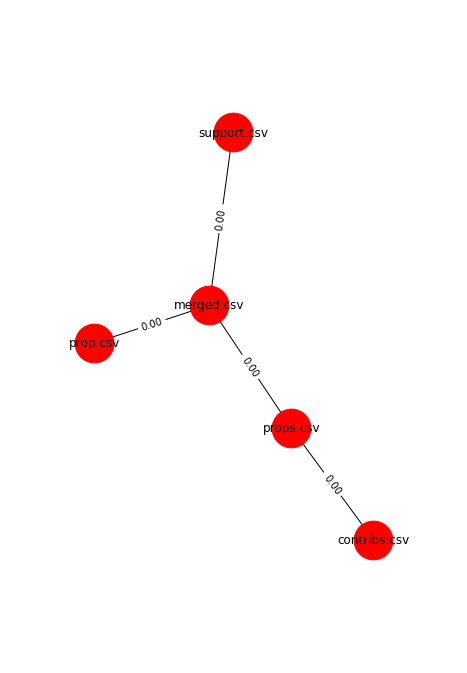

In [229]:
g_infered = get_graph_edge_list('nb_495072','cell')
graphs.draw_graph(g_infered)